In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Preparation

In [4]:
!pip install open_clip_torch torchvision pandas tqdm groq

# Import github code
import os

if not "SemFew" in os.getcwd():
    print("Cloning directory")
    get_ipython().system(f"git clone https://github.com/jdieguvi15/TFM-SemFew.git")
    os.chdir('./TFM-SemFew/Model')
print(f"Current working directory: {os.getcwd()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
Cloning directory
Cloning into 'TFM-SemFew'...
remote: Enumerating objects: 808, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 808 (delta 0), reused 1 (delta 0), pack-reused 803 (from 2)
Receiving objects: 100% (808/808), 146.22 MiB | 39.82 MiB/s, done.
Resolving deltas: 100% (422/422), done.
Updating files: 100% (314/314), done.
Current working directory: /kaggle/working/TFM-SemFew/Model


In [5]:
#os.chdir('../..')
#print(f"Current working directory: {os.getcwd()}")

#!rm -rf /kaggle/working/TFM-SemFew
!cd /kaggle/working/TFM-SemFew
!git pull

Already up to date.


In [6]:
!ls /kaggle/input/cifar-fs/cifar-fs

splits	test  train  val


# Config

In [5]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    # Wandb
    "project": "SemFew_recreate",
    "run_name": "default_resnet",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "default",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

In [6]:
import wandb
wandb.login(key=WANDB_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Compute centers

In [8]:
from compute_center import main as compute_center
from method.train import train
from method.test import test

# With SWIN (previous config)

centers = compute_center(args)

Using device: cuda


/kaggle/working/TFM-SemFew/Model/compute_center.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.model_path, map_location=device)['params']


183


100%|██████████| 301/301 [05:20<00:00,  1.07s/it]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Train

In [9]:
from method.train import train

train(args)

2025-05-27 16:02:57,968 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

183


100%|██████████| 301/301 [01:37<00:00,  3.08it/s]
2025-05-27 16:05:05,538 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.305730] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 16:07:35,730 - train.py[line:226] - INFO: best epoch: 0
2025-05-27 16:07:35,734 - train.py[line:231] - INFO: epoch: 0 |origin acc: 67.32+0.98% |complete acc: 68.89+0.99% |gap: 1.56/1.56 |k: 0.31
2025-05-27 16:07:35,735 - train.py[line:235] - INFO: ACC |proto acc: 67.32+0.98% |gen acc: 68.20+0.99% |Max: 68.89


save 0


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:09:11,795 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.197488] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 16:11:41,522 - train.py[line:231] - INFO: epoch: 1 |origin acc: 65.95+0.95% |complete acc: 68.46+0.96% |gap: 2.51/2.51 |k: 0.18
2025-05-27 16:11:41,523 - train.py[line:235] - INFO: ACC |proto acc: 65.95+0.95% |gen acc: 67.57+0.98% |Max: 68.89
100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:13:17,598 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.164216] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 16:15:47,480 - train.py[line:226] - INFO: best epoch: 2
2025-05-27 16:15:47,484 - train.py[line:231] - INFO: epoch: 2 |origin acc: 66.22+0.96% |complete acc: 70.84+0.90% |gap: 4.61/4.61 |k: 0.13
2025-05-27 16:15:47,485 - train.py[line:235] - INFO: ACC |proto acc: 66.22+0.96% |gen acc: 70.44+0.90% |Max: 70.84


save 2


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:17:23,567 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.260983] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 16:19:53,685 - train.py[line:226] - INFO: best epoch: 3
2025-05-27 16:19:53,688 - train.py[line:231] - INFO: epoch: 3 |origin acc: 65.91+0.98% |complete acc: 71.96+0.88% |gap: 6.05/6.05 |k: 0.09
2025-05-27 16:19:53,689 - train.py[line:235] - INFO: ACC |proto acc: 65.91+0.98% |gen acc: 71.61+0.88% |Max: 71.96


save 3


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 16:21:29,616 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.087021] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 16:23:59,228 - train.py[line:226] - INFO: best epoch: 4
2025-05-27 16:23:59,232 - train.py[line:231] - INFO: epoch: 4 |origin acc: 65.97+0.96% |complete acc: 74.35+0.82% |gap: 8.39/8.39 |k: 0.07
2025-05-27 16:23:59,233 - train.py[line:235] - INFO: ACC |proto acc: 65.97+0.96% |gen acc: 73.80+0.83% |Max: 74.35


save 4


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:25:35,491 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.089915] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 16:28:06,005 - train.py[line:226] - INFO: best epoch: 5
2025-05-27 16:28:06,009 - train.py[line:231] - INFO: epoch: 5 |origin acc: 66.22+0.97% |complete acc: 74.84+0.80% |gap: 8.62/8.62 |k: 0.11
2025-05-27 16:28:06,010 - train.py[line:235] - INFO: ACC |proto acc: 66.22+0.97% |gen acc: 74.19+0.79% |Max: 74.84


save 5


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:29:42,113 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.072568] 
100%|██████████| 600/600 [02:31<00:00,  3.97it/s]
2025-05-27 16:32:13,234 - train.py[line:226] - INFO: best epoch: 6
2025-05-27 16:32:13,238 - train.py[line:231] - INFO: epoch: 6 |origin acc: 66.95+0.97% |complete acc: 76.21+0.77% |gap: 9.26/9.26 |k: 0.11
2025-05-27 16:32:13,239 - train.py[line:235] - INFO: ACC |proto acc: 66.95+0.97% |gen acc: 75.68+0.77% |Max: 76.21


save 6


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:33:49,497 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.126260] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 16:36:19,275 - train.py[line:226] - INFO: best epoch: 7
2025-05-27 16:36:19,278 - train.py[line:231] - INFO: epoch: 7 |origin acc: 66.42+0.97% |complete acc: 76.47+0.80% |gap: 10.04/10.04 |k: 0.12
2025-05-27 16:36:19,280 - train.py[line:235] - INFO: ACC |proto acc: 66.42+0.97% |gen acc: 75.63+0.80% |Max: 76.47


save 7


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 16:37:55,103 - train.py[line:162] - INFO: [Epoch 8/50] [recon loss: 0.088710] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 16:40:24,919 - train.py[line:231] - INFO: epoch: 8 |origin acc: 65.93+0.95% |complete acc: 76.31+0.77% |gap: 10.38/10.38 |k: 0.13
2025-05-27 16:40:24,921 - train.py[line:235] - INFO: ACC |proto acc: 65.93+0.95% |gen acc: 75.35+0.79% |Max: 76.47
100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:42:01,209 - train.py[line:162] - INFO: [Epoch 9/50] [recon loss: 0.093649] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 16:44:30,937 - train.py[line:226] - INFO: best epoch: 9
2025-05-27 16:44:30,941 - train.py[line:231] - INFO: epoch: 9 |origin acc: 65.66+0.93% |complete acc: 76.65+0.76% |gap: 10.99/10.99 |k: 0.12
2025-05-27 16:44:30,942 - train.py[line:235] - INFO: ACC |proto acc: 65.66+0.93% |gen acc: 75.75+0.75% |Max: 76.65


save 9


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 16:46:06,905 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.091154] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 16:48:37,121 - train.py[line:226] - INFO: best epoch: 10
2025-05-27 16:48:37,125 - train.py[line:231] - INFO: epoch: 10 |origin acc: 66.64+0.94% |complete acc: 77.57+0.74% |gap: 10.99/10.94 |k: 0.13
2025-05-27 16:48:37,126 - train.py[line:235] - INFO: ACC |proto acc: 66.64+0.94% |gen acc: 76.37+0.74% |Max: 77.57


save 10


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 16:50:13,220 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.069080] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 16:52:43,637 - train.py[line:231] - INFO: epoch: 11 |origin acc: 65.80+0.98% |complete acc: 76.77+0.75% |gap: 10.99/10.96 |k: 0.13
2025-05-27 16:52:43,638 - train.py[line:235] - INFO: ACC |proto acc: 65.80+0.98% |gen acc: 75.54+0.77% |Max: 77.57
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 16:54:19,589 - train.py[line:162] - INFO: [Epoch 12/50] [recon loss: 0.036822] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 16:56:49,541 - train.py[line:231] - INFO: epoch: 12 |origin acc: 65.84+0.99% |complete acc: 76.82+0.75% |gap: 10.99/10.98 |k: 0.11
2025-05-27 16:56:49,543 - train.py[line:235] - INFO: ACC |proto acc: 65.84+0.99% |gen acc: 75.60+0.76% |Max: 77.57
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 16:58:25,469 - train.py[line:162] - INFO: [

save 14


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 17:06:36,488 - train.py[line:162] - INFO: [Epoch 15/50] [recon loss: 0.048614] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 17:09:06,464 - train.py[line:231] - INFO: epoch: 15 |origin acc: 66.29+0.96% |complete acc: 77.34+0.77% |gap: 11.22/11.06 |k: 0.14
2025-05-27 17:09:06,466 - train.py[line:235] - INFO: ACC |proto acc: 66.29+0.96% |gen acc: 75.79+0.78% |Max: 77.70
100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 17:10:42,655 - train.py[line:162] - INFO: [Epoch 16/50] [recon loss: 0.039033] 
100%|██████████| 600/600 [02:31<00:00,  3.97it/s]
2025-05-27 17:13:13,951 - train.py[line:231] - INFO: epoch: 16 |origin acc: 66.37+0.97% |complete acc: 77.38+0.77% |gap: 11.22/11.01 |k: 0.15
2025-05-27 17:13:13,953 - train.py[line:235] - INFO: ACC |proto acc: 66.37+0.97% |gen acc: 75.69+0.77% |Max: 77.70
100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 17:14:50,020 - train.py[line:162] - INFO: [

save 17


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 17:18:56,019 - train.py[line:162] - INFO: [Epoch 18/50] [recon loss: 0.026638] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 17:21:25,904 - train.py[line:231] - INFO: epoch: 18 |origin acc: 66.60+0.97% |complete acc: 77.18+0.76% |gap: 11.22/10.58 |k: 0.17
2025-05-27 17:21:25,906 - train.py[line:235] - INFO: ACC |proto acc: 66.60+0.97% |gen acc: 75.25+0.76% |Max: 78.09
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 17:23:01,700 - train.py[line:162] - INFO: [Epoch 19/50] [recon loss: 0.027734] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 17:25:31,466 - train.py[line:231] - INFO: epoch: 19 |origin acc: 65.96+0.98% |complete acc: 77.55+0.75% |gap: 11.59/11.59 |k: 0.14
2025-05-27 17:25:31,467 - train.py[line:235] - INFO: ACC |proto acc: 65.96+0.98% |gen acc: 75.41+0.75% |Max: 78.09
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 17:27:07,443 - train.py[line:162] - INFO: [

save 22


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 17:39:25,552 - train.py[line:162] - INFO: [Epoch 23/50] [recon loss: 0.023695] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 17:41:55,765 - train.py[line:231] - INFO: epoch: 23 |origin acc: 66.18+0.92% |complete acc: 77.90+0.76% |gap: 11.72/11.72 |k: 0.19
2025-05-27 17:41:55,767 - train.py[line:235] - INFO: ACC |proto acc: 66.18+0.92% |gen acc: 75.90+0.77% |Max: 78.32
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 17:43:31,733 - train.py[line:162] - INFO: [Epoch 24/50] [recon loss: 0.025523] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 17:46:01,902 - train.py[line:231] - INFO: epoch: 24 |origin acc: 66.13+0.99% |complete acc: 77.86+0.73% |gap: 11.73/11.73 |k: 0.19
2025-05-27 17:46:01,903 - train.py[line:235] - INFO: ACC |proto acc: 66.13+0.99% |gen acc: 75.96+0.74% |Max: 78.32
100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 17:47:38,208 - train.py[line:162] - INFO: [

save 31


100%|██████████| 301/301 [01:36<00:00,  3.12it/s]
2025-05-27 18:16:21,155 - train.py[line:162] - INFO: [Epoch 32/50] [recon loss: 0.014686] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 18:18:51,165 - train.py[line:231] - INFO: epoch: 32 |origin acc: 66.71+0.92% |complete acc: 78.15+0.73% |gap: 12.05/11.44 |k: 0.19
2025-05-27 18:18:51,167 - train.py[line:235] - INFO: ACC |proto acc: 66.71+0.92% |gen acc: 76.13+0.74% |Max: 78.59
100%|██████████| 301/301 [01:36<00:00,  3.12it/s]
2025-05-27 18:20:27,534 - train.py[line:162] - INFO: [Epoch 33/50] [recon loss: 0.014385] 
100%|██████████| 600/600 [02:30<00:00,  3.98it/s]
2025-05-27 18:22:58,250 - train.py[line:231] - INFO: epoch: 33 |origin acc: 66.03+0.93% |complete acc: 77.37+0.75% |gap: 12.05/11.34 |k: 0.15
2025-05-27 18:22:58,251 - train.py[line:235] - INFO: ACC |proto acc: 66.03+0.93% |gen acc: 75.43+0.76% |Max: 78.59
100%|██████████| 301/301 [01:36<00:00,  3.14it/s]
2025-05-27 18:24:34,261 - train.py[line:162] - INFO: [

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0 mlp_ratio=4
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm(

In [24]:
from method.test import test

print(f"Current working directory: {os.getcwd()}")
test(args)

2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}
2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}
2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}
2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}
2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}
2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}
2025-05-27 19:41:04,260 - test.py[line:28] - INFO: {}


Current working directory: /kaggle/working/TFM-SemFew/Model


2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,386 - test.py[line:89] - INFO: best epoch: 31 78.591113
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0.140000
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0.140000
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0.140000
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0.140000
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0.140000
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0.140000
2025-05-27 19:41:10,392 - test.py[line:90] - INFO: best k: 0

183


100%|██████████| 600/600 [01:59<00:00,  5.04it/s]
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,535 - test.py[line:130] - INFO: max |k:             0.14 |mix acc: 84.32+0.68% |gap: 7.46
2025-05-27 19:43:09,540 - test.py[line:132] - INFO: ACC:|proto acc: 76.87+0.85% |gen acc: 81.46+0.77%
2025-05-27 19:43:09,540 - test.py[line:132] - INFO: ACC:|proto acc: 76.87+0.85

# Confussion Matrix

In [7]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

from data.samplers import CategoriesSampler
from logger import loggers
from model.res12 import Res12
from model.swin_transformer import swin_tiny
from utils import (
    set_seed, Cosine_classifier, count_95acc, count_kacc,
    transform_val_cifar, transform_val, transform_val_224, transform_val_224_cifar
)

# Function to load dataset
def load_data(args, device, split, sample=True):
    """Loads the test dataset based on the given arguments."""
    set_seed(args.seed)

    assert split in ['train', 'test', 'val'], "Split name not available"
    
    if args.dataset == 'TieredImageNet':
        args.num_workers = 0

    if args.dataset == 'MiniImageNet':
        args.test = '/path/to/your/miniimagent/' + split
        test_dataset = ImageFolder(args.test, transform=transform_val if args.backbone == 'resnet' else transform_val_224)
    elif args.dataset == 'FC100':
        args.test = '/path/to/your/fc100/' + split
        test_dataset = ImageFolder(args.test, transform=transform_val_cifar if args.backbone == 'resnet' else transform_val_224_cifar)
    elif args.dataset == 'CIFAR-FS':
        args.test = args.path_to_cifarfs + split
        test_dataset = ImageFolder(args.test, transform=transform_val_cifar if args.backbone == 'resnet' else transform_val_224_cifar)
    elif args.dataset == 'TieredImageNet':
        test_dataset = tieredImageNet(setname=split)

        if args.backbone == 'resnet':
            args.test = '/path/to/your/tiredimagenet/' + split
            test_dataset = ImageFolder(args.test, transform=transform_val_224)
    else:
        raise ValueError('Non-supported Dataset.')

    idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

    # Sample or use all data
    if sample:
        val_sampler = CategoriesSampler(test_dataset.targets, args.test_batch, args.test_way, args.shot + args.query)
        val_loader = DataLoader(dataset=test_dataset, batch_sampler=val_sampler, num_workers=args.num_workers, pin_memory=True)
    else:
        val_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False,
                              num_workers=args.num_workers, pin_memory=True)

    if 'ImageNet' in args.dataset:
        semantic = torch.load('./semantic/imagenet_semantic_{}_{}.pth'.format(args.mode, args.text_type), map_location=device)['semantic_feature']
    else:
        semantic = torch.load('./semantic/cifar100_semantic_{}_{}.pth'.format(args.mode, args.text_type), map_location=device)['semantic_feature']
    semantic = {k: v.float() for k, v in semantic.items()}

    return val_loader, idx_to_class, semantic

# Function to load model
def load_model(args, device):
    """Loads the specified backbone model and weights."""
    if args.backbone == 'resnet':
        model = Res12(avg_pool=True, drop_block='ImageNet' in args.dataset).to(device)
        model_dict = model.state_dict()
        checkpoint = torch.load(args.model_path, map_location=device)['params']
        checkpoint = {k[8:]: v for k, v in checkpoint.items()}
        checkpoint = {k: v for k, v in checkpoint.items() if k in model_dict}

    elif args.backbone == 'swin':
        model = swin_tiny().to(device)
        model_dict = model.state_dict()
        checkpoint = torch.load(args.model_path, map_location=device)['params']
        checkpoint = {k: v for k, v in checkpoint.items() if k in model_dict}

    model.load_state_dict(checkpoint)
    model.eval()

    return model

# Function to perform inference
def predict(args, model, device, val_loader, idx_to_class, semantic, log, study_k=False):
    """Runs inference."""

    Model_PATH = os.path.join(args.work_dir, 'epoch_best.pth')
    H = torch.load(Model_PATH, map_location=device)
    fusion = H['G']
    best_epoch = H['epoch']
    best_acc = H['acc']
    best_k = H['k']
    log.info('best epoch: %d %2f' % (best_epoch, best_acc * 100))
    log.info('best k: %2f' % (float(best_k)))
    
    label = torch.arange(args.test_way).repeat(args.query).to(device, dtype=torch.long)

    all_data, all_preds0, all_preds1, all_preds2, all_targets = [], [], [], [], []
    
    with torch.no_grad():
        for data0, labels in tqdm(val_loader, desc="Testing"):
            data, labels = data0.to(device), labels.to(device)
            data = model(data).view(data.size(0), -1)

            n_support = args.shot * args.test_way
            support, query = data[:n_support], data[n_support:]

            # Create label map for this episode
            episode_label_map = {i: labels[i].item() for i in range(args.test_way)}
            assert [episode_label_map[int(l.item())] for l in label.cpu()] == labels[n_support:].tolist(), "The mapping is not correct"

            # proto es el avg de las imagenes del support
            # gen_proto junts el proto con ls text feature
            proto = support.reshape(args.shot, args.test_way, -1).mean(dim=0)
            gen_proto = fusion(
                torch.stack([semantic[idx_to_class[l.item()]] for l in labels[:n_support]]).to(device),
                support
            ).reshape(args.shot, args.test_way, -1).mean(dim=0)

            dist0, predict0 = Cosine_classifier(proto, query)
            dist1, predict1 = Cosine_classifier(gen_proto, query)

            # mixed prediction
            mixed = float(best_k) * proto + (1 - float(best_k)) * gen_proto
            dist2, predict2 = Cosine_classifier(mixed, query)

            # Convert predictions and query labels back to real class indices
            real_preds0 = [episode_label_map[p.item()] for p in predict0.cpu()]
            real_preds1 = [episode_label_map[p.item()] for p in predict1.cpu()]
            real_preds2 = [episode_label_map[p.item()] for p in predict2.cpu()]
    
            # Save results
            all_data.extend(data0[n_support:])
            all_preds0.extend(real_preds0)
            all_preds1.extend(real_preds1)
            all_preds2.extend(real_preds2)
            all_targets.extend(labels[n_support:].cpu().numpy())

            if study_k:
                for k in range(0, 101):
                    print(f"k = {k*0.01}, ACC = {count_kacc(proto, gen_proto, query, torch.tensor(float(k*0.01)), args)}")
    
    return all_data, all_preds0, all_preds1, all_preds2, all_targets

# Function to show the confussion matrix
def show_conf_matrix(all_targets, all_preds, idx_to_class, title="Confusion Matrix"):
    """Runs inference and computes the confusion matrix."""
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    df_cm = pd.DataFrame(cm, index=[idx_to_class[i] for i in range(len(cm))], columns=[idx_to_class[i] for i in range(len(cm))])

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_cm, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
    #sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=True, yticklabels=True)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [8]:
def predict_all(split='test', study_k=False):

    log = loggers(f'test_{args.dataset}')
    log.info(vars(args))
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("using mps")
    else:
        device = torch.device("cpu")
    
    val_loader, idx_to_class, semantic = load_data(args, device, split, sample=True)
    model = load_model(args, device)
    
    all_data, all_preds0, all_preds1, all_preds2, all_targets = predict(args, model, device, val_loader, idx_to_class, semantic, log, study_k)    
    return all_data, all_preds0, all_preds1, all_preds2, all_targets, idx_to_class

In [9]:
predict_all(split='test', study_k=False)

2025-06-16 19:00:13,010 - <ipython-input-8-c1fc401a3f46>[line:4] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-7-d08da71ce30f>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Thi

([tensor([[[ 0.6144,  0.6144,  0.6144,  ...,  0.5368,  0.5174,  0.4593],
           [ 0.6144,  0.5950,  0.5950,  ...,  0.5174,  0.4981,  0.4787],
           [ 0.6144,  0.5950,  0.6144,  ...,  0.5174,  0.4981,  0.4981],
           ...,
           [-0.8395, -0.8007, -0.7813,  ..., -0.7620, -0.8783, -0.9558],
           [-0.8395, -0.8201, -0.7813,  ..., -0.9170, -0.9170, -0.8589],
           [-0.8589, -0.7813, -0.7232,  ..., -0.9752, -1.0140, -1.0334]],
  
          [[ 1.1611,  1.1611,  1.1611,  ...,  1.1218,  1.1021,  1.0431],
           [ 1.1808,  1.1414,  1.1414,  ...,  1.1021,  1.0824,  1.0628],
           [ 1.1808,  1.1611,  1.1611,  ...,  1.1218,  1.1021,  1.1021],
           ...,
           [-0.3139, -0.2746, -0.2352,  ..., -0.2942, -0.3926, -0.4909],
           [-0.3336, -0.3139, -0.2942,  ..., -0.4712, -0.4712, -0.4319],
           [-0.4319, -0.3336, -0.2942,  ..., -0.5696, -0.6286, -0.6482]],
  
          [[ 1.7587,  1.7587,  1.7587,  ...,  1.6612,  1.6416,  1.5831],
           

In [10]:
# preds 0 es el de solo imagen, preds 1 tiene semantic + imagen, preds 2 es el mix optimizado

In [11]:
test_data, test_preds0, test_preds1, test_preds2, test_targets, idx_cls_test = predict_all(split='test')

2025-06-16 19:00:43,934 - <ipython-input-8-c1fc401a3f46>[line:4] - INFO: {}
2025-06-16 19:00:43,934 - <ipython-input-8-c1fc401a3f46>[line:4] - INFO: {}
<ipython-input-7-d08da71ce30f>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

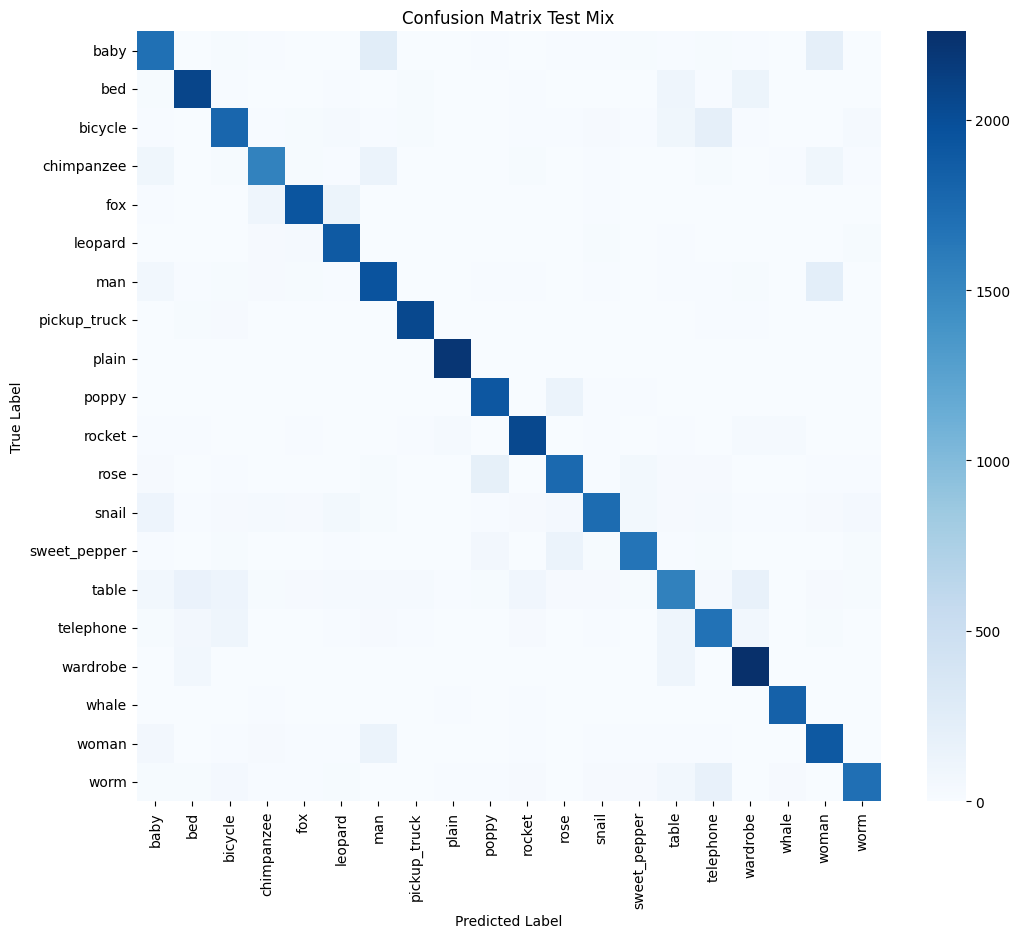

In [12]:
show_conf_matrix(test_targets, test_preds2, idx_cls_test, "Confusion Matrix Test Mix")

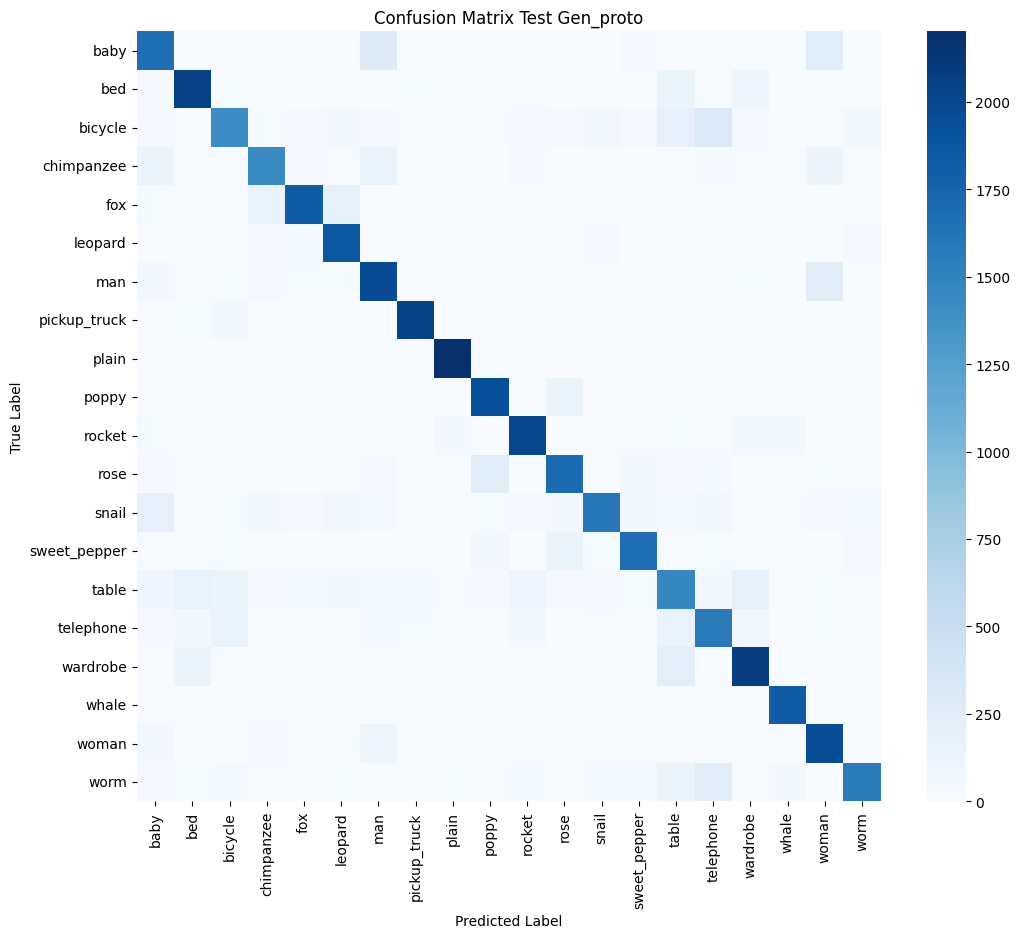

In [9]:
show_conf_matrix(test_targets, test_preds1, idx_cls_test, "Confusion Matrix Test Gen_proto")

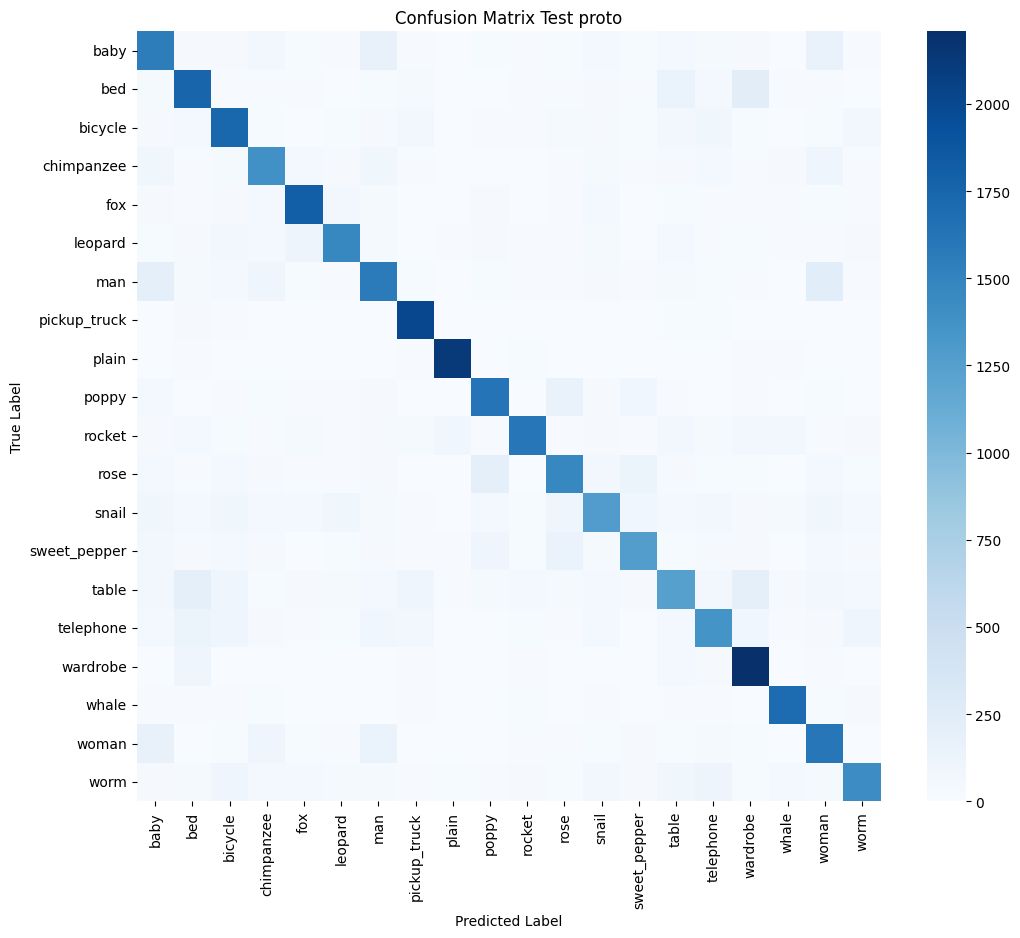

In [10]:
show_conf_matrix(test_targets, test_preds0, idx_cls_test, "Confusion Matrix Test proto")

2025-04-02 14:18:22,913 - <ipython-input-7-6d01d16d129e>[line:4] - INFO: {}
2025-04-02 14:18:22,913 - <ipython-input-7-6d01d16d129e>[line:4] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-6-067e0c8ab1bf>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

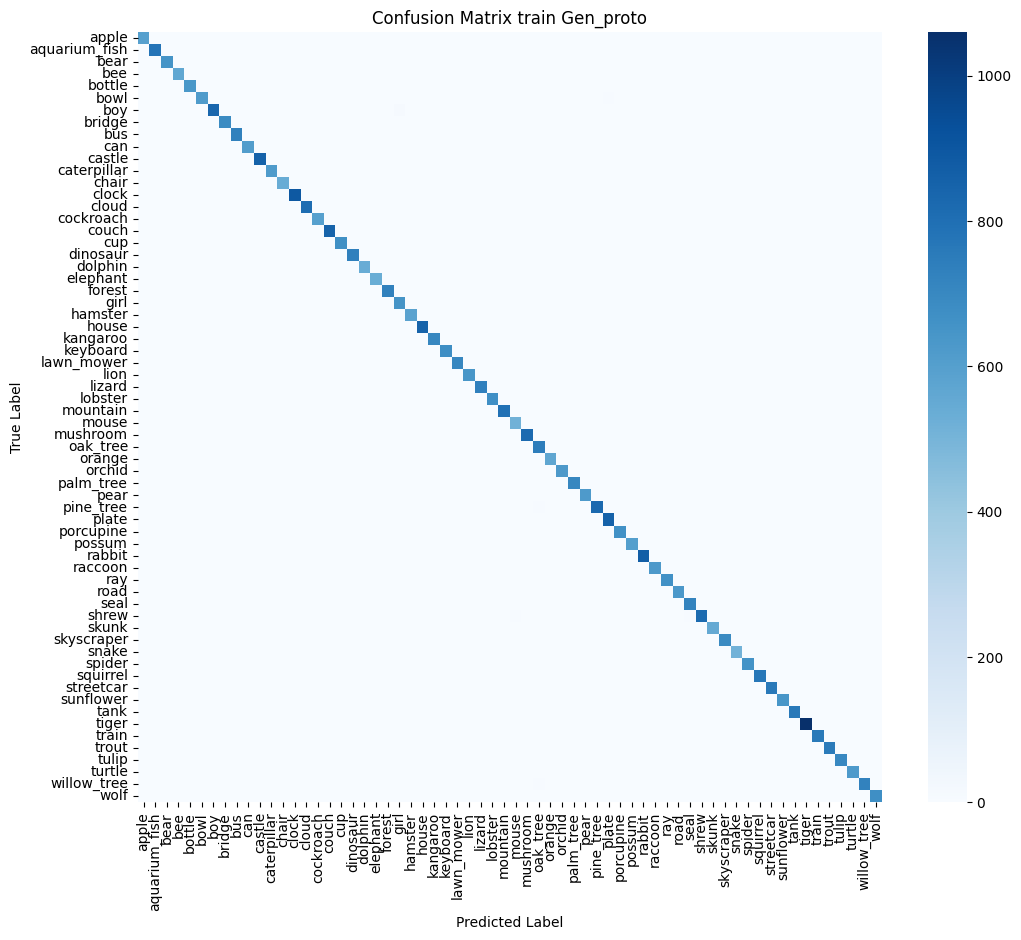

In [11]:
train_data, train_preds0, train_preds1, train_preds2, train_targets, idx_cls_train = predict_all(split='train')
show_conf_matrix(train_targets, train_preds1, idx_cls_train, "Confusion Matrix train Gen_proto")

2025-04-02 14:19:39,125 - <ipython-input-7-6d01d16d129e>[line:4] - INFO: {}
2025-04-02 14:19:39,125 - <ipython-input-7-6d01d16d129e>[line:4] - INFO: {}
2025-04-02 14:19:39,125 - <ipython-input-7-6d01d16d129e>[line:4] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-6-067e0c8ab1bf>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/py

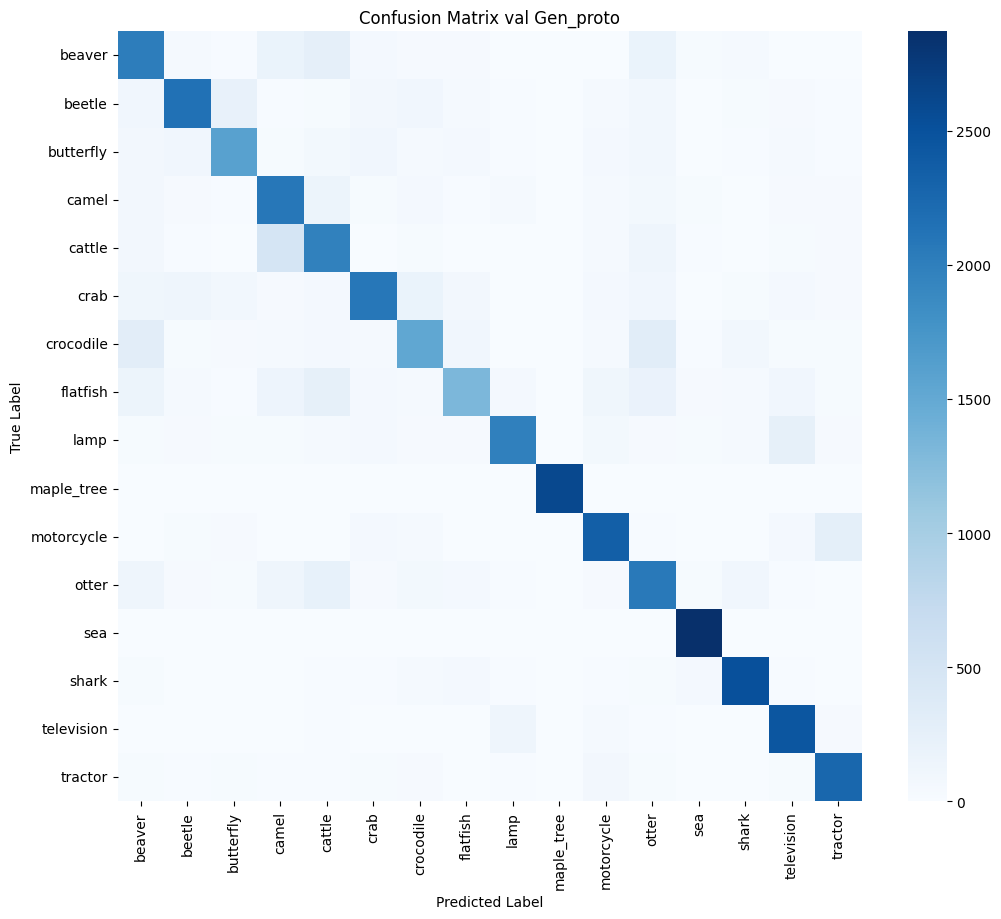

In [12]:
val_data, val_preds0, val_preds1, val_preds2, val_targets, idx_cls_val = predict_all(split='val')
show_conf_matrix(val_targets, val_preds1, idx_cls_val, "Confusion Matrix val Gen_proto")

## Cluster from CM

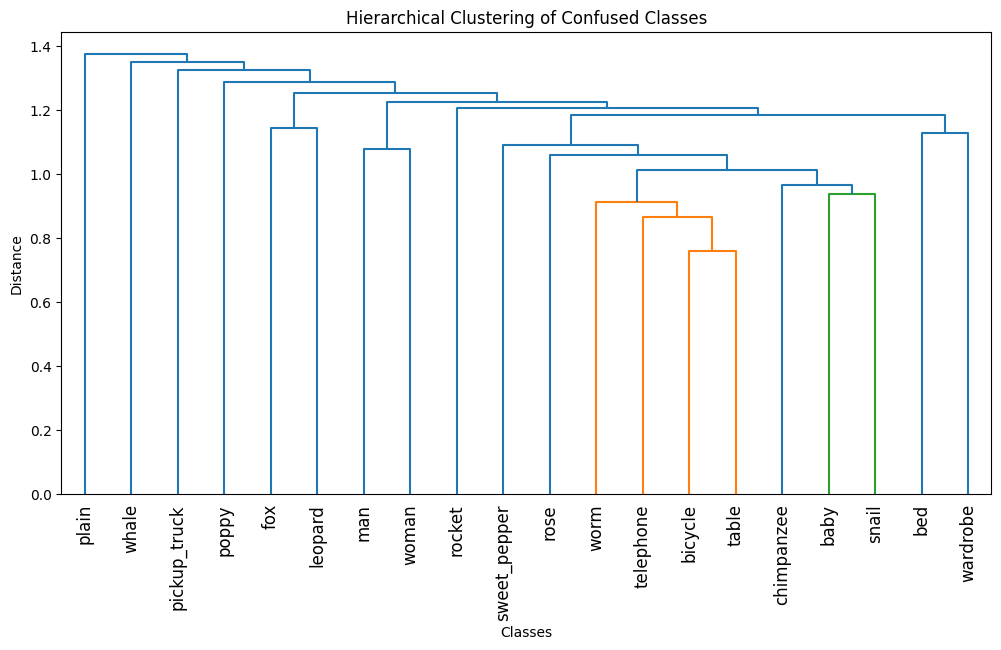

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram

def hierarchical_clustering(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # Normalize

    linkage_matrix = linkage(1-cm, method="complete")  # Ward's method for minimal variance
    
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, labels=list(class_names.values()), leaf_rotation=90)
    plt.title("Hierarchical Clustering of Confused Classes")
    plt.xlabel("Classes")
    plt.ylabel("Distance")
    plt.show()

hierarchical_clustering(test_targets, test_preds1, idx_cls_test)


In [26]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import squareform, pdist

def cluster_cm_dbscan(y_true, y_pred, class_names, eps=0.5, min_samples=2):
    """
    Perform DBSCAN clustering on the confusion matrix and visualize clusters.
        eps (float): The maximum distance between two samples for them to be considered in the same cluster.
        min_samples (int): Minimum number of samples in a neighborhood for a class to be considered a core point.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True) # Normalize

    # Convert confusion matrix to a distance matrix
    dist_matrix = squareform(pdist(cm_norm, metric='cosine'))

    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dist_matrix)
    
    cluster_labels = clustering.labels_
    unique_clusters = set(cluster_labels)
    print(f"Identified {len(unique_clusters) - (1 if -1 in unique_clusters else 0)} clusters (DBSCAN)")
    
    for cluster in unique_clusters:
        if cluster == -1:
            print("\n❌ Outliers (Not in any cluster):")
        else:
            print(f"\n🔹 Cluster {cluster}:")
        print([class_names[i] for i, label in enumerate(cluster_labels) if label == cluster])

cluster_cm_dbscan(test_targets, test_preds1, idx_cls_test, eps=0.85, min_samples=2)


Identified 3 clusters (DBSCAN)

🔹 Cluster 0:
['baby', 'man', 'woman']

🔹 Cluster 1:
['bed', 'bicycle', 'table', 'telephone', 'wardrobe', 'worm']

🔹 Cluster 2:
['poppy', 'rose']

❌ Outliers (Not in any cluster):
['chimpanzee', 'fox', 'leopard', 'pickup_truck', 'plain', 'rocket', 'snail', 'sweet_pepper', 'whale']


In [23]:
from sklearn.cluster import KMeans

def kmeans_clustering(y_true, y_pred, class_names, k=5):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=k, random_state=42).fit(cm)
    labels = kmeans.labels_

    print("Cluster assignments:")
    for cluster in set(labels):
        print(f"Cluster {cluster}: {[class_names[i] for i, label in enumerate(labels) if label == cluster]}")

kmeans_clustering(test_targets, test_preds1, idx_cls_test, k=5)

Cluster assignments:
Cluster 0: ['baby', 'chimpanzee', 'man', 'woman']
Cluster 1: ['whale']
Cluster 2: ['plain']
Cluster 3: ['bed', 'bicycle', 'fox', 'leopard', 'poppy', 'rocket', 'rose', 'snail', 'sweet_pepper', 'table', 'telephone', 'wardrobe', 'worm']
Cluster 4: ['pickup_truck']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Other metrics

In [13]:
print(set(test_targets))
print(set(test_preds1))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, cohen_kappa_score, \
    matthews_corrcoef, roc_auc_score, balanced_accuracy_score, classification_report

# Function to compute metrics and return a dictionary of results
def compute_metrics(y_true, y_pred, idx_cls, verbose=True):

    y_true = [idx_cls[y] for y in y_true]
    y_pred = [idx_cls[y] for y in y_pred]
    metrics = {}
    
    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)

    # Balanced Accuracy
    metrics['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    metrics['Precision'] = precision
    metrics['Recall'] = recall
    metrics['F1-Score'] = f1
    
    # Cohen’s Kappa
    metrics['Cohens Kappa'] = cohen_kappa_score(y_true, y_pred)
    
    # Matthews Correlation Coefficient (MCC)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    
    # ROC-AUC Score (for multi-class problems, use 'ovr' method)
    #metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred, multi_class='ovr', average='weighted', labels=np.unique(y_true))

    if verbose:
        print(f"Accuracy: {metrics['Accuracy']}")
        print(f"Balanced Accuracy: {metrics['Balanced Accuracy']}")
        print(f"Precision: {metrics['Precision']}")
        print(f"Recall: {metrics['Recall']}")
        print(f"F1-Score: {metrics['F1-Score']}")
        print(f"Cohens Kappa: {metrics['Cohens Kappa']}")
        print(f"MCC: {metrics['MCC']}")
    
    # Classification Report
    class_report = classification_report(y_true, y_pred, output_dict=True)
    metrics['Classification Report'] = class_report

    if verbose:
        print(classification_report(y_true, y_pred))
    
    return metrics

In [15]:
metrics_test = compute_metrics(test_targets, test_preds2, idx_cls_test)

Accuracy: 0.8271555555555555
Balanced Accuracy: 0.8303625569002433
Precision: 0.8276433509372403
Recall: 0.8271555555555555
F1-Score: 0.8259265720110435
Cohens Kappa: 0.8180165545194529
MCC: 0.8181739304589889
              precision    recall  f1-score   support

        baby       0.74      0.73      0.73      2325
         bed       0.83      0.85      0.84      2445
     bicycle       0.79      0.76      0.77      2355
  chimpanzee       0.82      0.76      0.79      2025
         fox       0.90      0.86      0.88      2250
     leopard       0.83      0.91      0.87      2070
         man       0.74      0.79      0.76      2460
pickup_truck       0.94      0.96      0.95      2145
       plain       0.95      0.99      0.97      2220
       poppy       0.84      0.91      0.87      2115
      rocket       0.87      0.89      0.88      2295
        rose       0.81      0.80      0.81      2205
       snail       0.87      0.73      0.79      2385
sweet_pepper       0.86      0.82

In [16]:
metrics_test = compute_metrics(test_targets, test_preds1, idx_cls_test)

Accuracy: 0.7974444444444444
Balanced Accuracy: 0.8014808623676661
Precision: 0.7989819825242929
Recall: 0.7974444444444444
F1-Score: 0.7956785632412154
Cohens Kappa: 0.7867368475185773
MCC: 0.7869932499238351
              precision    recall  f1-score   support

        baby       0.69      0.72      0.71      2325
         bed       0.81      0.84      0.82      2445
     bicycle       0.73      0.60      0.66      2355
  chimpanzee       0.79      0.71      0.75      2025
         fox       0.88      0.81      0.85      2250
     leopard       0.79      0.90      0.84      2070
         man       0.73      0.80      0.76      2460
pickup_truck       0.94      0.95      0.95      2145
       plain       0.94      0.99      0.96      2220
       poppy       0.82      0.92      0.87      2115
      rocket       0.84      0.87      0.86      2295
        rose       0.80      0.77      0.79      2205
       snail       0.85      0.67      0.75      2385
sweet_pepper       0.85      0.82

In [58]:
metrics_test = compute_metrics(test_targets, test_preds0, idx_cls_test)

Accuracy: 0.7158888888888889
Balanced Accuracy: 0.7189071403695578
Precision: 0.71562755418956
Recall: 0.7158888888888889
F1-Score: 0.7130653593757249
Cohens Kappa: 0.7008569179959393
MCC: 0.7011456329530737
              precision    recall  f1-score   support

        baby       0.60      0.67      0.63      2325
         bed       0.68      0.72      0.70      2445
     bicycle       0.68      0.74      0.71      2355
  chimpanzee       0.66      0.68      0.67      2025
         fox       0.79      0.80      0.79      2250
     leopard       0.77      0.71      0.74      2070
         man       0.64      0.64      0.64      2460
pickup_truck       0.81      0.94      0.87      2145
       plain       0.92      0.96      0.94      2220
       poppy       0.74      0.77      0.75      2115
      rocket       0.84      0.70      0.76      2295
        rose       0.70      0.67      0.68      2205
       snail       0.67      0.54      0.60      2385
sweet_pepper       0.72      0.63  

In [50]:
metrics_train = compute_metrics(train_targets, train_preds1, idx_cls_train)

Accuracy: 0.9919333333333333
Balanced Accuracy: 0.9919136026760274
Precision: 0.991984280889695
Recall: 0.9919333333333333
F1-Score: 0.991935663479942
Cohens Kappa: 0.9918022817554556
MCC: 0.9918030094461079
               precision    recall  f1-score   support

        apple       0.99      1.00      1.00       600
aquarium_fish       0.99      1.00      1.00       780
         bear       0.98      0.99      0.98       660
          bee       0.99      0.99      0.99       570
       bottle       1.00      0.99      0.99       645
         bowl       0.98      0.98      0.98       630
          boy       0.99      0.98      0.99       855
       bridge       1.00      1.00      1.00       690
          bus       1.00      0.99      1.00       735
          can       1.00      0.99      0.99       615
       castle       1.00      1.00      1.00       855
  caterpillar       0.99      0.99      0.99       630
        chair       1.00      1.00      1.00       540
        clock       1

In [51]:
metrics_val = compute_metrics(val_targets, val_preds1, idx_cls_val)


Accuracy: 0.7525777777777778
Balanced Accuracy: 0.7525799209985531
Precision: 0.7548768391820699
Recall: 0.7525777777777778
F1-Score: 0.7504353896414654
Cohens Kappa: 0.7359827005355919
MCC: 0.7364018977533483
              precision    recall  f1-score   support

      beaver       0.63      0.68      0.66      2970
      beetle       0.79      0.72      0.75      2985
   butterfly       0.74      0.67      0.71      2370
       camel       0.64      0.75      0.69      2760
      cattle       0.61      0.68      0.64      2910
        crab       0.77      0.67      0.72      3090
   crocodile       0.66      0.56      0.61      2730
    flatfish       0.72      0.50      0.59      2655
        lamp       0.85      0.72      0.78      2790
  maple_tree       0.98      0.98      0.98      2655
  motorcycle       0.77      0.81      0.79      2910
       otter       0.61      0.68      0.64      3030
         sea       0.91      0.98      0.95      2925
       shark       0.85      0.88

# Visualize errors

In [59]:
import matplotlib.pyplot as plt
import random
import torch

# Function to find top confused classes from a confusion matrix
def top_confused_classes(y_true, y_pred, idx_cls, num_top=10):

    y_true_named = [idx_cls[y] for y in y_true]
    y_pred_named = [idx_cls[y] for y in y_pred]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_named, y_pred_named, labels=list(idx_cls.values()))
    
    misclassified_pairs = []
    for i, true_class in enumerate(idx_cls.values()):
        for j, pred_class in enumerate(idx_cls.values()):
            if i != j and cm[i, j] > 0:  # Ignore diagonal (correct classifications)
                misclassified_pairs.append((true_class, pred_class, cm[i, j]))  # (true class, predicted class, count)

    sorted_misclassifications = sorted(misclassified_pairs, key=lambda x: x[2], reverse=True)
    top_confused = sorted_misclassifications[:num_top]
    return top_confused

def denormalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    mean = torch.tensor(mean).view(3, 1, 1)  # Reshape mean for broadcasting
    std = torch.tensor(std).view(3, 1, 1)    # Reshape std for broadcasting
    image = image * std + mean  # Reverse normalization
    return torch.clamp(image, 0, 1)  # Ensure values are in [0,1]

# Function to plot a single image with labels
def plot_image(image, true_label, predicted_label):
    image = denormalize(image)
    plt.imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis("off")
    plt.show()

# Function to plot 10 random images of a specific misclassification
def plot_misclassified_images(data, y_real, y_pred, idx_cls, true_class, predicted_class, num_images=10):
    # Convert class names to their corresponding indices
    true_class_idx = [k for k, v in idx_cls.items() if v == true_class][0]
    predicted_class_idx = [k for k, v in idx_cls.items() if v == predicted_class][0]

    # Find indices of misclassified images
    misclassified_indices = [i for i in range(len(y_real)) if y_real[i] == true_class_idx and y_pred[i] == predicted_class_idx]

    # If there are no misclassified images, print a message and return
    if len(misclassified_indices) == 0:
        print(f"No images found where '{true_class}' was misclassified as '{predicted_class}'.")
        return

    # Randomly select up to `num_images` from the misclassified indices
    selected_indices = random.sample(misclassified_indices, min(num_images, len(misclassified_indices)))

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, num_images, i + 1)
        image = denormalize(data[idx])  # Denormalize image
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Convert (C, H, W) to (H, W, C)
        plt.title(f"True: {true_class}\nPred: {predicted_class}", fontsize=8)
        plt.axis("off")
    plt.show()

In [60]:
top_20_confused = top_confused_classes(test_targets, test_preds1, idx_cls_test, num_top=20)

confused_df = pd.DataFrame(top_20_confused, columns=['True Class', 'Predicted Class', 'Misclassifications'])
confused_df

True Class Predicted Class  Misclassifications
0        bicycle       telephone                 301
1           baby             man                 277
2           baby           woman                 246
3           rose           poppy                 245
4           worm       telephone                 239
5            man           woman                 236
6       wardrobe           table                 228
7            fox         leopard                 192
8          snail            baby                 183
9        bicycle           table                 182
10         table        wardrobe                 170
11         table             bed                 158
12     telephone         bicycle                 151
13    chimpanzee             man                 148
14           fox      chimpanzee                 148
15     telephone           table                 142
16  sweet_pepper            rose                 137
17    chimpanzee            baby                 135
18         table         bicycle                 130
19         poppy            rose                 128

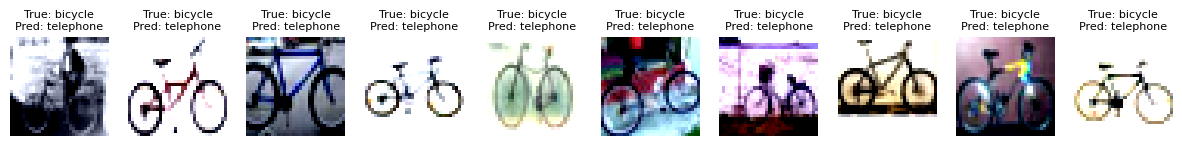

In [61]:
true_class = "bicycle"
predicted_class = "telephone"
plot_misclassified_images(test_data, test_targets, test_preds1, idx_cls_test, true_class, predicted_class, num_images=10)

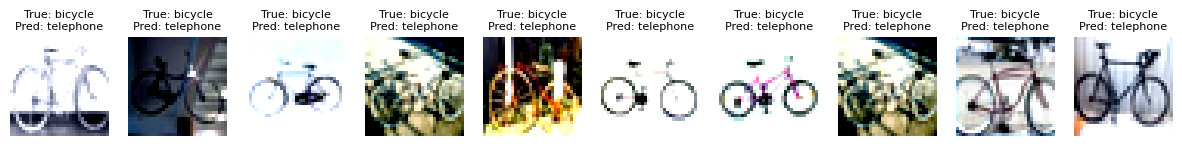

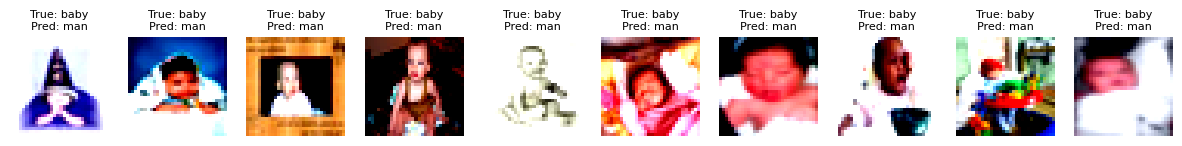

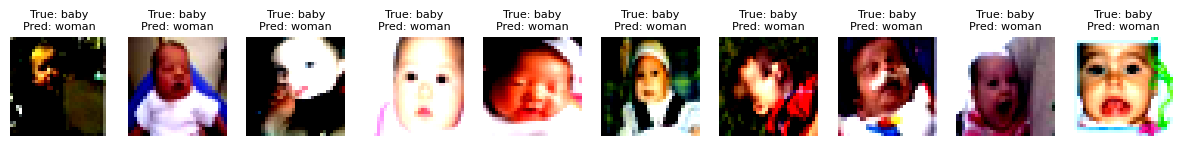

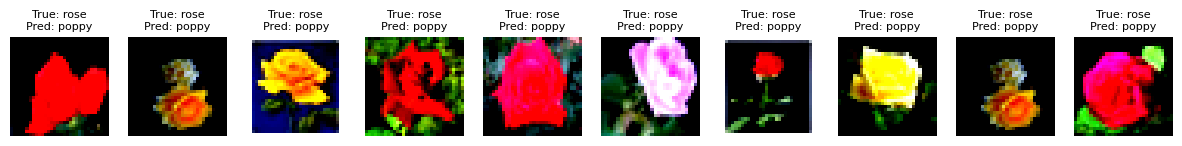

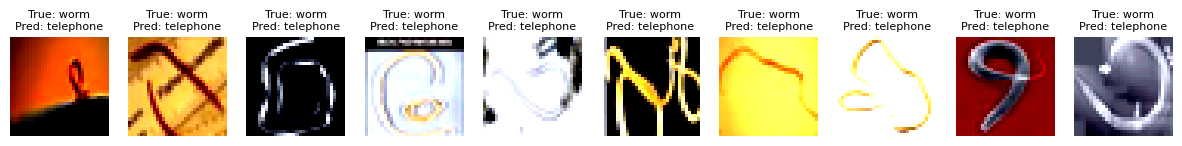

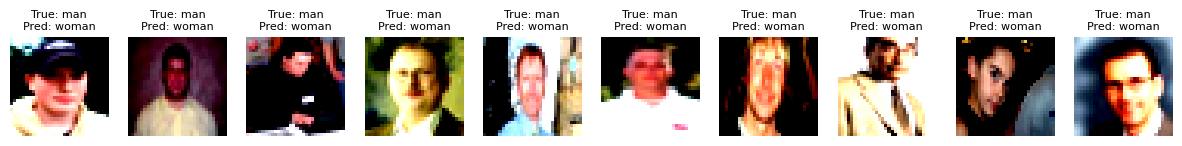

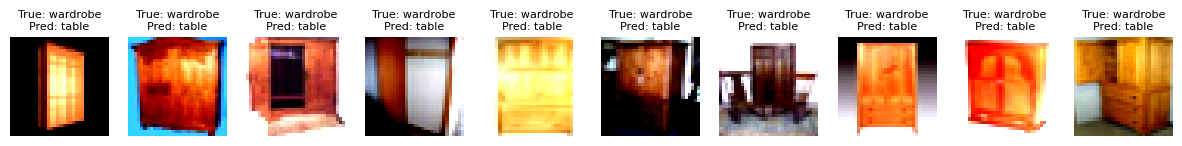

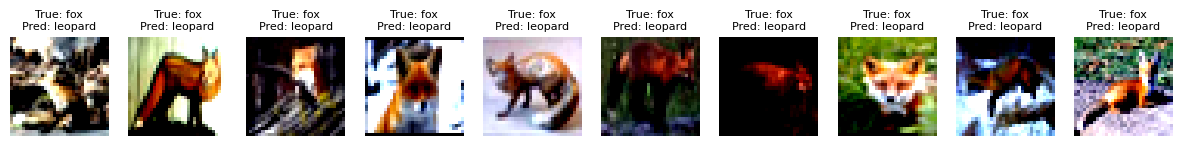

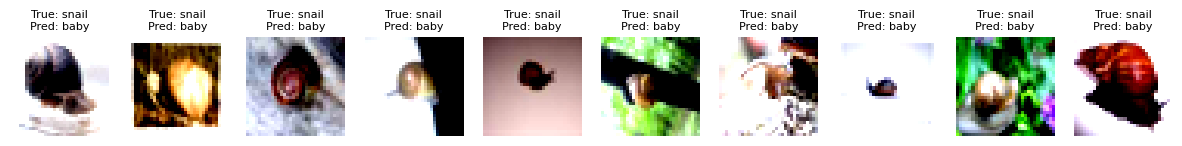

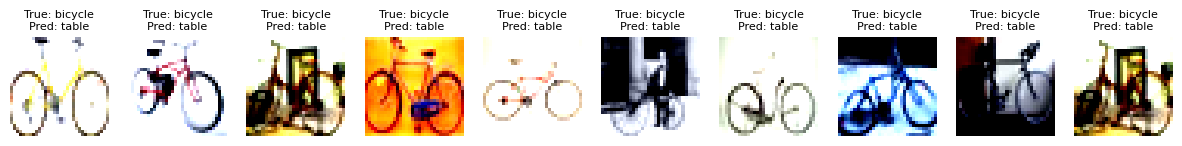

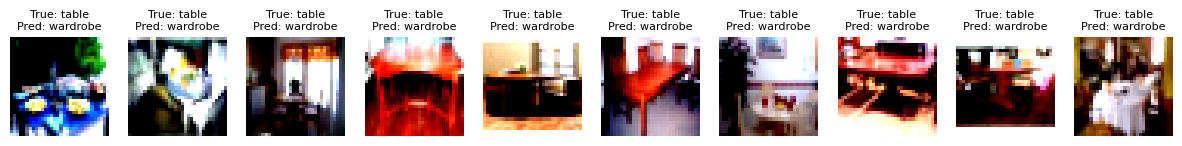

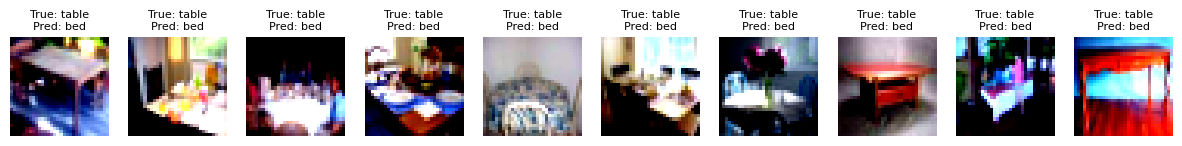

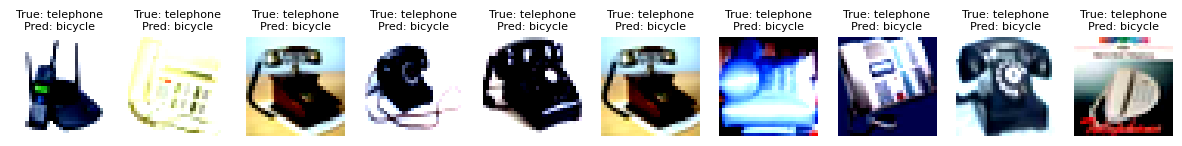

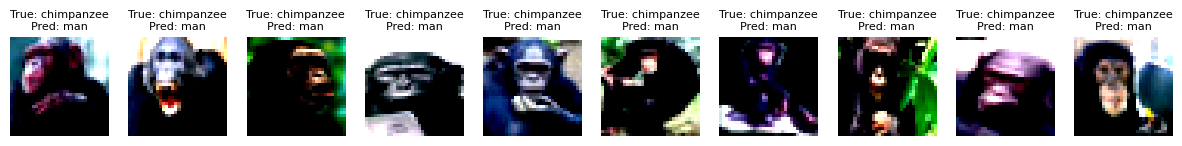

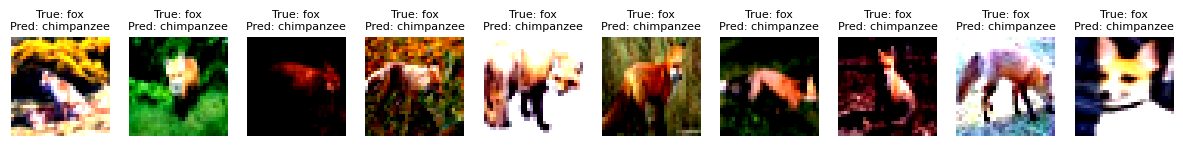

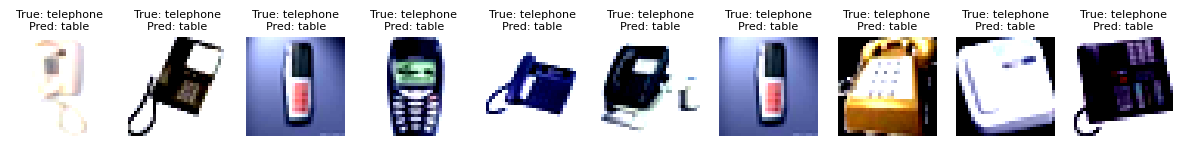

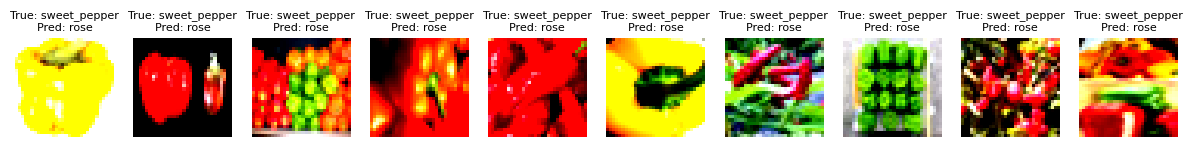

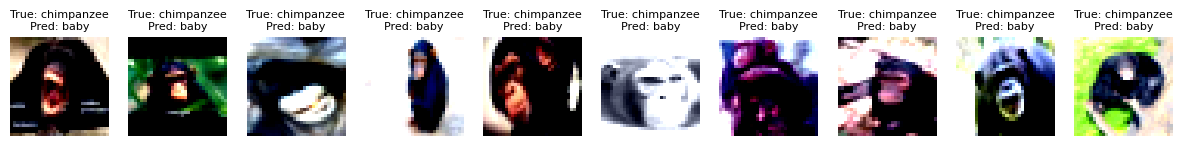

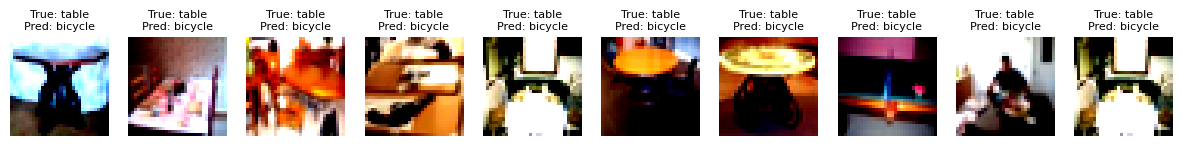

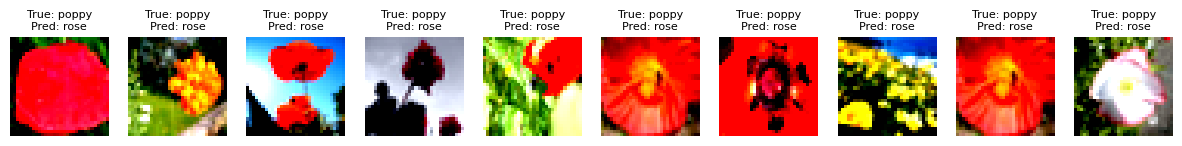

In [64]:
for true, pred, _ in top_20_confused:
    plot_misclassified_images(test_data, test_targets, test_preds1, idx_cls_test, true, pred, num_images=10)

In [53]:
top_20_confused = top_confused_classes(train_targets, train_preds1, idx_cls_train, num_top=20)

confused_df = pd.DataFrame(top_20_confused, columns=['True Class', 'Predicted Class', 'Misclassifications'])
confused_df

True Class Predicted Class  Misclassifications
0           boy            girl                  14
1          bowl           plate                   8
2     pine_tree        oak_tree                   7
3         shrew            seal                   7
4   willow_tree        oak_tree                   7
5         shrew           mouse                   6
6           can            bowl                   4
7        forest        mountain                   4
8          girl             boy                   4
9       raccoon           shrew                   4
10        shrew          lizard                   4
11         bear            seal                   3
12         bowl          orange                   3
13          bus       streetcar                   3
14          cup            bowl                   3
15     dinosaur           train                   3
16        house          castle                   3
17         pear           apple                   3
18    porcupine          lizard                   3
19       possum       porcupine                   3

In [54]:
top_20_confused = top_confused_classes(val_targets, val_preds1, idx_cls_val, num_top=20)

confused_df = pd.DataFrame(top_20_confused, columns=['True Class', 'Predicted Class', 'Misclassifications'])
confused_df

True Class Predicted Class  Misclassifications
0       cattle           camel                 500
1    crocodile           otter                 325
2    crocodile          beaver                 309
3   motorcycle         tractor                 270
4       beaver          cattle                 269
5         lamp      television                 256
6     flatfish          cattle                 247
7        otter          cattle                 235
8       beetle       butterfly                 219
9     flatfish           otter                 196
10      beaver           otter                 190
11      beaver           camel                 185
12        crab       crocodile                 182
13    flatfish          beaver                 166
14       camel          cattle                 157
15    flatfish           camel                 149
16  television            lamp                 138
17       otter           camel                 133
18        crab          beetle                 132
19       otter          beaver                 132

In [57]:
len(test_preds1)

45000

# Train with semantics

In [15]:
!pip install open_clip_torch torchvision pandas tqdm groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


## Groq with images

In [7]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,
    "project": "SemFew_recreate",
    "run_name": "kaggle",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "groq",
    "semantics_from": "images",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
from method.train import train

train(args)

SyntaxError: invalid syntax (semantic.py, line 83)

In [ ]:
from method.test import test

test(args)

## Just class names

In [10]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,
    "project": "SemFew_recreate",
    "run_name": "kaggle",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "names",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
from method.train import train

train(args)

2025-05-23 16:25:12,489 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

96

🔹 APPLE:
apple


🔹 AQUARIUM_FISH:
aquarium_fish


🔹 BEAR:
bear


🔹 BEE:
bee


🔹 BOTTLE:
bottle


🔹 BOWL:
bowl


🔹 BOY:
boy


🔹 BRIDGE:
bridge


🔹 BUS:
bus


🔹 CAN:
can


🔹 CASTLE:
castle


🔹 CATERPILLAR:
caterpillar


🔹 CHAIR:
chair


🔹 CLOCK:
clock


🔹 CLOUD:
cloud


🔹 COCKROACH:
cockroach


🔹 COUCH:
couch


🔹 CUP:
cup


🔹 DINOSAUR:
dinosaur


🔹 DOLPHIN:
dolphin


🔹 ELEPHANT:
elephant


🔹 FOREST:
forest


🔹 GIRL:
girl


🔹 HAMSTER:
hamster


🔹 HOUSE:
house


🔹 KANGAROO:
kangaroo


🔹 KEYBOARD:
keyboard


🔹 LAWN_MOWER:
lawn_mower


🔹 LION:
lion


🔹 LIZARD:
lizard


🔹 LOBSTER:
lobster


🔹 MOUNTAIN:
mountain


🔹 MOUSE:
mouse


🔹 MUSHROOM:
mushroom


🔹 OAK_TREE:
oak_tree


🔹 ORANGE:
orange


🔹 ORCHID:
orchid


🔹 PALM_TREE:
palm_tree


🔹 PEAR:
pear


🔹 PINE_TREE:
pine_tree


🔹 PLATE:
plate


🔹 PORCUPINE:
porcupine


🔹 POSSUM:
possum


🔹 RABBIT:
rabbit


🔹 RACCOON:
raccoon


🔹 RAY:
ray


🔹 ROAD:
road


🔹 SEAL:
seal


🔹 SHREW:
shrew


🔹 SKUNK:
skunk


🔹 SKYSCRAPER:
skyscraper


🔹 SNAKE:
sn

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-05-23 16:26:24,591 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:16<00:00, 18.16it/s]
2025-05-23 16:26:41,937 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.125323] 
100%|██████████| 600/600 [00:40<00:00, 14.92it/s]
2025-05-23 16:27:22,223 - train.py[line:226] - INFO: best epoch: 0
2025-05-23 16:27:22,228 - train.py[line:231] - INFO: epoch: 0 |origin acc: 63.59+0.95% |complete acc: 69.56+0.93% |gap: 5.98/5.98 |k: 0.0
2025-05-23 16:27:22,229 - train.py[line:235] - INFO: ACC |proto acc: 63.59+0.95% |gen acc: 69.56+0.93% |Max: 69.56


save 0


100%|██████████| 301/301 [00:10<00:00, 27.42it/s]
2025-05-23 16:27:33,213 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.065420] 
100%|██████████| 600/600 [00:39<00:00, 15.19it/s]
2025-05-23 16:28:12,812 - train.py[line:226] - INFO: best epoch: 1
2025-05-23 16:28:12,816 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.48+1.00% |complete acc: 73.92+0.83% |gap: 10.44/10.44 |k: 0.0
2025-05-23 16:28:12,818 - train.py[line:235] - INFO: ACC |proto acc: 63.48+1.00% |gen acc: 73.92+0.83% |Max: 73.92


save 1


100%|██████████| 301/301 [00:11<00:00, 26.03it/s]
2025-05-23 16:28:24,387 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.043535] 
100%|██████████| 600/600 [00:39<00:00, 15.31it/s]
2025-05-23 16:29:03,671 - train.py[line:226] - INFO: best epoch: 2
2025-05-23 16:29:03,675 - train.py[line:231] - INFO: epoch: 2 |origin acc: 63.24+0.97% |complete acc: 75.34+0.76% |gap: 12.09/12.09 |k: 0.09
2025-05-23 16:29:03,677 - train.py[line:235] - INFO: ACC |proto acc: 63.24+0.97% |gen acc: 75.00+0.76% |Max: 75.34


save 2


100%|██████████| 301/301 [00:12<00:00, 24.80it/s]
2025-05-23 16:29:15,821 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.031283] 
100%|██████████| 600/600 [00:39<00:00, 15.22it/s]
2025-05-23 16:29:55,274 - train.py[line:231] - INFO: epoch: 3 |origin acc: 61.74+0.96% |complete acc: 75.33+0.72% |gap: 13.60/13.60 |k: 0.11
2025-05-23 16:29:55,276 - train.py[line:235] - INFO: ACC |proto acc: 61.74+0.96% |gen acc: 74.52+0.72% |Max: 75.34
100%|██████████| 301/301 [00:11<00:00, 26.14it/s]
2025-05-23 16:30:06,798 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.023884] 
100%|██████████| 600/600 [00:39<00:00, 15.02it/s]
2025-05-23 16:30:46,834 - train.py[line:226] - INFO: best epoch: 4
2025-05-23 16:30:46,837 - train.py[line:231] - INFO: epoch: 4 |origin acc: 63.19+0.98% |complete acc: 76.06+0.75% |gap: 13.60/12.87 |k: 0.14
2025-05-23 16:30:46,839 - train.py[line:235] - INFO: ACC |proto acc: 63.19+0.98% |gen acc: 74.57+0.77% |Max: 76.06


save 4


100%|██████████| 301/301 [00:12<00:00, 23.68it/s]
2025-05-23 16:30:59,558 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.018950] 
100%|██████████| 600/600 [00:39<00:00, 15.22it/s]
2025-05-23 16:31:39,007 - train.py[line:231] - INFO: epoch: 5 |origin acc: 62.60+0.93% |complete acc: 75.42+0.74% |gap: 13.60/12.82 |k: 0.16
2025-05-23 16:31:39,008 - train.py[line:235] - INFO: ACC |proto acc: 62.60+0.93% |gen acc: 73.24+0.79% |Max: 76.06
100%|██████████| 301/301 [00:22<00:00, 13.41it/s]
2025-05-23 16:32:01,458 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.014116] 
100%|██████████| 600/600 [00:39<00:00, 15.21it/s]
2025-05-23 16:32:40,935 - train.py[line:231] - INFO: epoch: 6 |origin acc: 62.58+0.97% |complete acc: 75.18+0.77% |gap: 13.60/12.59 |k: 0.2
2025-05-23 16:32:40,937 - train.py[line:235] - INFO: ACC |proto acc: 62.58+0.97% |gen acc: 72.95+0.77% |Max: 76.06
100%|██████████| 301/301 [00:10<00:00, 27.59it/s]
2025-05-23 16:32:51,851 - train.py[line:162] - INFO: [Epoch

ResNet(
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsample): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (DropBlock): DropBlock()
    )
  )
  (lay

In [12]:
from method.test import test

test(args)

2025-05-23 17:10:26,000 - test.py[line:28] - INFO: {}
2025-05-23 17:10:26,000 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

96


2025-05-23 17:11:10,366 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-23 17:11:10,366 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:18<00:00, 33.12it/s]
2025-05-23 17:11:29,057 - test.py[line:130] - INFO: max |k:             0.07 |mix acc: 63.58+1.03% |gap: -8.97
2025-05-23 17:11:29,057 - test.py[line:130] - INFO: max |k:             0.07 |mix acc: 63.58+1.03% |gap: -8.97
2025-05-23 17:11:29,059 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 56.02+1.12%
2025-05-23 17:11:29,059 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 56.02+1.12%


## Just names 5

In [10]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,
    "project": "SemFew_recreate",
    "run_name": "5-shot_names",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "names",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 40,
    "test_batch": 300,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


2025-06-29 16:48:50,625 - train.py[line:54] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/train.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.

96


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-06-29 16:49:20,884 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


class_encodings_default_names_None.json

🔹 APPLE:
apple


🔹 AQUARIUM_FISH:
aquarium_fish


🔹 BEAR:
bear


🔹 BEE:
bee


🔹 BOTTLE:
bottle


🔹 BOWL:
bowl


🔹 BOY:
boy


🔹 BRIDGE:
bridge


🔹 BUS:
bus


🔹 CAN:
can


🔹 CASTLE:
castle


🔹 CATERPILLAR:
caterpillar


🔹 CHAIR:
chair


🔹 CLOCK:
clock


🔹 CLOUD:
cloud


🔹 COCKROACH:
cockroach


🔹 COUCH:
couch


🔹 CUP:
cup


🔹 DINOSAUR:
dinosaur


🔹 DOLPHIN:
dolphin


🔹 ELEPHANT:
elephant


🔹 FOREST:
forest


🔹 GIRL:
girl


🔹 HAMSTER:
hamster


🔹 HOUSE:
house


🔹 KANGAROO:
kangaroo


🔹 KEYBOARD:
keyboard


🔹 LAWN_MOWER:
lawn_mower


🔹 LION:
lion


🔹 LIZARD:
lizard


🔹 LOBSTER:
lobster


🔹 MOUNTAIN:
mountain


🔹 MOUSE:
mouse


🔹 MUSHROOM:
mushroom


🔹 OAK_TREE:
oak_tree


🔹 ORANGE:
orange


🔹 ORCHID:
orchid


🔹 PALM_TREE:
palm_tree


🔹 PEAR:
pear


🔹 PINE_TREE:
pine_tree


🔹 PLATE:
plate


🔹 PORCUPINE:
porcupine


🔹 POSSUM:
possum


🔹 RABBIT:
rabbit


🔹 RACCOON:
raccoon


🔹 RAY:
ray


🔹 ROAD:
road


🔹 SEAL:
seal


🔹 SHREW:
shrew


🔹 SKUNK:
skunk


🔹

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-06-29 16:49:25,226 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:11<00:00, 26.63it/s]
2025-06-29 16:49:37,269 - train.py[line:179] - INFO: [Epoch 0/40] [recon loss: 0.114288] 
100%|██████████| 300/300 [00:21<00:00, 14.10it/s]
2025-06-29 16:49:58,620 - train.py[line:247] - INFO: best epoch: 0
2025-06-29 16:49:58,625 - train.py[line:252] - INFO: epoch: 0 |origin acc: 78.81+0.91% |complete acc: 80.00+0.88% |gap: 1.20/1.20 |k: 0.28
2025-06-29 16:49:58,626 - train.py[line:256] - INFO: ACC |proto acc: 78.81+0.91% |gen acc: 79.33+0.92% |Max: 80.00


save 0


100%|██████████| 301/301 [00:10<00:00, 27.48it/s]
2025-06-29 16:50:09,587 - train.py[line:179] - INFO: [Epoch 1/40] [recon loss: 0.068141] 
100%|██████████| 300/300 [00:20<00:00, 14.68it/s]
2025-06-29 16:50:30,035 - train.py[line:252] - INFO: epoch: 1 |origin acc: 77.60+1.03% |complete acc: 79.68+0.94% |gap: 2.08/2.08 |k: 0.35000000000000003
2025-06-29 16:50:30,036 - train.py[line:256] - INFO: ACC |proto acc: 77.60+1.03% |gen acc: 78.00+0.99% |Max: 80.00
100%|██████████| 301/301 [00:10<00:00, 27.71it/s]
2025-06-29 16:50:40,903 - train.py[line:179] - INFO: [Epoch 2/40] [recon loss: 0.055494] 
100%|██████████| 300/300 [00:20<00:00, 14.71it/s]
2025-06-29 16:51:01,399 - train.py[line:247] - INFO: best epoch: 2
2025-06-29 16:51:01,403 - train.py[line:252] - INFO: epoch: 2 |origin acc: 78.22+1.04% |complete acc: 80.54+0.95% |gap: 2.32/2.32 |k: 0.46
2025-06-29 16:51:01,404 - train.py[line:256] - INFO: ACC |proto acc: 78.22+1.04% |gen acc: 77.04+1.07% |Max: 80.54


save 2


100%|██████████| 301/301 [00:11<00:00, 27.35it/s]
2025-06-29 16:51:12,416 - train.py[line:179] - INFO: [Epoch 3/40] [recon loss: 0.034820] 
100%|██████████| 300/300 [00:20<00:00, 14.41it/s]
2025-06-29 16:51:33,322 - train.py[line:247] - INFO: best epoch: 3
2025-06-29 16:51:33,325 - train.py[line:252] - INFO: epoch: 3 |origin acc: 78.89+0.99% |complete acc: 81.13+0.90% |gap: 2.32/2.24 |k: 0.54
2025-06-29 16:51:33,327 - train.py[line:256] - INFO: ACC |proto acc: 78.89+0.99% |gen acc: 76.17+1.08% |Max: 81.13


save 3


100%|██████████| 301/301 [00:11<00:00, 27.34it/s]
2025-06-29 16:51:44,343 - train.py[line:179] - INFO: [Epoch 4/40] [recon loss: 0.024410] 
100%|██████████| 300/300 [00:20<00:00, 14.58it/s]
2025-06-29 16:52:04,931 - train.py[line:252] - INFO: epoch: 4 |origin acc: 79.12+0.94% |complete acc: 81.08+0.87% |gap: 2.32/1.96 |k: 0.53
2025-06-29 16:52:04,933 - train.py[line:256] - INFO: ACC |proto acc: 79.12+0.94% |gen acc: 75.48+1.03% |Max: 81.13
100%|██████████| 301/301 [00:10<00:00, 27.42it/s]
2025-06-29 16:52:15,916 - train.py[line:179] - INFO: [Epoch 5/40] [recon loss: 0.016869] 
100%|██████████| 300/300 [00:20<00:00, 14.70it/s]
2025-06-29 16:52:36,408 - train.py[line:247] - INFO: best epoch: 5
2025-06-29 16:52:36,411 - train.py[line:252] - INFO: epoch: 5 |origin acc: 79.20+1.00% |complete acc: 81.19+0.95% |gap: 2.32/1.99 |k: 0.53
2025-06-29 16:52:36,412 - train.py[line:256] - INFO: ACC |proto acc: 79.20+1.00% |gen acc: 74.65+1.07% |Max: 81.19


save 5


100%|██████████| 301/301 [00:11<00:00, 27.27it/s]
2025-06-29 16:52:47,455 - train.py[line:179] - INFO: [Epoch 6/40] [recon loss: 0.015666] 
100%|██████████| 300/300 [00:20<00:00, 14.79it/s]
2025-06-29 16:53:07,749 - train.py[line:252] - INFO: epoch: 6 |origin acc: 78.51+0.96% |complete acc: 80.11+0.93% |gap: 2.32/1.60 |k: 0.55
2025-06-29 16:53:07,751 - train.py[line:256] - INFO: ACC |proto acc: 78.51+0.96% |gen acc: 73.03+1.12% |Max: 81.19
100%|██████████| 301/301 [00:10<00:00, 27.46it/s]
2025-06-29 16:53:18,719 - train.py[line:179] - INFO: [Epoch 7/40] [recon loss: 0.014368] 
100%|██████████| 300/300 [00:20<00:00, 14.73it/s]
2025-06-29 16:53:39,095 - train.py[line:252] - INFO: epoch: 7 |origin acc: 78.36+1.01% |complete acc: 80.61+0.89% |gap: 2.32/2.25 |k: 0.58
2025-06-29 16:53:39,096 - train.py[line:256] - INFO: ACC |proto acc: 78.36+1.01% |gen acc: 72.38+1.09% |Max: 81.19
100%|██████████| 301/301 [00:10<00:00, 27.49it/s]
2025-06-29 16:53:50,050 - train.py[line:179] - INFO: [Epoch 8/

save 8


100%|██████████| 301/301 [00:10<00:00, 28.26it/s]
2025-06-29 16:54:21,271 - train.py[line:179] - INFO: [Epoch 9/40] [recon loss: 0.011062] 
100%|██████████| 300/300 [00:20<00:00, 14.58it/s]
2025-06-29 16:54:41,856 - train.py[line:252] - INFO: epoch: 9 |origin acc: 78.75+0.97% |complete acc: 80.52+0.94% |gap: 2.32/1.77 |k: 0.67
2025-06-29 16:54:41,857 - train.py[line:256] - INFO: ACC |proto acc: 78.75+0.97% |gen acc: 72.45+1.12% |Max: 81.96
100%|██████████| 301/301 [00:10<00:00, 28.38it/s]
2025-06-29 16:54:52,469 - train.py[line:179] - INFO: [Epoch 10/40] [recon loss: 0.013639] 
100%|██████████| 300/300 [00:20<00:00, 14.56it/s]
2025-06-29 16:55:13,086 - train.py[line:252] - INFO: epoch: 10 |origin acc: 78.68+1.06% |complete acc: 80.91+1.02% |gap: 2.32/2.24 |k: 0.61
2025-06-29 16:55:13,087 - train.py[line:256] - INFO: ACC |proto acc: 78.68+1.06% |gen acc: 72.04+1.22% |Max: 81.96
100%|██████████| 301/301 [00:10<00:00, 28.36it/s]
2025-06-29 16:55:23,706 - train.py[line:179] - INFO: [Epoch 

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [11]:
test(args)

2025-06-29 17:16:03,189 - test.py[line:30] - INFO: {}
2025-06-29 17:16:03,189 - test.py[line:30] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

96


2025-06-29 17:16:40,284 - test.py[line:101] - INFO: best epoch: 8 81.964446
2025-06-29 17:16:40,284 - test.py[line:101] - INFO: best epoch: 8 81.964446
2025-06-29 17:16:40,286 - test.py[line:102] - INFO: best k: 0.580000
2025-06-29 17:16:40,286 - test.py[line:102] - INFO: best k: 0.580000
2025-06-29 17:16:40,289 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-29 17:16:40,289 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


class_encodings_default_names_None.json
{'apple': 'apple', 'aquarium_fish': 'aquarium_fish', 'bear': 'bear', 'bee': 'bee', 'bottle': 'bottle', 'bowl': 'bowl', 'boy': 'boy', 'bridge': 'bridge', 'bus': 'bus', 'can': 'can', 'castle': 'castle', 'caterpillar': 'caterpillar', 'chair': 'chair', 'clock': 'clock', 'cloud': 'cloud', 'cockroach': 'cockroach', 'couch': 'couch', 'cup': 'cup', 'dinosaur': 'dinosaur', 'dolphin': 'dolphin', 'elephant': 'elephant', 'forest': 'forest', 'girl': 'girl', 'hamster': 'hamster', 'house': 'house', 'kangaroo': 'kangaroo', 'keyboard': 'keyboard', 'lawn_mower': 'lawn_mower', 'lion': 'lion', 'lizard': 'lizard', 'lobster': 'lobster', 'mountain': 'mountain', 'mouse': 'mouse', 'mushroom': 'mushroom', 'oak_tree': 'oak_tree', 'orange': 'orange', 'orchid': 'orchid', 'palm_tree': 'palm_tree', 'pear': 'pear', 'pine_tree': 'pine_tree', 'plate': 'plate', 'porcupine': 'porcupine', 'possum': 'possum', 'rabbit': 'rabbit', 'raccoon': 'raccoon', 'ray': 'ray', 'road': 'road', 'se

2025-06-29 17:16:41,911 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-29 17:16:41,911 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 300/300 [00:12<00:00, 23.44it/s]
2025-06-29 17:16:55,272 - test.py[line:150] - INFO: max |k:             0.58 |mix acc: 86.60+0.87% |gap: 0.78
2025-06-29 17:16:55,272 - test.py[line:150] - INFO: max |k:             0.58 |mix acc: 86.60+0.87% |gap: 0.78
2025-06-29 17:16:55,274 - test.py[line:152] - INFO: ACC:|proto acc: 85.82+0.89% |gen acc: 75.31+1.19%
2025-06-29 17:16:55,274 - test.py[line:152] - INFO: ACC:|proto acc: 85.82+0.89% |gen acc: 75.31+1.19%


## WN 5 

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,
    "project": "SemFew_recreate",
    "run_name": "5-shot_wn",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "wordnet",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 40,
    "test_batch": 300,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

## Just descriptions from WordNet

In [13]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,
    "project": "SemFew_recreate",
    "run_name": "kaggle",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "wordnet",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
from method.train import train

train(args)

2025-05-23 17:11:38,178 - train.py[line:51] - INFO: {}
2025-05-23 17:11:38,178 - train.py[line:51] - INFO: {}
2025-05-23 17:11:38,178 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models

96


2025-05-23 17:12:03,651 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-23 17:12:03,651 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-23 17:12:03,651 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:11<00:00, 26.76it/s]
2025-05-23 17:12:15,445 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.074107] 
2025-05-23 17:12:15,445 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.074107] 
2025-05-23 17:12:15,445 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.074107] 
100%|██████████| 600/600 [00:39<00:00, 15.32it/s]
2025-05-23 17:12:54,713 - train.py[line:226] - INFO: best epoch: 0
2025-05-23 17:12:54,713 - train.py[line:226] - INFO: best epoch: 0
2025-05-23 17:12:54,713 - train.py[line:226] - INFO: best epoch: 0
2025-05-23 17:12:54,720 - train.py[line:231] - INFO: epoch: 0 |origin acc: 62.17+0.93% |compl

save 0


100%|██████████| 301/301 [00:11<00:00, 27.08it/s]
2025-05-23 17:13:05,847 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046004] 
2025-05-23 17:13:05,847 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046004] 
2025-05-23 17:13:05,847 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046004] 
100%|██████████| 600/600 [00:39<00:00, 15.10it/s]
2025-05-23 17:13:45,670 - train.py[line:226] - INFO: best epoch: 1
2025-05-23 17:13:45,670 - train.py[line:226] - INFO: best epoch: 1
2025-05-23 17:13:45,670 - train.py[line:226] - INFO: best epoch: 1
2025-05-23 17:13:45,677 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.21+0.99% |complete acc: 70.60+0.87% |gap: 7.39/7.39 |k: 0.1
2025-05-23 17:13:45,677 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.21+0.99% |complete acc: 70.60+0.87% |gap: 7.39/7.39 |k: 0.1
2025-05-23 17:13:45,677 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.21+0.99% |complete acc: 70.60+0.87% |gap: 7.39/7.39 |k: 0.1
2025-05-23 17:1

save 1


100%|██████████| 301/301 [00:12<00:00, 24.85it/s]
2025-05-23 17:13:57,799 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.056343] 
2025-05-23 17:13:57,799 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.056343] 
2025-05-23 17:13:57,799 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.056343] 
100%|██████████| 600/600 [00:39<00:00, 15.16it/s]
2025-05-23 17:14:37,385 - train.py[line:231] - INFO: epoch: 2 |origin acc: 61.28+0.99% |complete acc: 70.31+0.91% |gap: 9.02/9.02 |k: 0.18
2025-05-23 17:14:37,385 - train.py[line:231] - INFO: epoch: 2 |origin acc: 61.28+0.99% |complete acc: 70.31+0.91% |gap: 9.02/9.02 |k: 0.18
2025-05-23 17:14:37,385 - train.py[line:231] - INFO: epoch: 2 |origin acc: 61.28+0.99% |complete acc: 70.31+0.91% |gap: 9.02/9.02 |k: 0.18
2025-05-23 17:14:37,390 - train.py[line:235] - INFO: ACC |proto acc: 61.28+0.99% |gen acc: 67.94+0.96% |Max: 70.60
2025-05-23 17:14:37,390 - train.py[line:235] - INFO: ACC |proto acc: 61.28+0.99% |gen acc: 67.94+0

save 3


100%|██████████| 301/301 [00:11<00:00, 26.25it/s]
2025-05-23 17:15:40,570 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.023106] 
2025-05-23 17:15:40,570 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.023106] 
2025-05-23 17:15:40,570 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.023106] 
100%|██████████| 600/600 [00:39<00:00, 15.22it/s]
2025-05-23 17:16:20,019 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 70.81+0.90% |gap: 9.02/8.52 |k: 0.24
2025-05-23 17:16:20,019 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 70.81+0.90% |gap: 9.02/8.52 |k: 0.24
2025-05-23 17:16:20,019 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 70.81+0.90% |gap: 9.02/8.52 |k: 0.24
2025-05-23 17:16:20,023 - train.py[line:235] - INFO: ACC |proto acc: 62.29+1.00% |gen acc: 64.88+0.96% |Max: 71.68
2025-05-23 17:16:20,023 - train.py[line:235] - INFO: ACC |proto acc: 62.29+1.00% |gen acc: 64.88+0

save 9


100%|██████████| 301/301 [00:11<00:00, 26.68it/s]
2025-05-23 17:21:13,515 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010050] 
2025-05-23 17:21:13,515 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010050] 
2025-05-23 17:21:13,515 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010050] 
100%|██████████| 600/600 [00:39<00:00, 15.16it/s]
2025-05-23 17:21:53,122 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 70.38+0.86% |gap: 9.02/8.18 |k: 0.31
2025-05-23 17:21:53,122 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 70.38+0.86% |gap: 9.02/8.18 |k: 0.31
2025-05-23 17:21:53,122 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 70.38+0.86% |gap: 9.02/8.18 |k: 0.31
2025-05-23 17:21:53,126 - train.py[line:235] - INFO: ACC |proto acc: 62.19+0.95% |gen acc: 61.44+0.97% |Max: 71.97
2025-05-23 17:21:53,126 - train.py[line:235] - INFO: ACC |proto acc: 62.19+0.95% |gen acc: 6

KeyboardInterrupt: 

In [15]:
from method.test import test

test(args)

2025-05-23 17:43:24,113 - test.py[line:28] - INFO: {}
2025-05-23 17:43:24,113 - test.py[line:28] - INFO: {}
2025-05-23 17:43:24,113 - test.py[line:28] - INFO: {}
2025-05-23 17:43:24,113 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case

96


2025-05-23 17:43:41,481 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-23 17:43:41,481 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-23 17:43:41,481 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-23 17:43:41,481 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:12<00:00, 47.53it/s]
2025-05-23 17:43:54,646 - test.py[line:130] - INFO: max |k:             0.07 |mix acc: 60.88+1.03% |gap: -11.67
2025-05-23 17:43:54,646 - test.py[line:130] - INFO: max |k:             0.07 |mix acc: 60.88+1.03% |gap: -11.67
2025-05-23 17:43:54,646 - test.py[line:130] - INFO: max |k:             0.07 |mix acc: 60.88+1.03% |gap: -11.67
2025-05-23 17:43:54,646 - test.py[line:130] - INFO: max |k:             0.07 |mix acc: 60.88+1.03% |gap: -11.67
2025-05-23 17:43:54,650 - test.py[line:132] - INFO: AC

## Groq images SWIN

In [9]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    # wandb
    "project": "SemFew_recreate",
    "run_name": "groq_images_swin",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "groq",
    "semantics_from": "images",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
train(args)

2025-05-27 19:58:54,780 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

183


2025-05-27 19:59:39,835 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ apple: Description generated.


2025-05-27 19:59:40,436 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ aquarium_fish: Description generated.


2025-05-27 19:59:41,259 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bear: Description generated.


2025-05-27 19:59:42,107 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bee: Description generated.


2025-05-27 19:59:42,727 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bottle: Description generated.


2025-05-27 19:59:43,222 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bowl: Description generated.


2025-05-27 19:59:44,028 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ boy: Description generated.


2025-05-27 19:59:44,952 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bridge: Description generated.


2025-05-27 19:59:45,472 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bus: Description generated.


2025-05-27 19:59:45,976 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ can: Description generated.


2025-05-27 19:59:46,832 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ castle: Description generated.


2025-05-27 19:59:47,412 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ caterpillar: Description generated.


2025-05-27 19:59:48,182 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ chair: Description generated.


2025-05-27 19:59:48,738 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ clock: Description generated.


2025-05-27 19:59:49,413 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ cloud: Description generated.


2025-05-27 19:59:50,201 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ cockroach: Description generated.


2025-05-27 19:59:50,721 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ couch: Description generated.


2025-05-27 19:59:51,268 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ cup: Description generated.


2025-05-27 19:59:51,861 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ dinosaur: Description generated.


2025-05-27 19:59:52,628 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ dolphin: Description generated.


2025-05-27 19:59:53,141 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ elephant: Description generated.


2025-05-27 19:59:53,619 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ forest: Description generated.


2025-05-27 19:59:54,371 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ girl: Description generated.


2025-05-27 19:59:55,123 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ hamster: Description generated.


2025-05-27 19:59:55,627 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ house: Description generated.


2025-05-27 19:59:56,263 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ kangaroo: Description generated.


2025-05-27 19:59:56,787 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ keyboard: Description generated.


2025-05-27 19:59:57,312 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ lawn_mower: Description generated.


2025-05-27 19:59:58,108 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ lion: Description generated.


2025-05-27 19:59:58,679 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 19:59:58,726 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 19:59:58,728 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ lizard: Description generated.


2025-05-27 20:00:01,275 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:01,320 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:01,321 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ lobster: Description generated.


2025-05-27 20:00:03,886 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:03,933 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:03,935 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ mountain: Description generated.


2025-05-27 20:00:06,490 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:06,535 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:06,537 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ mouse: Description generated.


2025-05-27 20:00:09,284 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:09,346 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:09,347 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ mushroom: Description generated.


2025-05-27 20:00:12,168 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:12,219 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:12,221 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ oak_tree: Description generated.


2025-05-27 20:00:14,754 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:14,798 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:14,799 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ orange: Description generated.


2025-05-27 20:00:17,432 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:17,475 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:17,476 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ orchid: Description generated.


2025-05-27 20:00:19,976 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:20,020 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:20,023 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ palm_tree: Description generated.


2025-05-27 20:00:22,558 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:22,605 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:22,606 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ pear: Description generated.


2025-05-27 20:00:25,152 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:25,201 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:25,202 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ pine_tree: Description generated.


2025-05-27 20:00:27,712 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:27,758 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:27,760 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ plate: Description generated.


2025-05-27 20:00:30,507 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:30,552 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:30,553 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ porcupine: Description generated.


2025-05-27 20:00:33,390 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:33,436 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:33,438 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ possum: Description generated.


2025-05-27 20:00:36,201 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:36,246 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:36,248 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ rabbit: Description generated.


2025-05-27 20:00:38,837 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:38,882 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:38,884 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ raccoon: Description generated.


2025-05-27 20:00:41,991 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:42,042 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:42,043 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 1.000000 seconds


✔️ ray: Description generated.


2025-05-27 20:00:43,637 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:43,691 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:43,693 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ road: Description generated.


2025-05-27 20:00:46,486 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:46,533 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:46,535 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ seal: Description generated.


2025-05-27 20:00:49,125 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:49,174 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:49,175 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ shrew: Description generated.


2025-05-27 20:00:51,816 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:51,860 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:51,862 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ skunk: Description generated.


2025-05-27 20:00:54,647 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:54,690 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:54,691 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ skyscraper: Description generated.


2025-05-27 20:00:57,216 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:57,261 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:57,263 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ snake: Description generated.


2025-05-27 20:00:59,778 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:00:59,823 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:00:59,825 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ spider: Description generated.


2025-05-27 20:01:02,437 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:02,483 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:02,485 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ squirrel: Description generated.


2025-05-27 20:01:04,983 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:05,025 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:05,026 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ streetcar: Description generated.


2025-05-27 20:01:07,768 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:07,819 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:07,821 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ sunflower: Description generated.


2025-05-27 20:01:10,420 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:10,462 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:10,464 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ tank: Description generated.


2025-05-27 20:01:13,056 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:13,104 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:13,106 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ tiger: Description generated.


2025-05-27 20:01:15,889 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:15,932 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:15,934 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ train: Description generated.


2025-05-27 20:01:18,883 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:18,924 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:18,925 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ trout: Description generated.


2025-05-27 20:01:21,476 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:21,517 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:21,519 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ tulip: Description generated.


2025-05-27 20:01:24,049 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:24,099 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:24,100 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ turtle: Description generated.


2025-05-27 20:01:26,683 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:26,726 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:26,728 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ willow_tree: Description generated.


2025-05-27 20:01:29,519 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:29,590 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:29,592 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ wolf: Description generated.


2025-05-27 20:01:32,217 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:32,286 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:32,288 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ beaver: Description generated.


2025-05-27 20:01:34,843 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:34,906 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:34,908 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ beetle: Description generated.


2025-05-27 20:01:37,358 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:37,423 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:37,425 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ butterfly: Description generated.


2025-05-27 20:01:40,176 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:40,235 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:40,237 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ camel: Description generated.


2025-05-27 20:01:43,032 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:43,090 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:43,092 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ cattle: Description generated.


2025-05-27 20:01:45,870 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:45,941 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:45,943 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ crab: Description generated.


2025-05-27 20:01:48,546 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:48,620 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:48,622 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ crocodile: Description generated.


2025-05-27 20:01:51,405 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:51,472 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:51,473 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ flatfish: Description generated.


2025-05-27 20:01:54,233 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:54,294 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:54,296 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ lamp: Description generated.


2025-05-27 20:01:57,141 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:01:57,198 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:01:57,200 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ maple_tree: Description generated.


2025-05-27 20:02:00,276 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:00,338 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:00,340 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 1.000000 seconds


✔️ motorcycle: Description generated.


2025-05-27 20:02:02,296 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:02,355 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:02,357 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ otter: Description generated.


2025-05-27 20:02:05,002 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:05,066 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:05,067 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ sea: Description generated.


2025-05-27 20:02:07,896 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:07,959 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:07,961 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ shark: Description generated.


2025-05-27 20:02:10,529 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:10,589 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:10,590 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ television: Description generated.


2025-05-27 20:02:13,091 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:13,181 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:13,183 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ tractor: Description generated.


2025-05-27 20:02:16,018 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:16,113 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:16,115 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ baby: Description generated.


2025-05-27 20:02:18,625 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:18,714 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:18,715 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ bed: Description generated.


2025-05-27 20:02:21,463 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:21,554 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:21,556 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ bicycle: Description generated.


2025-05-27 20:02:24,717 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:24,806 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:24,808 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 1.000000 seconds


✔️ chimpanzee: Description generated.


2025-05-27 20:02:26,567 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:26,655 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:26,657 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ fox: Description generated.


2025-05-27 20:02:29,425 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:29,512 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:29,514 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ leopard: Description generated.


2025-05-27 20:02:32,607 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:32,695 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:32,697 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 1.000000 seconds


✔️ man: Description generated.


2025-05-27 20:02:34,488 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:34,578 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:34,580 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ pickup_truck: Description generated.


2025-05-27 20:02:37,153 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:37,245 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:37,247 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ plain: Description generated.


2025-05-27 20:02:40,002 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:40,102 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:40,104 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ poppy: Description generated.


2025-05-27 20:02:42,615 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:42,723 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:42,725 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ rocket: Description generated.


2025-05-27 20:02:45,363 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:45,466 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:45,468 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ rose: Description generated.


2025-05-27 20:02:48,058 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:48,154 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:48,156 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ snail: Description generated.


2025-05-27 20:02:50,842 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:50,932 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:50,934 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ sweet_pepper: Description generated.


2025-05-27 20:02:53,496 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:53,591 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:53,593 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ table: Description generated.


2025-05-27 20:02:56,137 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:56,225 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:56,227 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ telephone: Description generated.


2025-05-27 20:02:58,958 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:02:59,056 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:02:59,058 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ wardrobe: Description generated.


2025-05-27 20:03:01,602 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:03:01,697 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:03:01,699 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ whale: Description generated.


2025-05-27 20:03:04,516 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:03:04,609 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-27 20:03:04,611 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ woman: Description generated.


2025-05-27 20:03:07,175 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-27 20:03:07,221 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


✔️ worm: Description generated.

🔹 APPLE:
The typical appearance of an apple is characterized by a rounded shape and a predominantly red color, although some apples may appear more vibrant or have subtle variations in hue. A small stem is usually present at the top, and the surface can be smooth and shiny. Some apples may have additional features such as leaves attached or stickers/labels, but overall, they tend to be spherical with a bold red appearance.


🔹 AQUARIUM_FISH:
The typical appearance of an aquarium fish, as seen in these images, is characterized by a compact, often rounded body shape and vibrant colors, ranging from bright orange to white. They tend to have a small head, large eyes relative to their body size, and fins that vary in shape and size. The body is usually smooth and shiny, reflecting light, and may display subtle variations in coloration or patterning. Overall, aquarium fish exhibit a diverse range of colors and body shapes but generally share a sleek, streamli

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-05-27 20:03:11,232 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [01:36<00:00,  3.10it/s]
2025-05-27 20:04:48,932 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.413997] 
100%|██████████| 600/600 [02:30<00:00,  3.98it/s]
2025-05-27 20:07:19,881 - train.py[line:226] - INFO: best epoch: 0
2025-05-27 20:07:19,886 - train.py[line:231] - INFO: epoch: 0 |origin acc: 67.22+0.96% |complete acc: 69.13+0.99% |gap: 1.91/1.91 |k: 0.31
2025-05-27 20:07:19,887 - train.py[line:235] - INFO: ACC |proto acc: 67.22+0.96% |gen acc: 68.50+1.00% |Max: 69.13


save 0


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 20:08:55,608 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.152982] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 20:11:25,638 - train.py[line:226] - INFO: best epoch: 1
2025-05-27 20:11:25,642 - train.py[line:231] - INFO: epoch: 1 |origin acc: 66.68+0.93% |complete acc: 70.82+0.90% |gap: 4.14/4.14 |k: 0.1
2025-05-27 20:11:25,643 - train.py[line:235] - INFO: ACC |proto acc: 66.68+0.93% |gen acc: 70.40+0.89% |Max: 70.82


save 1


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 20:13:01,424 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.111571] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 20:15:31,677 - train.py[line:226] - INFO: best epoch: 2
2025-05-27 20:15:31,680 - train.py[line:231] - INFO: epoch: 2 |origin acc: 66.14+0.97% |complete acc: 73.27+0.84% |gap: 7.13/7.13 |k: 0.01
2025-05-27 20:15:31,682 - train.py[line:235] - INFO: ACC |proto acc: 66.14+0.97% |gen acc: 73.23+0.84% |Max: 73.27


save 2


100%|██████████| 301/301 [01:35<00:00,  3.16it/s]
2025-05-27 20:17:06,988 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.128398] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 20:19:36,716 - train.py[line:226] - INFO: best epoch: 3
2025-05-27 20:19:36,720 - train.py[line:231] - INFO: epoch: 3 |origin acc: 66.44+0.91% |complete acc: 75.13+0.76% |gap: 8.69/8.69 |k: 0.14
2025-05-27 20:19:36,721 - train.py[line:235] - INFO: ACC |proto acc: 66.44+0.91% |gen acc: 74.36+0.76% |Max: 75.13


save 3


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 20:21:12,540 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.134463] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 20:23:42,567 - train.py[line:226] - INFO: best epoch: 4
2025-05-27 20:23:42,570 - train.py[line:231] - INFO: epoch: 4 |origin acc: 66.86+0.92% |complete acc: 76.57+0.76% |gap: 9.70/9.70 |k: 0.09
2025-05-27 20:23:42,572 - train.py[line:235] - INFO: ACC |proto acc: 66.86+0.92% |gen acc: 75.81+0.76% |Max: 76.57


save 4


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 20:25:18,191 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.107916] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 20:27:48,062 - train.py[line:231] - INFO: epoch: 5 |origin acc: 65.99+0.98% |complete acc: 76.22+0.75% |gap: 10.23/10.23 |k: 0.14
2025-05-27 20:27:48,063 - train.py[line:235] - INFO: ACC |proto acc: 65.99+0.98% |gen acc: 74.86+0.76% |Max: 76.57
100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-05-27 20:29:24,139 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.068203] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 20:31:54,559 - train.py[line:226] - INFO: best epoch: 6
2025-05-27 20:31:54,563 - train.py[line:231] - INFO: epoch: 6 |origin acc: 66.69+0.94% |complete acc: 77.17+0.76% |gap: 10.48/10.48 |k: 0.13
2025-05-27 20:31:54,564 - train.py[line:235] - INFO: ACC |proto acc: 66.69+0.94% |gen acc: 75.56+0.77% |Max: 77.17


save 6


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 20:33:30,102 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.067383] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 20:35:59,975 - train.py[line:226] - INFO: best epoch: 7
2025-05-27 20:35:59,978 - train.py[line:231] - INFO: epoch: 7 |origin acc: 66.69+0.96% |complete acc: 77.80+0.71% |gap: 11.12/11.12 |k: 0.19
2025-05-27 20:35:59,980 - train.py[line:235] - INFO: ACC |proto acc: 66.69+0.96% |gen acc: 76.11+0.70% |Max: 77.80


save 7


100%|██████████| 301/301 [01:35<00:00,  3.16it/s]
2025-05-27 20:37:35,118 - train.py[line:162] - INFO: [Epoch 8/50] [recon loss: 0.058557] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 20:40:04,652 - train.py[line:231] - INFO: epoch: 8 |origin acc: 66.21+0.94% |complete acc: 77.44+0.74% |gap: 11.23/11.23 |k: 0.17
2025-05-27 20:40:04,653 - train.py[line:235] - INFO: ACC |proto acc: 66.21+0.94% |gen acc: 75.26+0.74% |Max: 77.80
100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 20:41:40,333 - train.py[line:162] - INFO: [Epoch 9/50] [recon loss: 0.038785] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 20:44:10,407 - train.py[line:231] - INFO: epoch: 9 |origin acc: 65.70+0.92% |complete acc: 76.79+0.71% |gap: 11.23/11.09 |k: 0.15
2025-05-27 20:44:10,409 - train.py[line:235] - INFO: ACC |proto acc: 65.70+0.92% |gen acc: 74.82+0.72% |Max: 77.80
100%|██████████| 301/301 [01:35<00:00,  3.16it/s]
2025-05-27 20:45:45,818 - train.py[line:162] - INFO: [Epoc

save 11


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 20:53:56,642 - train.py[line:162] - INFO: [Epoch 12/50] [recon loss: 0.027868] 
100%|██████████| 600/600 [02:30<00:00,  4.00it/s]
2025-05-27 20:56:26,693 - train.py[line:231] - INFO: epoch: 12 |origin acc: 66.05+0.94% |complete acc: 77.72+0.71% |gap: 11.81/11.67 |k: 0.16
2025-05-27 20:56:26,694 - train.py[line:235] - INFO: ACC |proto acc: 66.05+0.94% |gen acc: 75.43+0.72% |Max: 77.85
100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 20:58:02,329 - train.py[line:162] - INFO: [Epoch 13/50] [recon loss: 0.028095] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 21:00:32,082 - train.py[line:231] - INFO: epoch: 13 |origin acc: 66.14+0.99% |complete acc: 77.66+0.71% |gap: 11.81/11.51 |k: 0.18
2025-05-27 21:00:32,083 - train.py[line:235] - INFO: ACC |proto acc: 66.14+0.99% |gen acc: 74.88+0.72% |Max: 77.85
100%|██████████| 301/301 [01:35<00:00,  3.16it/s]
2025-05-27 21:02:07,448 - train.py[line:162] - INFO: [

save 15


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 21:10:18,729 - train.py[line:162] - INFO: [Epoch 16/50] [recon loss: 0.026535] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 21:12:48,561 - train.py[line:231] - INFO: epoch: 16 |origin acc: 66.51+0.90% |complete acc: 77.67+0.74% |gap: 11.81/11.16 |k: 0.14
2025-05-27 21:12:48,564 - train.py[line:235] - INFO: ACC |proto acc: 66.51+0.90% |gen acc: 75.29+0.75% |Max: 77.90
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 21:14:24,454 - train.py[line:162] - INFO: [Epoch 17/50] [recon loss: 0.020868] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 21:16:54,455 - train.py[line:231] - INFO: epoch: 17 |origin acc: 66.19+0.95% |complete acc: 77.36+0.74% |gap: 11.81/11.17 |k: 0.17
2025-05-27 21:16:54,457 - train.py[line:235] - INFO: ACC |proto acc: 66.19+0.95% |gen acc: 74.41+0.75% |Max: 77.90
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 21:18:30,289 - train.py[line:162] - INFO: [

save 20


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 21:30:46,413 - train.py[line:162] - INFO: [Epoch 21/50] [recon loss: 0.019413] 
100%|██████████| 600/600 [02:29<00:00,  4.01it/s]
2025-05-27 21:33:16,311 - train.py[line:226] - INFO: best epoch: 21
2025-05-27 21:33:16,314 - train.py[line:231] - INFO: epoch: 21 |origin acc: 66.93+0.97% |complete acc: 78.19+0.73% |gap: 11.81/11.27 |k: 0.17
2025-05-27 21:33:16,315 - train.py[line:235] - INFO: ACC |proto acc: 66.93+0.97% |gen acc: 75.63+0.74% |Max: 78.19


save 21


100%|██████████| 301/301 [01:36<00:00,  3.12it/s]
2025-05-27 21:34:52,692 - train.py[line:162] - INFO: [Epoch 22/50] [recon loss: 0.017395] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 21:37:23,254 - train.py[line:231] - INFO: epoch: 22 |origin acc: 65.76+1.01% |complete acc: 77.32+0.79% |gap: 11.81/11.56 |k: 0.19
2025-05-27 21:37:23,255 - train.py[line:235] - INFO: ACC |proto acc: 65.76+1.01% |gen acc: 74.74+0.79% |Max: 78.19
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-05-27 21:38:59,076 - train.py[line:162] - INFO: [Epoch 23/50] [recon loss: 0.018486] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 21:41:29,324 - train.py[line:231] - INFO: epoch: 23 |origin acc: 66.11+0.97% |complete acc: 77.55+0.72% |gap: 11.81/11.45 |k: 0.17
2025-05-27 21:41:29,326 - train.py[line:235] - INFO: ACC |proto acc: 66.11+0.97% |gen acc: 74.48+0.76% |Max: 78.19
100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 21:43:04,869 - train.py[line:162] - INFO: [

save 34


100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 22:28:06,845 - train.py[line:162] - INFO: [Epoch 35/50] [recon loss: 0.008861] 
100%|██████████| 600/600 [02:29<00:00,  4.00it/s]
2025-05-27 22:30:36,687 - train.py[line:231] - INFO: epoch: 35 |origin acc: 67.19+0.95% |complete acc: 77.81+0.74% |gap: 11.94/10.62 |k: 0.19
2025-05-27 22:30:36,689 - train.py[line:235] - INFO: ACC |proto acc: 67.19+0.95% |gen acc: 74.66+0.78% |Max: 78.20
100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 22:32:12,241 - train.py[line:162] - INFO: [Epoch 36/50] [recon loss: 0.007966] 
100%|██████████| 600/600 [02:30<00:00,  3.99it/s]
2025-05-27 22:34:42,478 - train.py[line:231] - INFO: epoch: 36 |origin acc: 66.10+0.96% |complete acc: 77.33+0.74% |gap: 11.94/11.23 |k: 0.17
2025-05-27 22:34:42,479 - train.py[line:235] - INFO: ACC |proto acc: 66.10+0.96% |gen acc: 74.39+0.76% |Max: 78.20
100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-05-27 22:36:18,125 - train.py[line:162] - INFO: [

save 49


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0 mlp_ratio=4
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm(

In [11]:
test(args)

2025-05-27 23:27:59,429 - test.py[line:28] - INFO: {}
2025-05-27 23:27:59,429 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

183


2025-05-27 23:28:42,299 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-27 23:28:42,299 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [01:58<00:00,  5.06it/s]
2025-05-27 23:30:41,554 - test.py[line:130] - INFO: max |k:             0.19 |mix acc: 84.20+0.69% |gap: 7.46
2025-05-27 23:30:41,554 - test.py[line:130] - INFO: max |k:             0.19 |mix acc: 84.20+0.69% |gap: 7.46
2025-05-27 23:30:41,557 - test.py[line:132] - INFO: ACC:|proto acc: 76.74+0.86% |gen acc: 80.56+0.76%
2025-05-27 23:30:41,557 - test.py[line:132] - INFO: ACC:|proto acc: 76.74+0.86% |gen acc: 80.56+0.76%


## Groq text SWIN

In [4]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "groq",
    "semantics_from": "text",
    "key": GROQ_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/kaggle/working/TFM-SemFew/Model/compute_center.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.s

183


100%|██████████| 301/301 [06:47<00:00,  1.35s/it]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-05-30 14:21:44,281 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

183


2025-05-30 14:22:36,693 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ apple: Description generated.


2025-05-30 14:22:37,108 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ aquarium_fish: Description generated.


2025-05-30 14:22:37,508 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bear: Description generated.


2025-05-30 14:22:37,842 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bee: Description generated.


2025-05-30 14:22:38,160 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bottle: Description generated.


2025-05-30 14:22:38,546 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bowl: Description generated.


2025-05-30 14:22:38,986 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ boy: Description generated.


2025-05-30 14:22:39,313 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bridge: Description generated.


2025-05-30 14:22:39,693 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bus: Description generated.


2025-05-30 14:22:39,986 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ can: Description generated.


2025-05-30 14:22:40,335 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ castle: Description generated.


2025-05-30 14:22:40,655 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ caterpillar: Description generated.


2025-05-30 14:22:40,992 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ chair: Description generated.


2025-05-30 14:22:41,329 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:22:41,391 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:22:41,392 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ clock: Description generated.


2025-05-30 14:22:45,717 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:22:45,816 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:22:45,817 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ cloud: Description generated.


2025-05-30 14:22:50,151 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:22:50,215 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:22:50,217 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ cockroach: Description generated.


2025-05-30 14:22:55,491 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ couch: Description generated.


2025-05-30 14:22:55,762 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ cup: Description generated.


2025-05-30 14:22:55,978 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ dinosaur: Description generated.


2025-05-30 14:22:56,302 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ dolphin: Description generated.


2025-05-30 14:22:56,635 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ elephant: Description generated.


2025-05-30 14:22:56,876 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ forest: Description generated.


2025-05-30 14:22:57,212 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ girl: Description generated.


2025-05-30 14:22:59,858 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ hamster: Description generated.


2025-05-30 14:23:00,204 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ house: Description generated.


2025-05-30 14:23:00,428 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ kangaroo: Description generated.


2025-05-30 14:23:00,641 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ keyboard: Description generated.


2025-05-30 14:23:00,868 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ lawn_mower: Description generated.


2025-05-30 14:23:01,120 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ lion: Description generated.


2025-05-30 14:23:01,361 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:01,426 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:01,428 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ lizard: Description generated.


2025-05-30 14:23:03,681 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:03,746 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:03,748 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ lobster: Description generated.


2025-05-30 14:23:09,045 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:09,104 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:09,106 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ mountain: Description generated.


2025-05-30 14:23:13,452 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:13,511 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:13,513 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ mouse: Description generated.


2025-05-30 14:23:17,943 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:18,006 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:18,008 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ mushroom: Description generated.


2025-05-30 14:23:22,233 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:22,296 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:22,298 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ oak_tree: Description generated.


2025-05-30 14:23:27,704 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:27,771 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:27,772 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ orange: Description generated.


2025-05-30 14:23:32,010 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:32,078 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:32,080 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ orchid: Description generated.


2025-05-30 14:23:36,358 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:36,425 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:36,427 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ palm_tree: Description generated.


2025-05-30 14:23:41,881 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ pear: Description generated.


2025-05-30 14:23:42,224 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ pine_tree: Description generated.


2025-05-30 14:23:42,726 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ plate: Description generated.


2025-05-30 14:23:43,040 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ porcupine: Description generated.


2025-05-30 14:23:43,348 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ possum: Description generated.


2025-05-30 14:23:43,702 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ rabbit: Description generated.


2025-05-30 14:23:43,997 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ raccoon: Description generated.


2025-05-30 14:23:44,323 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ ray: Description generated.


2025-05-30 14:23:44,636 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ road: Description generated.


2025-05-30 14:23:44,984 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ seal: Description generated.


2025-05-30 14:23:45,409 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:45,474 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:45,476 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ shrew: Description generated.


2025-05-30 14:23:47,808 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:47,866 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:47,868 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ skunk: Description generated.


2025-05-30 14:23:52,198 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:52,259 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:52,261 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ skyscraper: Description generated.


2025-05-30 14:23:56,614 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:23:56,684 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:23:56,686 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ snake: Description generated.


2025-05-30 14:24:02,130 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:02,194 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:02,196 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ spider: Description generated.


2025-05-30 14:24:06,529 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:06,595 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:06,597 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ squirrel: Description generated.


2025-05-30 14:24:10,872 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:10,935 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:10,936 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ streetcar: Description generated.


2025-05-30 14:24:15,273 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:15,363 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:15,365 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ sunflower: Description generated.


2025-05-30 14:24:20,901 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:20,968 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:20,970 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ tank: Description generated.


2025-05-30 14:24:25,458 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:25,524 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:25,526 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ tiger: Description generated.


2025-05-30 14:24:30,962 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:31,061 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:31,063 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ train: Description generated.


2025-05-30 14:24:34,371 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:34,440 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:34,442 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 5.000000 seconds


✔️ trout: Description generated.


2025-05-30 14:24:39,919 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:40,024 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:40,026 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ tulip: Description generated.


2025-05-30 14:24:46,786 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:46,854 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:46,857 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ turtle: Description generated.


2025-05-30 14:24:49,156 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:49,225 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:49,227 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ willow_tree: Description generated.


2025-05-30 14:24:53,713 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:53,786 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:24:53,788 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 4.000000 seconds


✔️ wolf: Description generated.


2025-05-30 14:24:58,043 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:58,236 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ beaver: Description generated.
✔️ beetle: Description generated.


2025-05-30 14:24:58,478 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ butterfly: Description generated.


2025-05-30 14:24:58,711 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ camel: Description generated.


2025-05-30 14:24:59,146 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ cattle: Description generated.


2025-05-30 14:24:59,352 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ crab: Description generated.


2025-05-30 14:24:59,598 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ crocodile: Description generated.


2025-05-30 14:24:59,812 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:24:59,999 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ flatfish: Description generated.
✔️ lamp: Description generated.


2025-05-30 14:25:00,221 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ maple_tree: Description generated.


2025-05-30 14:25:00,595 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ motorcycle: Description generated.


2025-05-30 14:25:00,817 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:00,992 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ otter: Description generated.
✔️ sea: Description generated.


2025-05-30 14:25:01,194 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:01,387 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ shark: Description generated.
✔️ television: Description generated.


2025-05-30 14:25:01,610 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ tractor: Description generated.


2025-05-30 14:25:01,832 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ baby: Description generated.


2025-05-30 14:25:02,047 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:02,221 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ bed: Description generated.
✔️ bicycle: Description generated.


2025-05-30 14:25:02,454 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ chimpanzee: Description generated.


2025-05-30 14:25:02,657 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:02,842 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✔️ fox: Description generated.
✔️ leopard: Description generated.


2025-05-30 14:25:02,917 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:02,919 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds
2025-05-30 14:25:05,337 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:05,438 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:05,440 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ man: Description generated.


2025-05-30 14:25:07,667 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:07,723 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:07,725 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ pickup_truck: Description generated.


2025-05-30 14:25:10,983 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:11,060 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:11,062 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ plain: Description generated.


2025-05-30 14:25:14,808 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:14,867 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:14,869 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ poppy: Description generated.


2025-05-30 14:25:17,069 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:17,136 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:17,138 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ rocket: Description generated.


2025-05-30 14:25:20,371 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:20,433 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:20,435 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ rose: Description generated.


2025-05-30 14:25:23,666 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:23,771 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:23,774 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ snail: Description generated.


2025-05-30 14:25:25,983 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:26,053 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:26,055 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ sweet_pepper: Description generated.


2025-05-30 14:25:29,287 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:29,352 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:29,354 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ table: Description generated.


2025-05-30 14:25:32,572 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:32,637 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:32,639 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ telephone: Description generated.


2025-05-30 14:25:35,990 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:36,057 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:36,059 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 2.000000 seconds


✔️ wardrobe: Description generated.


2025-05-30 14:25:38,262 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:38,324 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:38,326 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ whale: Description generated.


2025-05-30 14:25:41,594 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:41,667 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-05-30 14:25:41,669 - _base_client.py[line:1055] - INFO: Retrying request to /openai/v1/chat/completions in 3.000000 seconds


✔️ woman: Description generated.


2025-05-30 14:25:45,076 - _client.py[line:1025] - INFO: HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-30 14:25:45,117 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


✔️ worm: Description generated.

🔹 APPLE:
Here is a detailed visual definition of the class "apple" that is consistent with scientific fact:

An apple is a small, rounded or oval-shaped fruit with a smooth, thin skin that ranges in color from green, yellow, red, to brown, often with distinctive red or yellow stripes. The skin yields to a crisp, juicy flesh with a texture similar to a sponge, and a flavor that can be sweet, tart, or a combination of both. The shape of the apple is often asymmetrical, with one end more rounded than the other. Apples typically grow on deciduous trees (Malus domestica) with a sturdy trunk, green leaves, and showy flowers. They have a ridged and furrowed texture, often with a rough, bumpy surface. When bitten or cut, apples release a sweet, refreshing aroma and a juicy pulp.


🔹 AQUARIUM_FISH:
The class aquarium_fish is a visual representation of a specific type of aquatic animal that inhabits freshwater or saltwater aquariums. It is characterized by a stre

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-05-30 14:25:50,101 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [01:39<00:00,  3.01it/s]
2025-05-30 14:27:30,885 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.247560] 
100%|██████████| 600/600 [02:35<00:00,  3.86it/s]
2025-05-30 14:30:06,377 - train.py[line:226] - INFO: best epoch: 0
2025-05-30 14:30:06,382 - train.py[line:231] - INFO: epoch: 0 |origin acc: 66.10+0.90% |complete acc: 68.17+0.93% |gap: 2.07/2.07 |k: 0.23
2025-05-30 14:30:06,383 - train.py[line:235] - INFO: ACC |proto acc: 66.10+0.90% |gen acc: 67.37+0.94% |Max: 68.17


save 0


100%|██████████| 301/301 [01:39<00:00,  3.04it/s]
2025-05-30 14:31:45,423 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.190845] 
100%|██████████| 600/600 [02:34<00:00,  3.88it/s]
2025-05-30 14:34:20,158 - train.py[line:226] - INFO: best epoch: 1
2025-05-30 14:34:20,162 - train.py[line:231] - INFO: epoch: 1 |origin acc: 66.87+0.96% |complete acc: 70.67+0.93% |gap: 3.80/3.80 |k: 0.15
2025-05-30 14:34:20,163 - train.py[line:235] - INFO: ACC |proto acc: 66.87+0.96% |gen acc: 70.26+0.93% |Max: 70.67


save 1


100%|██████████| 301/301 [01:38<00:00,  3.04it/s]
2025-05-30 14:35:59,108 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.113717] 
100%|██████████| 600/600 [02:33<00:00,  3.90it/s]
2025-05-30 14:38:33,055 - train.py[line:226] - INFO: best epoch: 2
2025-05-30 14:38:33,058 - train.py[line:231] - INFO: epoch: 2 |origin acc: 66.00+0.93% |complete acc: 72.24+0.82% |gap: 6.24/6.24 |k: 0.06
2025-05-30 14:38:33,060 - train.py[line:235] - INFO: ACC |proto acc: 66.00+0.93% |gen acc: 71.91+0.82% |Max: 72.24


save 2


100%|██████████| 301/301 [01:39<00:00,  3.04it/s]
2025-05-30 14:40:12,097 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.103208] 
100%|██████████| 600/600 [02:34<00:00,  3.88it/s]
2025-05-30 14:42:46,830 - train.py[line:226] - INFO: best epoch: 3
2025-05-30 14:42:46,834 - train.py[line:231] - INFO: epoch: 3 |origin acc: 66.40+0.93% |complete acc: 74.35+0.79% |gap: 7.95/7.95 |k: 0.11
2025-05-30 14:42:46,836 - train.py[line:235] - INFO: ACC |proto acc: 66.40+0.93% |gen acc: 73.80+0.79% |Max: 74.35


save 3


100%|██████████| 301/301 [01:38<00:00,  3.05it/s]
2025-05-30 14:44:25,590 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.098401] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 14:46:59,084 - train.py[line:226] - INFO: best epoch: 4
2025-05-30 14:46:59,089 - train.py[line:231] - INFO: epoch: 4 |origin acc: 67.06+0.92% |complete acc: 75.66+0.75% |gap: 8.60/8.60 |k: 0.14
2025-05-30 14:46:59,090 - train.py[line:235] - INFO: ACC |proto acc: 67.06+0.92% |gen acc: 74.64+0.75% |Max: 75.66


save 4


100%|██████████| 301/301 [01:38<00:00,  3.06it/s]
2025-05-30 14:48:37,464 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.051848] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 14:51:10,979 - train.py[line:226] - INFO: best epoch: 5
2025-05-30 14:51:10,983 - train.py[line:231] - INFO: epoch: 5 |origin acc: 66.14+0.90% |complete acc: 75.98+0.73% |gap: 9.84/9.84 |k: 0.14
2025-05-30 14:51:10,984 - train.py[line:235] - INFO: ACC |proto acc: 66.14+0.90% |gen acc: 74.40+0.76% |Max: 75.98


save 5


100%|██████████| 301/301 [01:39<00:00,  3.04it/s]
2025-05-30 14:52:50,016 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.052347] 
100%|██████████| 600/600 [02:33<00:00,  3.90it/s]
2025-05-30 14:55:23,820 - train.py[line:231] - INFO: epoch: 6 |origin acc: 65.65+0.97% |complete acc: 75.73+0.78% |gap: 10.08/10.08 |k: 0.15
2025-05-30 14:55:23,821 - train.py[line:235] - INFO: ACC |proto acc: 65.65+0.97% |gen acc: 73.95+0.81% |Max: 75.98
100%|██████████| 301/301 [01:38<00:00,  3.05it/s]
2025-05-30 14:57:02,553 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.056495] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 14:59:36,205 - train.py[line:226] - INFO: best epoch: 7
2025-05-30 14:59:36,209 - train.py[line:231] - INFO: epoch: 7 |origin acc: 66.19+0.96% |complete acc: 76.19+0.77% |gap: 10.08/10.00 |k: 0.17
2025-05-30 14:59:36,210 - train.py[line:235] - INFO: ACC |proto acc: 66.19+0.96% |gen acc: 73.44+0.80% |Max: 76.19


save 7


100%|██████████| 301/301 [01:38<00:00,  3.06it/s]
2025-05-30 15:01:14,598 - train.py[line:162] - INFO: [Epoch 8/50] [recon loss: 0.071225] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 15:03:48,174 - train.py[line:226] - INFO: best epoch: 8
2025-05-30 15:03:48,178 - train.py[line:231] - INFO: epoch: 8 |origin acc: 65.58+0.92% |complete acc: 76.52+0.75% |gap: 10.93/10.93 |k: 0.19
2025-05-30 15:03:48,180 - train.py[line:235] - INFO: ACC |proto acc: 65.58+0.92% |gen acc: 73.85+0.74% |Max: 76.52


save 8


100%|██████████| 301/301 [01:38<00:00,  3.05it/s]
2025-05-30 15:05:26,864 - train.py[line:162] - INFO: [Epoch 9/50] [recon loss: 0.068624] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 15:08:00,412 - train.py[line:231] - INFO: epoch: 9 |origin acc: 65.61+0.96% |complete acc: 76.32+0.76% |gap: 10.93/10.70 |k: 0.17
2025-05-30 15:08:00,414 - train.py[line:235] - INFO: ACC |proto acc: 65.61+0.96% |gen acc: 73.21+0.76% |Max: 76.52
100%|██████████| 301/301 [01:39<00:00,  3.04it/s]
2025-05-30 15:09:39,544 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.036555] 
100%|██████████| 600/600 [02:34<00:00,  3.89it/s]
2025-05-30 15:12:13,950 - train.py[line:226] - INFO: best epoch: 10
2025-05-30 15:12:13,954 - train.py[line:231] - INFO: epoch: 10 |origin acc: 67.03+0.92% |complete acc: 77.11+0.73% |gap: 10.93/10.08 |k: 0.21
2025-05-30 15:12:13,955 - train.py[line:235] - INFO: ACC |proto acc: 67.03+0.92% |gen acc: 73.75+0.75% |Max: 77.11


save 10


100%|██████████| 301/301 [01:38<00:00,  3.06it/s]
2025-05-30 15:13:52,289 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.033793] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 15:16:25,878 - train.py[line:231] - INFO: epoch: 11 |origin acc: 66.02+0.93% |complete acc: 76.21+0.75% |gap: 10.93/10.19 |k: 0.22
2025-05-30 15:16:25,880 - train.py[line:235] - INFO: ACC |proto acc: 66.02+0.93% |gen acc: 72.96+0.76% |Max: 77.11
100%|██████████| 301/301 [01:38<00:00,  3.06it/s]
2025-05-30 15:18:04,373 - train.py[line:162] - INFO: [Epoch 12/50] [recon loss: 0.027179] 
100%|██████████| 600/600 [02:33<00:00,  3.90it/s]
2025-05-30 15:20:38,164 - train.py[line:231] - INFO: epoch: 12 |origin acc: 66.11+0.91% |complete acc: 76.12+0.71% |gap: 10.93/10.01 |k: 0.19
2025-05-30 15:20:38,165 - train.py[line:235] - INFO: ACC |proto acc: 66.11+0.91% |gen acc: 72.62+0.75% |Max: 77.11
100%|██████████| 301/301 [01:38<00:00,  3.04it/s]
2025-05-30 15:22:17,088 - train.py[line:162] - INFO: [

save 13


100%|██████████| 301/301 [01:38<00:00,  3.05it/s]
2025-05-30 15:26:30,134 - train.py[line:162] - INFO: [Epoch 14/50] [recon loss: 0.030130] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-05-30 15:29:03,674 - train.py[line:231] - INFO: epoch: 14 |origin acc: 66.47+0.92% |complete acc: 77.18+0.73% |gap: 10.93/10.70 |k: 0.19
2025-05-30 15:29:03,676 - train.py[line:235] - INFO: ACC |proto acc: 66.47+0.92% |gen acc: 74.09+0.76% |Max: 77.23
100%|██████████| 301/301 [01:38<00:00,  3.05it/s]
2025-05-30 15:30:42,434 - train.py[line:162] - INFO: [Epoch 15/50] [recon loss: 0.024694] 
100%|██████████| 600/600 [02:33<00:00,  3.90it/s]
2025-05-30 15:33:16,296 - train.py[line:231] - INFO: epoch: 15 |origin acc: 67.13+0.96% |complete acc: 76.89+0.74% |gap: 10.93/9.76 |k: 0.21
2025-05-30 15:33:16,298 - train.py[line:235] - INFO: ACC |proto acc: 67.13+0.96% |gen acc: 73.04+0.78% |Max: 77.23
100%|██████████| 301/301 [01:38<00:00,  3.07it/s]
2025-05-30 15:34:54,475 - train.py[line:162] - INFO: [E

2025-05-30 17:55:13,085 - test.py[line:28] - INFO: {}
2025-05-30 17:55:13,085 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

183
{'apple': 'Here is a detailed visual definition of the class "apple" that is consistent with scientific fact:\n\nAn apple is a small, rounded or oval-shaped fruit with a smooth, thin skin that ranges in color from green, yellow, red, to brown, often with distinctive red or yellow stripes. The skin yields to a crisp, juicy flesh with a texture similar to a sponge, and a flavor that can be sweet, tart, or a combination of both. The shape of the apple is often asymmetrical, with one end more rounded than the other. Apples typically grow on deciduous trees (Malus domestica) with a sturdy trunk, green leaves, and showy flowers. They have a ridged and furrowed texture, often with a rough, bumpy surface. When bitten or cut, apples release a sweet, refreshing aroma and a juicy pulp.', 'aquarium_fish': "The class aquarium_fish is a visual representation of a specific type of aquatic animal that inhabits freshwater or saltwater aquariums. It is characterized by a streamlined body, typically 

2025-05-30 17:55:53,446 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 17:55:53,446 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [01:58<00:00,  5.06it/s]
2025-05-30 17:57:52,604 - test.py[line:130] - INFO: max |k:             0.19 |mix acc: 82.51+0.76% |gap: 5.77
2025-05-30 17:57:52,604 - test.py[line:130] - INFO: max |k:             0.19 |mix acc: 82.51+0.76% |gap: 5.77
2025-05-30 17:57:52,606 - test.py[line:132] - INFO: ACC:|proto acc: 76.74+0.86% |gen acc: 76.64+0.91%
2025-05-30 17:57:52,606 - test.py[line:132] - INFO: ACC:|proto acc: 76.74+0.86% |gen acc: 76.64+0.91%


## Gemini with images

In [6]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "gemini",
    "semantics_from": "images",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)

Using device: cuda


/kaggle/working/TFM-SemFew/Model/compute_center.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.model_path, map_location=device)['params']


96


100%|██████████| 301/301 [00:43<00:00,  6.92it/s]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-05-30 18:00:01,153 - train.py[line:51] - INFO: {}
2025-05-30 18:00:01,153 - train.py[line:51] - INFO: {}
2025-05-30 18:00:01,153 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models

96
{'apple': 'Apples, as depicted, typically have a round or slightly oblong shape. Their skin color varies, showcasing shades of yellow, red, and combinations thereof.  Some images hint at a glossy surface, and often feature a stem and a slight indentation at the base where the flower once was.', 'aquarium_fish': 'Aquarium fish are typically brightly colored, with shades of red, orange, and yellow being common. They have a streamlined, somewhat rounded body shape, with prominent fins used for movement. The eyes are usually visible and the body shape can vary. Some fish are characterized by rounded bodies, while others have a more elongated form.', 'bear': 'Bears, as depicted in these images, are large, heavily built mammals with dense fur. Their appearance varies in color, from black and brown to white and black patterns. They have short tails, small ears, and prominent snouts with strong jaws. Bears have thick limbs with large paws and claws.', 'bee': 'Bees typically have a segmented

2025-05-30 18:00:22,523 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 18:00:22,523 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 18:00:22,523 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:10<00:00, 28.81it/s]
2025-05-30 18:00:33,562 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.108129] 
2025-05-30 18:00:33,562 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.108129] 
2025-05-30 18:00:33,562 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.108129] 
100%|██████████| 600/600 [00:38<00:00, 15.77it/s]
2025-05-30 18:01:11,677 - train.py[line:226] - INFO: best epoch: 0
2025-05-30 18:01:11,677 - train.py[line:226] - INFO: best epoch: 0
2025-05-30 18:01:11,677 - train.py[line:226] - INFO: best epoch: 0
2025-05-30 18:01:11,684 - train.py[line:231] - INFO: epoch: 0 |origin acc: 62.89+0.98% |compl

save 0


100%|██████████| 301/301 [00:10<00:00, 28.63it/s]
2025-05-30 18:01:22,208 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047835] 
2025-05-30 18:01:22,208 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047835] 
2025-05-30 18:01:22,208 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047835] 
100%|██████████| 600/600 [00:37<00:00, 15.87it/s]
2025-05-30 18:02:00,120 - train.py[line:226] - INFO: best epoch: 1
2025-05-30 18:02:00,120 - train.py[line:226] - INFO: best epoch: 1
2025-05-30 18:02:00,120 - train.py[line:226] - INFO: best epoch: 1
2025-05-30 18:02:00,126 - train.py[line:231] - INFO: epoch: 1 |origin acc: 62.72+0.93% |complete acc: 74.73+0.73% |gap: 12.01/12.01 |k: 0.0
2025-05-30 18:02:00,126 - train.py[line:231] - INFO: epoch: 1 |origin acc: 62.72+0.93% |complete acc: 74.73+0.73% |gap: 12.01/12.01 |k: 0.0
2025-05-30 18:02:00,126 - train.py[line:231] - INFO: epoch: 1 |origin acc: 62.72+0.93% |complete acc: 74.73+0.73% |gap: 12.01/12.01 |k: 0.0
2025-05-3

save 1


100%|██████████| 301/301 [00:10<00:00, 29.11it/s]
2025-05-30 18:02:10,476 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.034523] 
2025-05-30 18:02:10,476 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.034523] 
2025-05-30 18:02:10,476 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.034523] 
100%|██████████| 600/600 [00:37<00:00, 16.05it/s]
2025-05-30 18:02:47,955 - train.py[line:226] - INFO: best epoch: 2
2025-05-30 18:02:47,955 - train.py[line:226] - INFO: best epoch: 2
2025-05-30 18:02:47,955 - train.py[line:226] - INFO: best epoch: 2
2025-05-30 18:02:47,961 - train.py[line:231] - INFO: epoch: 2 |origin acc: 63.30+0.97% |complete acc: 76.92+0.70% |gap: 13.62/13.62 |k: 0.07
2025-05-30 18:02:47,961 - train.py[line:231] - INFO: epoch: 2 |origin acc: 63.30+0.97% |complete acc: 76.92+0.70% |gap: 13.62/13.62 |k: 0.07
2025-05-30 18:02:47,961 - train.py[line:231] - INFO: epoch: 2 |origin acc: 63.30+0.97% |complete acc: 76.92+0.70% |gap: 13.62/13.62 |k: 0.07
2025-0

save 2


100%|██████████| 301/301 [00:10<00:00, 29.00it/s]
2025-05-30 18:02:58,353 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025449] 
2025-05-30 18:02:58,353 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025449] 
2025-05-30 18:02:58,353 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025449] 
100%|██████████| 600/600 [00:37<00:00, 15.81it/s]
2025-05-30 18:03:36,389 - train.py[line:226] - INFO: best epoch: 3
2025-05-30 18:03:36,389 - train.py[line:226] - INFO: best epoch: 3
2025-05-30 18:03:36,389 - train.py[line:226] - INFO: best epoch: 3
2025-05-30 18:03:36,396 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.26+0.97% |complete acc: 77.28+0.71% |gap: 14.02/14.02 |k: 0.08
2025-05-30 18:03:36,396 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.26+0.97% |complete acc: 77.28+0.71% |gap: 14.02/14.02 |k: 0.08
2025-05-30 18:03:36,396 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.26+0.97% |complete acc: 77.28+0.71% |gap: 14.02/14.02 |k: 0.08
2025-0

save 3


100%|██████████| 301/301 [00:11<00:00, 26.74it/s]
2025-05-30 18:03:47,663 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.027059] 
2025-05-30 18:03:47,663 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.027059] 
2025-05-30 18:03:47,663 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.027059] 
100%|██████████| 600/600 [00:38<00:00, 15.66it/s]
2025-05-30 18:04:26,002 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.74+0.95% |complete acc: 77.14+0.66% |gap: 14.40/14.40 |k: 0.11
2025-05-30 18:04:26,002 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.74+0.95% |complete acc: 77.14+0.66% |gap: 14.40/14.40 |k: 0.11
2025-05-30 18:04:26,002 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.74+0.95% |complete acc: 77.14+0.66% |gap: 14.40/14.40 |k: 0.11
2025-05-30 18:04:26,006 - train.py[line:235] - INFO: ACC |proto acc: 62.74+0.95% |gen acc: 75.94+0.69% |Max: 77.28
2025-05-30 18:04:26,006 - train.py[line:235] - INFO: ACC |proto acc: 62.74+0.95% |gen acc: 7

save 5


100%|██████████| 301/301 [00:10<00:00, 28.33it/s]
2025-05-30 18:05:26,244 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.017433] 
2025-05-30 18:05:26,244 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.017433] 
2025-05-30 18:05:26,244 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.017433] 
100%|██████████| 600/600 [00:38<00:00, 15.73it/s]
2025-05-30 18:06:04,477 - train.py[line:226] - INFO: best epoch: 6
2025-05-30 18:06:04,477 - train.py[line:226] - INFO: best epoch: 6
2025-05-30 18:06:04,477 - train.py[line:226] - INFO: best epoch: 6
2025-05-30 18:06:04,483 - train.py[line:231] - INFO: epoch: 6 |origin acc: 63.05+0.95% |complete acc: 78.09+0.67% |gap: 15.04/15.04 |k: 0.11
2025-05-30 18:06:04,483 - train.py[line:231] - INFO: epoch: 6 |origin acc: 63.05+0.95% |complete acc: 78.09+0.67% |gap: 15.04/15.04 |k: 0.11
2025-05-30 18:06:04,483 - train.py[line:231] - INFO: epoch: 6 |origin acc: 63.05+0.95% |complete acc: 78.09+0.67% |gap: 15.04/15.04 |k: 0.11
2025-0

save 6


100%|██████████| 301/301 [00:11<00:00, 27.19it/s]
2025-05-30 18:06:15,565 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.013337] 
2025-05-30 18:06:15,565 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.013337] 
2025-05-30 18:06:15,565 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.013337] 
100%|██████████| 600/600 [00:37<00:00, 15.85it/s]
2025-05-30 18:06:53,429 - train.py[line:231] - INFO: epoch: 7 |origin acc: 62.79+0.97% |complete acc: 77.53+0.70% |gap: 15.04/14.74 |k: 0.16
2025-05-30 18:06:53,429 - train.py[line:231] - INFO: epoch: 7 |origin acc: 62.79+0.97% |complete acc: 77.53+0.70% |gap: 15.04/14.74 |k: 0.16
2025-05-30 18:06:53,429 - train.py[line:231] - INFO: epoch: 7 |origin acc: 62.79+0.97% |complete acc: 77.53+0.70% |gap: 15.04/14.74 |k: 0.16
2025-05-30 18:06:53,433 - train.py[line:235] - INFO: ACC |proto acc: 62.79+0.97% |gen acc: 76.10+0.72% |Max: 78.09
2025-05-30 18:06:53,433 - train.py[line:235] - INFO: ACC |proto acc: 62.79+0.97% |gen acc: 7

In [8]:
test(args)

2025-05-30 18:41:15,204 - test.py[line:28] - INFO: {}
2025-05-30 18:41:15,204 - test.py[line:28] - INFO: {}
2025-05-30 18:41:15,204 - test.py[line:28] - INFO: {}
2025-05-30 18:41:15,204 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case

96
{'apple': 'Apples, as depicted, typically have a round or slightly oblong shape. Their skin color varies, showcasing shades of yellow, red, and combinations thereof.  Some images hint at a glossy surface, and often feature a stem and a slight indentation at the base where the flower once was.', 'aquarium_fish': 'Aquarium fish are typically brightly colored, with shades of red, orange, and yellow being common. They have a streamlined, somewhat rounded body shape, with prominent fins used for movement. The eyes are usually visible and the body shape can vary. Some fish are characterized by rounded bodies, while others have a more elongated form.', 'bear': 'Bears, as depicted in these images, are large, heavily built mammals with dense fur. Their appearance varies in color, from black and brown to white and black patterns. They have short tails, small ears, and prominent snouts with strong jaws. Bears have thick limbs with large paws and claws.', 'bee': 'Bees typically have a segmented

2025-05-30 18:41:32,950 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 18:41:32,950 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 18:41:32,950 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 18:41:32,950 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:13<00:00, 45.62it/s]
2025-05-30 18:41:46,661 - test.py[line:130] - INFO: max |k:             0.11 |mix acc: 81.89+0.75% |gap: 9.34
2025-05-30 18:41:46,661 - test.py[line:130] - INFO: max |k:             0.11 |mix acc: 81.89+0.75% |gap: 9.34
2025-05-30 18:41:46,661 - test.py[line:130] - INFO: max |k:             0.11 |mix acc: 81.89+0.75% |gap: 9.34
2025-05-30 18:41:46,661 - test.py[line:130] - INFO: max |k:             0.11 |mix acc: 81.89+0.75% |gap: 9.34
2025-05-30 18:41:46,665 - test.py[line:132] - INFO: ACC:|proto

## Gemini with text

In [4]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "gemini",
    "semantics_from": "text",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Using device: cuda


/kaggle/working/TFM-SemFew/Model/compute_center.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.model_path, map_location=device)['params']


96


100%|██████████| 301/301 [01:51<00:00,  2.69it/s]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-05-30 19:36:17,851 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

96
✔️ apple: Description generated.
✔️ aquarium_fish: Description generated.
✔️ bear: Description generated.
✔️ bee: Description generated.
✔️ bottle: Description generated.
✔️ bowl: Description generated.
✔️ boy: Description generated.
✔️ bridge: Description generated.
✔️ bus: Description generated.
✔️ can: Description generated.
✔️ castle: Description generated.
✔️ caterpillar: Description generated.
✔️ chair: Description generated.
✔️ clock: Description generated.
✔️ cloud: Description generated.
✔️ cockroach: Description generated.
✔️ couch: Description generated.
✔️ cup: Description generated.
✔️ dinosaur: Description generated.
✔️ dolphin: Description generated.
✔️ elephant: Description generated.
✔️ forest: Description generated.
✔️ girl: Description generated.
✔️ hamster: Description generated.
✔️ house: Description generated.
✔️ kangaroo: Description generated.
✔️ keyboard: Description generated.
✔️ lawn_mower: Description generated.
✔️ lion: Description generated.
✔️ lizard: 

2025-05-30 19:52:58,344 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


✔️ worm: Description generated.

🔹 APPLE:
An apple is a spheroid or oblate fruit, typically red, green, or yellow, exhibiting a smooth, waxy skin (epidermis) covering a crisp, juicy flesh (mesocarp). The skin may have subtle lenticels (small pores) and a slight bloom (waxy coating). It's connected to a pedicel (stem) at the top, and at the bottom is a calyx (remnants of the flower, often a small, star-shaped depression). Inside, the core contains five carpels, each housing one or two small, brown, almond-shaped seeds. The fruit grows on a woody, branching tree with ovate leaves.


🔹 AQUARIUM_FISH:
An aquarium_fish is a streamlined, aquatic vertebrate, typically exhibiting a laterally compressed body shape with paired pectoral and pelvic fins, a single dorsal fin along the back, an anal fin near the tail, and a forked or rounded caudal fin (tail fin) for propulsion. Its skin is covered in overlapping scales, often iridescent or brightly colored depending on the species, reflecting light

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-05-30 19:53:02,456 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:12<00:00, 23.74it/s]
2025-05-30 19:53:16,000 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.078772] 
100%|██████████| 600/600 [00:39<00:00, 15.06it/s]
2025-05-30 19:53:55,917 - train.py[line:226] - INFO: best epoch: 0
2025-05-30 19:53:55,921 - train.py[line:231] - INFO: epoch: 0 |origin acc: 63.84+0.97% |complete acc: 71.18+0.91% |gap: 7.34/7.34 |k: 0.0
2025-05-30 19:53:55,922 - train.py[line:235] - INFO: ACC |proto acc: 63.84+0.97% |gen acc: 71.18+0.91% |Max: 71.18


save 0


100%|██████████| 301/301 [00:10<00:00, 27.93it/s]
2025-05-30 19:54:06,707 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.063324] 
100%|██████████| 600/600 [00:38<00:00, 15.56it/s]
2025-05-30 19:54:45,373 - train.py[line:226] - INFO: best epoch: 1
2025-05-30 19:54:45,376 - train.py[line:231] - INFO: epoch: 1 |origin acc: 61.73+1.02% |complete acc: 74.12+0.78% |gap: 12.39/12.39 |k: 0.0
2025-05-30 19:54:45,378 - train.py[line:235] - INFO: ACC |proto acc: 61.73+1.02% |gen acc: 74.12+0.78% |Max: 74.12


save 1


100%|██████████| 301/301 [00:14<00:00, 21.28it/s]
2025-05-30 19:54:59,530 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.044039] 
100%|██████████| 600/600 [00:37<00:00, 15.81it/s]
2025-05-30 19:55:37,572 - train.py[line:226] - INFO: best epoch: 2
2025-05-30 19:55:37,576 - train.py[line:231] - INFO: epoch: 2 |origin acc: 62.35+0.97% |complete acc: 75.35+0.75% |gap: 13.00/13.00 |k: 0.1
2025-05-30 19:55:37,577 - train.py[line:235] - INFO: ACC |proto acc: 62.35+0.97% |gen acc: 74.55+0.76% |Max: 75.35


save 2


100%|██████████| 301/301 [00:10<00:00, 27.52it/s]
2025-05-30 19:55:48,521 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.036574] 
100%|██████████| 600/600 [00:38<00:00, 15.67it/s]
2025-05-30 19:56:26,901 - train.py[line:226] - INFO: best epoch: 3
2025-05-30 19:56:26,904 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.04+0.95% |complete acc: 76.26+0.70% |gap: 13.22/13.22 |k: 0.12
2025-05-30 19:56:26,905 - train.py[line:235] - INFO: ACC |proto acc: 63.04+0.95% |gen acc: 75.08+0.71% |Max: 76.26


save 3


100%|██████████| 301/301 [00:11<00:00, 25.97it/s]
2025-05-30 19:56:38,500 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.022488] 
100%|██████████| 600/600 [00:38<00:00, 15.52it/s]
2025-05-30 19:57:17,187 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.26+1.01% |complete acc: 75.87+0.75% |gap: 13.61/13.61 |k: 0.11
2025-05-30 19:57:17,188 - train.py[line:235] - INFO: ACC |proto acc: 62.26+1.01% |gen acc: 74.44+0.75% |Max: 76.26
100%|██████████| 301/301 [00:11<00:00, 27.29it/s]
2025-05-30 19:57:28,224 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.014837] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-05-30 19:58:06,833 - train.py[line:226] - INFO: best epoch: 5
2025-05-30 19:58:06,837 - train.py[line:231] - INFO: epoch: 5 |origin acc: 63.09+0.99% |complete acc: 76.94+0.70% |gap: 13.85/13.85 |k: 0.18
2025-05-30 19:58:06,838 - train.py[line:235] - INFO: ACC |proto acc: 63.09+0.99% |gen acc: 74.98+0.72% |Max: 76.94


save 5


100%|██████████| 301/301 [00:11<00:00, 27.32it/s]
2025-05-30 19:58:17,860 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.015284] 
100%|██████████| 600/600 [00:38<00:00, 15.43it/s]
2025-05-30 19:58:56,755 - train.py[line:231] - INFO: epoch: 6 |origin acc: 63.29+0.95% |complete acc: 76.46+0.72% |gap: 13.85/13.17 |k: 0.18
2025-05-30 19:58:56,756 - train.py[line:235] - INFO: ACC |proto acc: 63.29+0.95% |gen acc: 74.24+0.73% |Max: 76.94
100%|██████████| 301/301 [00:10<00:00, 28.04it/s]
2025-05-30 19:59:07,496 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.012997] 
100%|██████████| 600/600 [00:38<00:00, 15.51it/s]
2025-05-30 19:59:46,187 - train.py[line:231] - INFO: epoch: 7 |origin acc: 62.43+0.96% |complete acc: 75.87+0.67% |gap: 13.85/13.44 |k: 0.15
2025-05-30 19:59:46,189 - train.py[line:235] - INFO: ACC |proto acc: 62.43+0.96% |gen acc: 73.44+0.71% |Max: 76.94
100%|██████████| 301/301 [00:10<00:00, 28.03it/s]
2025-05-30 19:59:56,932 - train.py[line:162] - INFO: [Epoc

save 9


100%|██████████| 301/301 [00:11<00:00, 27.32it/s]
2025-05-30 20:01:36,183 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010520] 
100%|██████████| 600/600 [00:38<00:00, 15.70it/s]
2025-05-30 20:02:14,420 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.62+0.98% |complete acc: 76.64+0.70% |gap: 14.14/14.01 |k: 0.17
2025-05-30 20:02:14,421 - train.py[line:235] - INFO: ACC |proto acc: 62.62+0.98% |gen acc: 73.89+0.74% |Max: 77.03
100%|██████████| 301/301 [00:11<00:00, 26.81it/s]
2025-05-30 20:02:25,652 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.009779] 
100%|██████████| 600/600 [00:38<00:00, 15.67it/s]
2025-05-30 20:03:03,952 - train.py[line:231] - INFO: epoch: 11 |origin acc: 63.32+0.97% |complete acc: 76.41+0.66% |gap: 14.14/13.09 |k: 0.2
2025-05-30 20:03:03,954 - train.py[line:235] - INFO: ACC |proto acc: 63.32+0.97% |gen acc: 72.92+0.70% |Max: 77.03
100%|██████████| 301/301 [00:13<00:00, 21.98it/s]
2025-05-30 20:03:17,653 - train.py[line:162] - INFO: [E

save 16


100%|██████████| 301/301 [00:10<00:00, 27.45it/s]
2025-05-30 20:07:27,387 - train.py[line:162] - INFO: [Epoch 17/50] [recon loss: 0.005467] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-05-30 20:08:05,927 - train.py[line:231] - INFO: epoch: 17 |origin acc: 62.07+0.99% |complete acc: 76.19+0.72% |gap: 14.14/14.12 |k: 0.19
2025-05-30 20:08:05,928 - train.py[line:235] - INFO: ACC |proto acc: 62.07+0.99% |gen acc: 72.66+0.76% |Max: 77.48
100%|██████████| 301/301 [00:11<00:00, 27.11it/s]
2025-05-30 20:08:17,036 - train.py[line:162] - INFO: [Epoch 18/50] [recon loss: 0.007607] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-05-30 20:08:55,571 - train.py[line:231] - INFO: epoch: 18 |origin acc: 63.71+0.98% |complete acc: 77.22+0.68% |gap: 14.14/13.51 |k: 0.2
2025-05-30 20:08:55,572 - train.py[line:235] - INFO: ACC |proto acc: 63.71+0.98% |gen acc: 73.56+0.74% |Max: 77.48
100%|██████████| 301/301 [00:10<00:00, 27.92it/s]
2025-05-30 20:09:06,358 - train.py[line:162] - INFO: [E

In [6]:
test(args)

2025-05-30 20:34:41,624 - test.py[line:28] - INFO: {}
2025-05-30 20:34:41,624 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

96
{'apple': "An apple is a spheroid or oblate fruit, typically red, green, or yellow, exhibiting a smooth, waxy skin (epidermis) covering a crisp, juicy flesh (mesocarp). The skin may have subtle lenticels (small pores) and a slight bloom (waxy coating). It's connected to a pedicel (stem) at the top, and at the bottom is a calyx (remnants of the flower, often a small, star-shaped depression). Inside, the core contains five carpels, each housing one or two small, brown, almond-shaped seeds. The fruit grows on a woody, branching tree with ovate leaves.", 'aquarium_fish': 'An aquarium_fish is a streamlined, aquatic vertebrate, typically exhibiting a laterally compressed body shape with paired pectoral and pelvic fins, a single dorsal fin along the back, an anal fin near the tail, and a forked or rounded caudal fin (tail fin) for propulsion. Its skin is covered in overlapping scales, often iridescent or brightly colored depending on the species, reflecting light.  The fish has a prominent

2025-05-30 20:35:08,068 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-05-30 20:35:08,068 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:16<00:00, 37.16it/s]
2025-05-30 20:35:24,889 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 82.84+0.74% |gap: 10.29
2025-05-30 20:35:24,889 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 82.84+0.74% |gap: 10.29
2025-05-30 20:35:24,890 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 79.03+0.79%
2025-05-30 20:35:24,890 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 79.03+0.79%


## From file groq_prompt3.json

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "groq_prompt3.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

In [ ]:
from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

## From files

## meta-llama_llama-4-scout:free_descriptions.json

In [5]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "meta-llama_llama-4-scout:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


2025-06-04 15:50:08,014 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

96
class_encodings_default_file_meta-llama_llama-4-scout:free_descriptions.json.json


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-06-04 15:51:21,931 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:25<00:00, 11.91it/s]
2025-06-04 15:51:48,184 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.095392] 
100%|██████████| 600/600 [00:39<00:00, 15.32it/s]
2025-06-04 15:52:27,415 - train.py[line:226] - INFO: best epoch: 0
2025-06-04 15:52:27,420 - train.py[line:231] - INFO: epoch: 0 |origin acc: 62.89+0.96% |complete acc: 70.08+0.90% |gap: 7.19/7.19 |k: 0.0
2025-06-04 15:52:27,421 - train.py[line:235] - INFO: ACC |proto acc: 62.89+0.96% |gen acc: 70.08+0.90% |Max: 70.08


save 0


100%|██████████| 301/301 [00:10<00:00, 28.00it/s]
2025-06-04 15:52:38,178 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.070402] 
100%|██████████| 600/600 [00:38<00:00, 15.63it/s]
2025-06-04 15:53:16,656 - train.py[line:226] - INFO: best epoch: 1
2025-06-04 15:53:16,660 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.83+0.94% |complete acc: 75.18+0.75% |gap: 11.36/11.36 |k: 0.04
2025-06-04 15:53:16,661 - train.py[line:235] - INFO: ACC |proto acc: 63.83+0.94% |gen acc: 75.14+0.75% |Max: 75.18


save 1


100%|██████████| 301/301 [00:10<00:00, 27.50it/s]
2025-06-04 15:53:27,613 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.049603] 
100%|██████████| 600/600 [00:38<00:00, 15.53it/s]
2025-06-04 15:54:06,330 - train.py[line:226] - INFO: best epoch: 2
2025-06-04 15:54:06,334 - train.py[line:231] - INFO: epoch: 2 |origin acc: 62.23+0.96% |complete acc: 76.17+0.72% |gap: 13.94/13.94 |k: 0.07
2025-06-04 15:54:06,335 - train.py[line:235] - INFO: ACC |proto acc: 62.23+0.96% |gen acc: 75.78+0.72% |Max: 76.17


save 2


100%|██████████| 301/301 [00:11<00:00, 26.78it/s]
2025-06-04 15:54:17,581 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.035563] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-06-04 15:54:56,184 - train.py[line:226] - INFO: best epoch: 3
2025-06-04 15:54:56,187 - train.py[line:231] - INFO: epoch: 3 |origin acc: 62.53+1.00% |complete acc: 76.64+0.74% |gap: 14.10/14.10 |k: 0.11
2025-06-04 15:54:56,188 - train.py[line:235] - INFO: ACC |proto acc: 62.53+1.00% |gen acc: 75.71+0.74% |Max: 76.64


save 3


100%|██████████| 301/301 [00:10<00:00, 27.53it/s]
2025-06-04 15:55:07,127 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025229] 
100%|██████████| 600/600 [00:38<00:00, 15.74it/s]
2025-06-04 15:55:45,342 - train.py[line:226] - INFO: best epoch: 4
2025-06-04 15:55:45,345 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.79+0.98% |complete acc: 77.30+0.69% |gap: 14.51/14.51 |k: 0.09
2025-06-04 15:55:45,347 - train.py[line:235] - INFO: ACC |proto acc: 62.79+0.98% |gen acc: 76.28+0.71% |Max: 77.30


save 4


100%|██████████| 301/301 [00:11<00:00, 27.22it/s]
2025-06-04 15:55:56,412 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.018189] 
100%|██████████| 600/600 [00:38<00:00, 15.65it/s]
2025-06-04 15:56:34,850 - train.py[line:226] - INFO: best epoch: 5
2025-06-04 15:56:34,855 - train.py[line:231] - INFO: epoch: 5 |origin acc: 63.47+0.96% |complete acc: 77.80+0.72% |gap: 14.51/14.33 |k: 0.14
2025-06-04 15:56:34,856 - train.py[line:235] - INFO: ACC |proto acc: 63.47+0.96% |gen acc: 76.60+0.73% |Max: 77.80


save 5


100%|██████████| 301/301 [00:10<00:00, 28.53it/s]
2025-06-04 15:56:45,414 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.017492] 
100%|██████████| 600/600 [00:37<00:00, 15.82it/s]
2025-06-04 15:57:23,368 - train.py[line:231] - INFO: epoch: 6 |origin acc: 62.86+0.93% |complete acc: 77.46+0.71% |gap: 14.60/14.60 |k: 0.14
2025-06-04 15:57:23,369 - train.py[line:235] - INFO: ACC |proto acc: 62.86+0.93% |gen acc: 76.06+0.73% |Max: 77.80
100%|██████████| 301/301 [00:10<00:00, 27.84it/s]
2025-06-04 15:57:34,188 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.013156] 
100%|██████████| 600/600 [00:38<00:00, 15.66it/s]
2025-06-04 15:58:12,521 - train.py[line:231] - INFO: epoch: 7 |origin acc: 62.67+0.97% |complete acc: 76.92+0.72% |gap: 14.60/14.24 |k: 0.19
2025-06-04 15:58:12,523 - train.py[line:235] - INFO: ACC |proto acc: 62.67+0.97% |gen acc: 75.08+0.75% |Max: 77.80
100%|██████████| 301/301 [00:10<00:00, 28.01it/s]
2025-06-04 15:58:23,273 - train.py[line:162] - INFO: [Epoc

save 9


100%|██████████| 301/301 [00:10<00:00, 28.35it/s]
2025-06-04 16:00:01,881 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.011039] 
100%|██████████| 600/600 [00:38<00:00, 15.78it/s]
2025-06-04 16:00:39,998 - train.py[line:226] - INFO: best epoch: 10
2025-06-04 16:00:40,002 - train.py[line:231] - INFO: epoch: 10 |origin acc: 63.04+0.93% |complete acc: 77.89+0.68% |gap: 14.85/14.85 |k: 0.15
2025-06-04 16:00:40,003 - train.py[line:235] - INFO: ACC |proto acc: 63.04+0.93% |gen acc: 75.49+0.71% |Max: 77.89


save 10


100%|██████████| 301/301 [00:10<00:00, 27.53it/s]
2025-06-04 16:00:50,941 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.010817] 
100%|██████████| 600/600 [00:38<00:00, 15.77it/s]
2025-06-04 16:01:29,008 - train.py[line:231] - INFO: epoch: 11 |origin acc: 63.45+0.98% |complete acc: 77.68+0.73% |gap: 14.85/14.23 |k: 0.17
2025-06-04 16:01:29,010 - train.py[line:235] - INFO: ACC |proto acc: 63.45+0.98% |gen acc: 75.50+0.74% |Max: 77.89
100%|██████████| 301/301 [00:10<00:00, 28.83it/s]
2025-06-04 16:01:39,455 - train.py[line:162] - INFO: [Epoch 12/50] [recon loss: 0.008230] 
100%|██████████| 600/600 [00:38<00:00, 15.72it/s]
2025-06-04 16:02:17,642 - train.py[line:231] - INFO: epoch: 12 |origin acc: 62.87+0.98% |complete acc: 77.66+0.70% |gap: 14.85/14.80 |k: 0.17
2025-06-04 16:02:17,645 - train.py[line:235] - INFO: ACC |proto acc: 62.87+0.98% |gen acc: 75.04+0.75% |Max: 77.89
100%|██████████| 301/301 [00:11<00:00, 26.76it/s]
2025-06-04 16:02:28,899 - train.py[line:162] - INFO: [

save 20


100%|██████████| 301/301 [00:11<00:00, 26.88it/s]
2025-06-04 16:09:05,752 - train.py[line:162] - INFO: [Epoch 21/50] [recon loss: 0.005843] 
100%|██████████| 600/600 [00:38<00:00, 15.50it/s]
2025-06-04 16:09:44,490 - train.py[line:231] - INFO: epoch: 21 |origin acc: 62.40+0.97% |complete acc: 77.27+0.67% |gap: 15.18/14.87 |k: 0.16
2025-06-04 16:09:44,491 - train.py[line:235] - INFO: ACC |proto acc: 62.40+0.97% |gen acc: 74.60+0.71% |Max: 77.93
100%|██████████| 301/301 [00:11<00:00, 26.48it/s]
2025-06-04 16:09:55,862 - train.py[line:162] - INFO: [Epoch 22/50] [recon loss: 0.004574] 
100%|██████████| 600/600 [00:39<00:00, 15.34it/s]
2025-06-04 16:10:34,996 - train.py[line:231] - INFO: epoch: 22 |origin acc: 62.82+0.99% |complete acc: 77.13+0.70% |gap: 15.18/14.31 |k: 0.2
2025-06-04 16:10:34,997 - train.py[line:235] - INFO: ACC |proto acc: 62.82+0.99% |gen acc: 74.42+0.74% |Max: 77.93
100%|██████████| 301/301 [00:10<00:00, 28.15it/s]
2025-06-04 16:10:45,694 - train.py[line:162] - INFO: [E

save 38


100%|██████████| 301/301 [00:11<00:00, 27.23it/s]
2025-06-04 16:24:17,902 - train.py[line:162] - INFO: [Epoch 39/50] [recon loss: 0.002857] 
100%|██████████| 600/600 [00:39<00:00, 15.28it/s]
2025-06-04 16:24:57,176 - train.py[line:231] - INFO: epoch: 39 |origin acc: 62.14+1.02% |complete acc: 77.19+0.73% |gap: 15.18/15.05 |k: 0.18
2025-06-04 16:24:57,178 - train.py[line:235] - INFO: ACC |proto acc: 62.14+1.02% |gen acc: 74.85+0.76% |Max: 78.03
100%|██████████| 301/301 [00:11<00:00, 25.58it/s]
2025-06-04 16:25:08,949 - train.py[line:162] - INFO: [Epoch 40/50] [recon loss: 0.002746] 
100%|██████████| 600/600 [00:38<00:00, 15.42it/s]
2025-06-04 16:25:47,889 - train.py[line:231] - INFO: epoch: 40 |origin acc: 62.41+0.97% |complete acc: 76.73+0.75% |gap: 15.18/14.32 |k: 0.18
2025-06-04 16:25:47,890 - train.py[line:235] - INFO: ACC |proto acc: 62.41+0.97% |gen acc: 74.32+0.76% |Max: 78.03
100%|██████████| 301/301 [00:11<00:00, 26.23it/s]
2025-06-04 16:25:59,369 - train.py[line:162] - INFO: [

2025-06-04 16:33:19,878 - test.py[line:28] - INFO: {}
2025-06-04 16:33:19,878 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

96
class_encodings_default_file_meta-llama_llama-4-scout:free_descriptions.json.json


2025-06-04 16:33:49,261 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-04 16:33:49,261 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:16<00:00, 35.56it/s]
2025-06-04 16:34:06,779 - test.py[line:130] - INFO: max |k:             0.18 |mix acc: 82.50+0.71% |gap: 9.95
2025-06-04 16:34:06,779 - test.py[line:130] - INFO: max |k:             0.18 |mix acc: 82.50+0.71% |gap: 9.95
2025-06-04 16:34:06,780 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 78.92+0.77%
2025-06-04 16:34:06,780 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 78.92+0.77%


## meta-llama_llama-4-maverick:free_descriptions.json

In [4]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "meta-llama_llama-4-maverick:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via

2025-06-05 08:44:30,303 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

96
class_encodings_default_file_meta-llama_llama-4-maverick:free_descriptions.json.json


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-06-05 08:46:31,182 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:22<00:00, 13.12it/s]
2025-06-05 08:46:55,050 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.105746] 
100%|██████████| 600/600 [00:39<00:00, 15.23it/s]
2025-06-05 08:47:34,514 - train.py[line:226] - INFO: best epoch: 0
2025-06-05 08:47:34,519 - train.py[line:231] - INFO: epoch: 0 |origin acc: 62.71+0.92% |complete acc: 69.96+0.84% |gap: 7.25/7.25 |k: 0.0
2025-06-05 08:47:34,520 - train.py[line:235] - INFO: ACC |proto acc: 62.71+0.92% |gen acc: 69.96+0.84% |Max: 69.96


save 0


100%|██████████| 301/301 [00:11<00:00, 26.91it/s]
2025-06-05 08:47:45,711 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.061644] 
100%|██████████| 600/600 [00:38<00:00, 15.55it/s]
2025-06-05 08:48:24,382 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 08:48:24,386 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.25+0.99% |complete acc: 75.02+0.78% |gap: 11.77/11.77 |k: 0.03
2025-06-05 08:48:24,387 - train.py[line:235] - INFO: ACC |proto acc: 63.25+0.99% |gen acc: 74.92+0.77% |Max: 75.02


save 1


100%|██████████| 301/301 [00:10<00:00, 27.98it/s]
2025-06-05 08:48:35,149 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.036420] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-06-05 08:49:13,739 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 08:49:13,742 - train.py[line:231] - INFO: epoch: 2 |origin acc: 62.44+0.96% |complete acc: 76.08+0.71% |gap: 13.64/13.64 |k: 0.07
2025-06-05 08:49:13,744 - train.py[line:235] - INFO: ACC |proto acc: 62.44+0.96% |gen acc: 75.58+0.72% |Max: 76.08


save 2


100%|██████████| 301/301 [00:11<00:00, 27.23it/s]
2025-06-05 08:49:24,803 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.042894] 
100%|██████████| 600/600 [00:38<00:00, 15.59it/s]
2025-06-05 08:50:03,382 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 08:50:03,385 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.50+0.99% |complete acc: 77.10+0.75% |gap: 13.64/13.61 |k: 0.12
2025-06-05 08:50:03,386 - train.py[line:235] - INFO: ACC |proto acc: 63.50+0.99% |gen acc: 76.25+0.75% |Max: 77.10


save 3


100%|██████████| 301/301 [00:10<00:00, 28.14it/s]
2025-06-05 08:50:14,088 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.022878] 
100%|██████████| 600/600 [00:38<00:00, 15.47it/s]
2025-06-05 08:50:52,897 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.97+0.99% |complete acc: 77.08+0.74% |gap: 14.11/14.11 |k: 0.14
2025-06-05 08:50:52,899 - train.py[line:235] - INFO: ACC |proto acc: 62.97+0.99% |gen acc: 75.62+0.76% |Max: 77.10
100%|██████████| 301/301 [00:11<00:00, 26.72it/s]
2025-06-05 08:51:04,169 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.015639] 
100%|██████████| 600/600 [00:38<00:00, 15.54it/s]
2025-06-05 08:51:42,874 - train.py[line:226] - INFO: best epoch: 5
2025-06-05 08:51:42,878 - train.py[line:231] - INFO: epoch: 5 |origin acc: 62.86+0.94% |complete acc: 77.15+0.70% |gap: 14.29/14.29 |k: 0.15
2025-06-05 08:51:42,879 - train.py[line:235] - INFO: ACC |proto acc: 62.86+0.94% |gen acc: 75.70+0.71% |Max: 77.15


save 5


100%|██████████| 301/301 [00:10<00:00, 27.77it/s]
2025-06-05 08:51:53,724 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.014274] 
100%|██████████| 600/600 [00:38<00:00, 15.60it/s]
2025-06-05 08:52:32,203 - train.py[line:231] - INFO: epoch: 6 |origin acc: 62.92+0.97% |complete acc: 77.00+0.75% |gap: 14.29/14.08 |k: 0.14
2025-06-05 08:52:32,204 - train.py[line:235] - INFO: ACC |proto acc: 62.92+0.97% |gen acc: 75.65+0.76% |Max: 77.15
100%|██████████| 301/301 [00:10<00:00, 28.18it/s]
2025-06-05 08:52:42,889 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.018612] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-06-05 08:53:21,495 - train.py[line:226] - INFO: best epoch: 7
2025-06-05 08:53:21,499 - train.py[line:231] - INFO: epoch: 7 |origin acc: 62.56+0.98% |complete acc: 77.17+0.70% |gap: 14.60/14.60 |k: 0.17
2025-06-05 08:53:21,500 - train.py[line:235] - INFO: ACC |proto acc: 62.56+0.98% |gen acc: 74.97+0.74% |Max: 77.17


save 7


100%|██████████| 301/301 [00:10<00:00, 28.68it/s]
2025-06-05 08:53:32,002 - train.py[line:162] - INFO: [Epoch 8/50] [recon loss: 0.011061] 
100%|██████████| 600/600 [00:38<00:00, 15.47it/s]
2025-06-05 08:54:10,806 - train.py[line:231] - INFO: epoch: 8 |origin acc: 62.38+0.98% |complete acc: 76.99+0.70% |gap: 14.60/14.60 |k: 0.15
2025-06-05 08:54:10,807 - train.py[line:235] - INFO: ACC |proto acc: 62.38+0.98% |gen acc: 75.26+0.71% |Max: 77.17
100%|██████████| 301/301 [00:10<00:00, 28.92it/s]
2025-06-05 08:54:21,220 - train.py[line:162] - INFO: [Epoch 9/50] [recon loss: 0.010024] 
100%|██████████| 600/600 [00:38<00:00, 15.67it/s]
2025-06-05 08:54:59,603 - train.py[line:226] - INFO: best epoch: 9
2025-06-05 08:54:59,607 - train.py[line:231] - INFO: epoch: 9 |origin acc: 63.96+0.97% |complete acc: 77.77+0.70% |gap: 14.60/13.81 |k: 0.16
2025-06-05 08:54:59,608 - train.py[line:235] - INFO: ACC |proto acc: 63.96+0.97% |gen acc: 75.37+0.74% |Max: 77.77


save 9


100%|██████████| 301/301 [00:10<00:00, 27.46it/s]
2025-06-05 08:55:10,576 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.008807] 
100%|██████████| 600/600 [00:38<00:00, 15.69it/s]
2025-06-05 08:55:48,845 - train.py[line:231] - INFO: epoch: 10 |origin acc: 63.41+0.95% |complete acc: 77.56+0.70% |gap: 14.60/14.15 |k: 0.19
2025-06-05 08:55:48,847 - train.py[line:235] - INFO: ACC |proto acc: 63.41+0.95% |gen acc: 75.22+0.74% |Max: 77.77
100%|██████████| 301/301 [00:10<00:00, 28.19it/s]
2025-06-05 08:55:59,530 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.008828] 
100%|██████████| 600/600 [00:38<00:00, 15.59it/s]
2025-06-05 08:56:38,027 - train.py[line:231] - INFO: epoch: 11 |origin acc: 62.68+0.94% |complete acc: 76.94+0.70% |gap: 14.60/14.26 |k: 0.19
2025-06-05 08:56:38,028 - train.py[line:235] - INFO: ACC |proto acc: 62.68+0.94% |gen acc: 74.54+0.72% |Max: 77.77
100%|██████████| 301/301 [00:11<00:00, 27.27it/s]
2025-06-05 08:56:49,071 - train.py[line:162] - INFO: [

2025-06-05 09:27:43,231 - test.py[line:28] - INFO: {}
2025-06-05 09:27:43,231 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

96
class_encodings_default_file_meta-llama_llama-4-maverick:free_descriptions.json.json


2025-06-05 09:28:15,360 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 09:28:15,360 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:14<00:00, 40.29it/s]
2025-06-05 09:28:30,880 - test.py[line:130] - INFO: max |k:             0.16 |mix acc: 82.73+0.72% |gap: 10.18
2025-06-05 09:28:30,880 - test.py[line:130] - INFO: max |k:             0.16 |mix acc: 82.73+0.72% |gap: 10.18
2025-06-05 09:28:30,881 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 79.84+0.74%
2025-06-05 09:28:30,881 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 79.84+0.74%


## mistralai_mistral-small-3.1-24b-instruct:free_descriptions.json

In [11]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "mistralai_mistral-small-3.1-24b-instruct:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
2025-06-05 12:56:55,595 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `wei

96
class_encodings_default_file_mistralai_mistral-small-3.1-24b-instruct:free_descriptions.json.json


2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:57:24,095 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:10<00:00, 28.19it/s]
2025-06-05 12:57:35,375 - train.py[line:162] - INFO: [

save 0


100%|██████████| 301/301 [00:10<00:00, 27.77it/s]
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
2025-06-05 12:58:24,055 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047384] 
100%|██████████| 600/600 [00:37<00:00, 15.94it/s]
2025-06-05 12:59:01,781 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:59:01,781 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:59:01,781 - train.py[line:226] -

save 1


100%|██████████| 301/301 [00:10<00:00, 28.56it/s]
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
2025-06-05 12:59:12,355 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.061149] 
100%|██████████| 600/600 [00:37<00:00, 16.01it/s]
2025-06-05 12:59:49,917 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:59:49,917 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:59:49,917 - train.py[line:226] -

save 2


100%|██████████| 301/301 [00:10<00:00, 27.72it/s]
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
2025-06-05 13:00:00,806 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023870] 
100%|██████████| 600/600 [00:37<00:00, 16.09it/s]
2025-06-05 13:00:38,186 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 13:00:38,186 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 13:00:38,186 - train.py[line:226] -

save 3


100%|██████████| 301/301 [00:10<00:00, 28.59it/s]
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
2025-06-05 13:00:48,751 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025065] 
100%|██████████| 600/600 [00:37<00:00, 16.00it/s]
2025-06-05 13:01:26,278 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 77.12+0.75% |gap: 14.83/14.83 |k: 0.11
2025-06-05 13:01:26,278 - train.py[line

save 9


100%|██████████| 301/301 [00:10<00:00, 28.18it/s]
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
2025-06-05 13:05:40,146 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010378] 
100%|██████████| 600/600 [00:37<00:00, 15.95it/s]
2025-06-05 13:06:17,792 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 76.82+0.70% |gap: 14.83/14.62 |k: 0.16
2025-06-05 13:06:17,792 - trai

save 24


100%|██████████| 301/301 [00:10<00:00, 28.72it/s]
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
2025-06-05 13:17:45,573 - train.py[line:162] - INFO: [Epoch 25/50] [recon loss: 0.005046] 
100%|██████████| 600/600 [00:37<00:00, 15.90it/s]
2025-06-05 13:18:23,329 - train.py[line:231] - INFO: epoch: 25 |origin acc: 62.93+0.96% |complete acc: 77.78+0.69% |gap: 14.85/14.85 |k: 0.17
2025-06-05 13:18:23,329 - trai

ConnectionResetError: [Errno 104] Connection reset by peer

 42%|████▏     | 252/600 [00:16<00:22, 15.26it/s]


KeyboardInterrupt: 

In [12]:
test(args)

2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
2025-06-05 13:29:46,402 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that 

96
class_encodings_default_file_mistralai_mistral-small-3.1-24b-instruct:free_descriptions.json.json


2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 13:30:06,395 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b

## qwen_qwen2.5-vl-72b-instruct:free_descriptions.json

In [10]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "qwen_qwen2.5-vl-72b-instruct:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


2025-06-05 12:15:15,610 - train.py[line:51] - INFO: {}
2025-06-05 12:15:15,610 - train.py[line:51] - INFO: {}
2025-06-05 12:15:15,610 - train.py[line:51] - INFO: {}
2025-06-05 12:15:15,610 - train.py[line:51] - INFO: {}
2025-06-05 12:15:15,610 - train.py[line:51] - INFO: {}
2025-06-05 12:15:15,610 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible 

96
class_encodings_default_file_qwen_qwen2.5-vl-72b-instruct:free_descriptions.json.json


2025-06-05 12:15:47,870 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:15:47,870 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:15:47,870 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:15:47,870 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:15:47,870 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:15:47,870 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:10<00:00, 28.49it/s]
2025-06-05 12:15:59,057 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.074429] 
2025-06-05 12:15:59,057 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.074429] 
2025-06-05 12:15:59,057 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.074429] 
2025-06-

save 0


100%|██████████| 301/301 [00:10<00:00, 29.08it/s]
2025-06-05 12:16:47,441 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047654] 
2025-06-05 12:16:47,441 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047654] 
2025-06-05 12:16:47,441 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047654] 
2025-06-05 12:16:47,441 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047654] 
2025-06-05 12:16:47,441 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047654] 
2025-06-05 12:16:47,441 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.047654] 
100%|██████████| 600/600 [00:37<00:00, 16.04it/s]
2025-06-05 12:17:24,947 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:17:24,947 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:17:24,947 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:17:24,947 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:17:24,947 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 12:17:24,947 -

save 1


100%|██████████| 301/301 [00:10<00:00, 27.85it/s]
2025-06-05 12:17:35,782 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.055485] 
2025-06-05 12:17:35,782 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.055485] 
2025-06-05 12:17:35,782 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.055485] 
2025-06-05 12:17:35,782 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.055485] 
2025-06-05 12:17:35,782 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.055485] 
2025-06-05 12:17:35,782 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.055485] 
100%|██████████| 600/600 [00:37<00:00, 15.92it/s]
2025-06-05 12:18:13,571 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:18:13,571 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:18:13,571 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:18:13,571 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:18:13,571 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 12:18:13,571 -

save 2


100%|██████████| 301/301 [00:10<00:00, 28.45it/s]
2025-06-05 12:18:24,177 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023452] 
2025-06-05 12:18:24,177 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023452] 
2025-06-05 12:18:24,177 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023452] 
2025-06-05 12:18:24,177 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023452] 
2025-06-05 12:18:24,177 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023452] 
2025-06-05 12:18:24,177 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.023452] 
100%|██████████| 600/600 [00:37<00:00, 16.08it/s]
2025-06-05 12:19:01,592 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 12:19:01,592 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 12:19:01,592 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 12:19:01,592 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 12:19:01,592 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 12:19:01,592 -

save 3


100%|██████████| 301/301 [00:11<00:00, 27.23it/s]
2025-06-05 12:19:12,674 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025845] 
2025-06-05 12:19:12,674 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025845] 
2025-06-05 12:19:12,674 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025845] 
2025-06-05 12:19:12,674 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025845] 
2025-06-05 12:19:12,674 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025845] 
2025-06-05 12:19:12,674 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.025845] 
100%|██████████| 600/600 [00:37<00:00, 16.00it/s]
2025-06-05 12:19:50,191 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 76.98+0.73% |gap: 14.70/14.70 |k: 0.12
2025-06-05 12:19:50,191 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 76.98+0.73% |gap: 14.70/14.70 |k: 0.12
2025-06-05 12:19:50,191 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.

save 9


100%|██████████| 301/301 [00:11<00:00, 27.30it/s]
2025-06-05 12:24:03,110 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010253] 
2025-06-05 12:24:03,110 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010253] 
2025-06-05 12:24:03,110 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010253] 
2025-06-05 12:24:03,110 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010253] 
2025-06-05 12:24:03,110 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010253] 
2025-06-05 12:24:03,110 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010253] 
100%|██████████| 600/600 [00:37<00:00, 15.96it/s]
2025-06-05 12:24:40,722 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 76.34+0.70% |gap: 14.70/14.14 |k: 0.17
2025-06-05 12:24:40,722 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 76.34+0.70% |gap: 14.70/14.14 |k: 0.17
2025-06-05 12:24:40,722 - train.py[line:231] - INFO: epoch: 10 |origin

2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
2025-06-05 12:56:15,062 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode 

96
class_encodings_default_file_qwen_qwen2.5-vl-72b-instruct:free_descriptions.json.json


2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:56:35,367 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:12<00:00, 48.98it/s]
2025-06-05 12:56:48,196 - test.py[line:130] - INFO: max |k:             0.16 |mix acc: 82.86+0.69% |gap: 10.31
2025-06-05 12:56:48,196 - test.py[line:130] - INFO: max

## google_gemma-3-27b-it:free_descriptions.json

In [9]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "google_gemma-3-27b-it:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


2025-06-05 11:33:25,747 - train.py[line:51] - INFO: {}
2025-06-05 11:33:25,747 - train.py[line:51] - INFO: {}
2025-06-05 11:33:25,747 - train.py[line:51] - INFO: {}
2025-06-05 11:33:25,747 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com

96
class_encodings_default_file_google_gemma-3-27b-it:free_descriptions.json.json


2025-06-05 11:33:53,728 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 11:33:53,728 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 11:33:53,728 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 11:33:53,728 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:10<00:00, 28.25it/s]
2025-06-05 11:34:05,469 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.073401] 
2025-06-05 11:34:05,469 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.073401] 
2025-06-05 11:34:05,469 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.073401] 
2025-06-05 11:34:05,469 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.073401] 
100%|██████████| 600/600 [00:38<00:00, 15.58it/s]
2025-06-05 11:34:44,083 - train.py[line:226] - INFO: best epoch: 0
2025-06-05 11:34:44,083 -

save 0


100%|██████████| 301/301 [00:10<00:00, 28.91it/s]
2025-06-05 11:34:54,517 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046711] 
2025-06-05 11:34:54,517 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046711] 
2025-06-05 11:34:54,517 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046711] 
2025-06-05 11:34:54,517 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.046711] 
100%|██████████| 600/600 [00:38<00:00, 15.67it/s]
2025-06-05 11:35:32,886 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 11:35:32,886 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 11:35:32,886 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 11:35:32,886 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 11:35:32,892 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.21+0.99% |complete acc: 73.98+0.80% |gap: 10.77/10.77 |k: 0.07
2025-06-05 11:35:32,892 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.21+0.99% |complete acc: 73.98+0.80% |gap: 10.77/10.77

save 1


100%|██████████| 301/301 [00:10<00:00, 27.50it/s]
2025-06-05 11:35:43,849 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.059212] 
2025-06-05 11:35:43,849 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.059212] 
2025-06-05 11:35:43,849 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.059212] 
2025-06-05 11:35:43,849 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.059212] 
100%|██████████| 600/600 [00:38<00:00, 15.77it/s]
2025-06-05 11:36:22,000 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 11:36:22,000 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 11:36:22,000 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 11:36:22,000 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 11:36:22,006 - train.py[line:231] - INFO: epoch: 2 |origin acc: 61.28+0.99% |complete acc: 74.86+0.79% |gap: 13.57/13.57 |k: 0.07
2025-06-05 11:36:22,006 - train.py[line:231] - INFO: epoch: 2 |origin acc: 61.28+0.99% |complete acc: 74.86+0.79% |gap: 13.57/13.57

save 2


100%|██████████| 301/301 [00:10<00:00, 28.07it/s]
2025-06-05 11:36:32,741 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025322] 
2025-06-05 11:36:32,741 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025322] 
2025-06-05 11:36:32,741 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025322] 
2025-06-05 11:36:32,741 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.025322] 
100%|██████████| 600/600 [00:38<00:00, 15.74it/s]
2025-06-05 11:37:10,942 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 11:37:10,942 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 11:37:10,942 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 11:37:10,942 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 11:37:10,949 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.64+0.91% |complete acc: 76.07+0.73% |gap: 13.57/12.43 |k: 0.16
2025-06-05 11:37:10,949 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.64+0.91% |complete acc: 76.07+0.73% |gap: 13.57/12.43

save 3


100%|██████████| 301/301 [00:11<00:00, 26.93it/s]
2025-06-05 11:37:22,139 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.024380] 
2025-06-05 11:37:22,139 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.024380] 
2025-06-05 11:37:22,139 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.024380] 
2025-06-05 11:37:22,139 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.024380] 
100%|██████████| 600/600 [00:38<00:00, 15.73it/s]
2025-06-05 11:38:00,310 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 75.75+0.76% |gap: 13.57/13.46 |k: 0.16
2025-06-05 11:38:00,310 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 75.75+0.76% |gap: 13.57/13.46 |k: 0.16
2025-06-05 11:38:00,310 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 75.75+0.76% |gap: 13.57/13.46 |k: 0.16
2025-06-05 11:38:00,310 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.29+1.00% |complete acc: 75.75+0.76% |ga

save 9


100%|██████████| 301/301 [00:10<00:00, 28.35it/s]
2025-06-05 11:42:16,247 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010448] 
2025-06-05 11:42:16,247 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010448] 
2025-06-05 11:42:16,247 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010448] 
2025-06-05 11:42:16,247 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.010448] 
100%|██████████| 600/600 [00:38<00:00, 15.66it/s]
2025-06-05 11:42:54,584 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 75.20+0.76% |gap: 13.57/13.01 |k: 0.21
2025-06-05 11:42:54,584 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 75.20+0.76% |gap: 13.57/13.01 |k: 0.21
2025-06-05 11:42:54,584 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 75.20+0.76% |gap: 13.57/13.01 |k: 0.21
2025-06-05 11:42:54,584 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.19+0.95% |complete acc: 75.20+0

2025-06-05 12:14:35,629 - test.py[line:28] - INFO: {}
2025-06-05 12:14:35,629 - test.py[line:28] - INFO: {}
2025-06-05 12:14:35,629 - test.py[line:28] - INFO: {}
2025-06-05 12:14:35,629 - test.py[line:28] - INFO: {}
2025-06-05 12:14:35,629 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

96
class_encodings_default_file_google_gemma-3-27b-it:free_descriptions.json.json


2025-06-05 12:14:55,132 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:14:55,132 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:14:55,132 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:14:55,132 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 12:14:55,132 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:12<00:00, 47.38it/s]
2025-06-05 12:15:08,421 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 82.54+0.72% |gap: 9.99
2025-06-05 12:15:08,421 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 82.54+0.72% |gap: 9.99
2025-06-05 12:15:08,421 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 82.54+0.72% |gap: 9.99
2025-06-05 12:15:08,421 - test.py[line:130] - INFO: max |k: 

## deepseek_deepseek-r1:free_descriptions.json

In [8]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "deepseek_deepseek-r1:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Using device: cuda


/kaggle/working/TFM-SemFew/Model/compute_center.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.model_path, map_location=device)['params']


96


100%|██████████| 301/301 [02:34<00:00,  1.95it/s]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-06-05 10:50:22,466 - train.py[line:51] - INFO: {}
2025-06-05 10:50:22,466 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

96
class_encodings_default_file_deepseek_deepseek-r1:free_descriptions.json.json


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-06-05 10:51:17,727 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 10:51:17,727 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:11<00:00, 26.50it/s]
2025-06-05 10:51:30,043 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.112075] 
2025-06-05 10:51:30,043 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.112075] 
100%|██████████| 600/600 [00:39<00:00, 15.09it/s]
2025-06-05 10:52:09,887 - train.py[line:226] - INFO: best epoch: 0
2025-06-05 10:52:09,887 - train.py[line:226] - INFO: best epoch: 0
2025-06-05 10:52:09,892 - train.py[line:231] - INFO: epoch: 0 |origin acc: 63.38+0.97% |complete acc: 70.57+0.91% |gap: 7.19/7.19 |k: 0.0
2025-06-05 10:52:09,892 - train.py[line:231] - INFO: epoch: 0 |origin acc: 63.38+0.97% |complete acc: 70.57+0.91% |gap: 7.19/7.19 |k: 0.0
2025-06-05 10:52:09,895 - train.py[line:235] - INFO: ACC |proto acc: 63.38+0.97% |gen 

save 0


100%|██████████| 301/301 [00:11<00:00, 26.43it/s]
2025-06-05 10:52:21,291 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.059773] 
2025-06-05 10:52:21,291 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.059773] 
100%|██████████| 600/600 [00:38<00:00, 15.56it/s]
2025-06-05 10:52:59,948 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 10:52:59,948 - train.py[line:226] - INFO: best epoch: 1
2025-06-05 10:52:59,953 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.53+1.01% |complete acc: 74.92+0.79% |gap: 11.39/11.39 |k: 0.03
2025-06-05 10:52:59,953 - train.py[line:231] - INFO: epoch: 1 |origin acc: 63.53+1.01% |complete acc: 74.92+0.79% |gap: 11.39/11.39 |k: 0.03
2025-06-05 10:52:59,955 - train.py[line:235] - INFO: ACC |proto acc: 63.53+1.01% |gen acc: 74.81+0.79% |Max: 74.92
2025-06-05 10:52:59,955 - train.py[line:235] - INFO: ACC |proto acc: 63.53+1.01% |gen acc: 74.81+0.79% |Max: 74.92


save 1


100%|██████████| 301/301 [00:11<00:00, 27.22it/s]
2025-06-05 10:53:11,021 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.037567] 
2025-06-05 10:53:11,021 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.037567] 
100%|██████████| 600/600 [00:38<00:00, 15.46it/s]
2025-06-05 10:53:49,930 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 10:53:49,930 - train.py[line:226] - INFO: best epoch: 2
2025-06-05 10:53:49,936 - train.py[line:231] - INFO: epoch: 2 |origin acc: 62.83+0.97% |complete acc: 75.59+0.74% |gap: 12.76/12.76 |k: 0.08
2025-06-05 10:53:49,936 - train.py[line:231] - INFO: epoch: 2 |origin acc: 62.83+0.97% |complete acc: 75.59+0.74% |gap: 12.76/12.76 |k: 0.08
2025-06-05 10:53:49,938 - train.py[line:235] - INFO: ACC |proto acc: 62.83+0.97% |gen acc: 75.07+0.75% |Max: 75.59
2025-06-05 10:53:49,938 - train.py[line:235] - INFO: ACC |proto acc: 62.83+0.97% |gen acc: 75.07+0.75% |Max: 75.59


save 2


100%|██████████| 301/301 [00:10<00:00, 27.65it/s]
2025-06-05 10:54:00,833 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.031173] 
2025-06-05 10:54:00,833 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.031173] 
100%|██████████| 600/600 [00:38<00:00, 15.67it/s]
2025-06-05 10:54:39,225 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 10:54:39,225 - train.py[line:226] - INFO: best epoch: 3
2025-06-05 10:54:39,230 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.52+0.97% |complete acc: 76.24+0.73% |gap: 12.76/12.73 |k: 0.16
2025-06-05 10:54:39,230 - train.py[line:231] - INFO: epoch: 3 |origin acc: 63.52+0.97% |complete acc: 76.24+0.73% |gap: 12.76/12.73 |k: 0.16
2025-06-05 10:54:39,232 - train.py[line:235] - INFO: ACC |proto acc: 63.52+0.97% |gen acc: 74.91+0.74% |Max: 76.24
2025-06-05 10:54:39,232 - train.py[line:235] - INFO: ACC |proto acc: 63.52+0.97% |gen acc: 74.91+0.74% |Max: 76.24


save 3


100%|██████████| 301/301 [00:10<00:00, 28.28it/s]
2025-06-05 10:54:49,884 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.029746] 
2025-06-05 10:54:49,884 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.029746] 
100%|██████████| 600/600 [00:38<00:00, 15.49it/s]
2025-06-05 10:55:28,635 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.69+0.96% |complete acc: 75.92+0.75% |gap: 13.23/13.23 |k: 0.15
2025-06-05 10:55:28,635 - train.py[line:231] - INFO: epoch: 4 |origin acc: 62.69+0.96% |complete acc: 75.92+0.75% |gap: 13.23/13.23 |k: 0.15
2025-06-05 10:55:28,638 - train.py[line:235] - INFO: ACC |proto acc: 62.69+0.96% |gen acc: 74.41+0.78% |Max: 76.24
2025-06-05 10:55:28,638 - train.py[line:235] - INFO: ACC |proto acc: 62.69+0.96% |gen acc: 74.41+0.78% |Max: 76.24
100%|██████████| 301/301 [00:10<00:00, 28.01it/s]
2025-06-05 10:55:39,391 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.016575] 
2025-06-05 10:55:39,391 - train.py[line:162] - INFO: [Epoch 5/50] [r

save 6


100%|██████████| 301/301 [00:10<00:00, 28.11it/s]
2025-06-05 10:57:18,150 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.010477] 
2025-06-05 10:57:18,150 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.010477] 
100%|██████████| 600/600 [00:38<00:00, 15.54it/s]
2025-06-05 10:57:56,789 - train.py[line:231] - INFO: epoch: 7 |origin acc: 63.06+0.92% |complete acc: 76.19+0.73% |gap: 13.23/13.13 |k: 0.21
2025-06-05 10:57:56,789 - train.py[line:231] - INFO: epoch: 7 |origin acc: 63.06+0.92% |complete acc: 76.19+0.73% |gap: 13.23/13.13 |k: 0.21
2025-06-05 10:57:56,791 - train.py[line:235] - INFO: ACC |proto acc: 63.06+0.92% |gen acc: 73.81+0.75% |Max: 76.42
2025-06-05 10:57:56,791 - train.py[line:235] - INFO: ACC |proto acc: 63.06+0.92% |gen acc: 73.81+0.75% |Max: 76.42
100%|██████████| 301/301 [00:11<00:00, 27.03it/s]
2025-06-05 10:58:07,931 - train.py[line:162] - INFO: [Epoch 8/50] [recon loss: 0.013986] 
2025-06-05 10:58:07,931 - train.py[line:162] - INFO: [Epoch 8/50] [r

save 9


100%|██████████| 301/301 [00:10<00:00, 27.90it/s]
2025-06-05 10:59:46,272 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.009346] 
2025-06-05 10:59:46,272 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.009346] 
100%|██████████| 600/600 [00:38<00:00, 15.65it/s]
2025-06-05 11:00:24,627 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.88+0.92% |complete acc: 75.96+0.72% |gap: 13.69/13.08 |k: 0.18
2025-06-05 11:00:24,627 - train.py[line:231] - INFO: epoch: 10 |origin acc: 62.88+0.92% |complete acc: 75.96+0.72% |gap: 13.69/13.08 |k: 0.18
2025-06-05 11:00:24,629 - train.py[line:235] - INFO: ACC |proto acc: 62.88+0.92% |gen acc: 73.09+0.76% |Max: 76.56
2025-06-05 11:00:24,629 - train.py[line:235] - INFO: ACC |proto acc: 62.88+0.92% |gen acc: 73.09+0.76% |Max: 76.56
100%|██████████| 301/301 [00:10<00:00, 28.13it/s]
2025-06-05 11:00:35,336 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.009571] 
2025-06-05 11:00:35,336 - train.py[line:162] - INFO: [Epoch 11/

save 11


100%|██████████| 301/301 [00:11<00:00, 27.21it/s]
2025-06-05 11:01:24,776 - train.py[line:162] - INFO: [Epoch 12/50] [recon loss: 0.008906] 
2025-06-05 11:01:24,776 - train.py[line:162] - INFO: [Epoch 12/50] [recon loss: 0.008906] 
100%|██████████| 600/600 [00:38<00:00, 15.63it/s]
2025-06-05 11:02:03,171 - train.py[line:231] - INFO: epoch: 12 |origin acc: 62.41+0.97% |complete acc: 76.02+0.75% |gap: 13.69/13.61 |k: 0.2
2025-06-05 11:02:03,171 - train.py[line:231] - INFO: epoch: 12 |origin acc: 62.41+0.97% |complete acc: 76.02+0.75% |gap: 13.69/13.61 |k: 0.2
2025-06-05 11:02:03,174 - train.py[line:235] - INFO: ACC |proto acc: 62.41+0.97% |gen acc: 73.14+0.79% |Max: 76.59
2025-06-05 11:02:03,174 - train.py[line:235] - INFO: ACC |proto acc: 62.41+0.97% |gen acc: 73.14+0.79% |Max: 76.59
100%|██████████| 301/301 [00:10<00:00, 28.13it/s]
2025-06-05 11:02:13,879 - train.py[line:162] - INFO: [Epoch 13/50] [recon loss: 0.007673] 
2025-06-05 11:02:13,879 - train.py[line:162] - INFO: [Epoch 13/50

save 16


100%|██████████| 301/301 [00:11<00:00, 26.86it/s]
2025-06-05 11:05:32,341 - train.py[line:162] - INFO: [Epoch 17/50] [recon loss: 0.006655] 
2025-06-05 11:05:32,341 - train.py[line:162] - INFO: [Epoch 17/50] [recon loss: 0.006655] 
100%|██████████| 600/600 [00:39<00:00, 15.38it/s]
2025-06-05 11:06:11,374 - train.py[line:231] - INFO: epoch: 17 |origin acc: 62.59+0.94% |complete acc: 76.12+0.75% |gap: 13.94/13.53 |k: 0.19
2025-06-05 11:06:11,374 - train.py[line:231] - INFO: epoch: 17 |origin acc: 62.59+0.94% |complete acc: 76.12+0.75% |gap: 13.94/13.53 |k: 0.19
2025-06-05 11:06:11,376 - train.py[line:235] - INFO: ACC |proto acc: 62.59+0.94% |gen acc: 73.09+0.79% |Max: 76.89
2025-06-05 11:06:11,376 - train.py[line:235] - INFO: ACC |proto acc: 62.59+0.94% |gen acc: 73.09+0.79% |Max: 76.89
100%|██████████| 301/301 [00:10<00:00, 27.46it/s]
2025-06-05 11:06:22,345 - train.py[line:162] - INFO: [Epoch 18/50] [recon loss: 0.006948] 
2025-06-05 11:06:22,345 - train.py[line:162] - INFO: [Epoch 18/

save 46


100%|██████████| 301/301 [00:10<00:00, 28.21it/s]
2025-06-05 11:30:18,545 - train.py[line:162] - INFO: [Epoch 47/50] [recon loss: 0.002824] 
2025-06-05 11:30:18,545 - train.py[line:162] - INFO: [Epoch 47/50] [recon loss: 0.002824] 
100%|██████████| 600/600 [00:37<00:00, 15.79it/s]
2025-06-05 11:30:56,560 - train.py[line:231] - INFO: epoch: 47 |origin acc: 62.45+0.96% |complete acc: 76.53+0.68% |gap: 14.12/14.08 |k: 0.19
2025-06-05 11:30:56,560 - train.py[line:231] - INFO: epoch: 47 |origin acc: 62.45+0.96% |complete acc: 76.53+0.68% |gap: 14.12/14.08 |k: 0.19
2025-06-05 11:30:56,563 - train.py[line:235] - INFO: ACC |proto acc: 62.45+0.96% |gen acc: 72.96+0.75% |Max: 76.98
2025-06-05 11:30:56,563 - train.py[line:235] - INFO: ACC |proto acc: 62.45+0.96% |gen acc: 72.96+0.75% |Max: 76.98
100%|██████████| 301/301 [00:11<00:00, 27.18it/s]
2025-06-05 11:31:07,645 - train.py[line:162] - INFO: [Epoch 48/50] [recon loss: 0.002531] 
2025-06-05 11:31:07,645 - train.py[line:162] - INFO: [Epoch 48/

2025-06-05 11:32:36,096 - test.py[line:28] - INFO: {}
2025-06-05 11:32:36,096 - test.py[line:28] - INFO: {}
2025-06-05 11:32:36,096 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

96
class_encodings_default_file_deepseek_deepseek-r1:free_descriptions.json.json


2025-06-05 11:33:01,688 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 11:33:01,688 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-05 11:33:01,688 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:16<00:00, 36.90it/s]
2025-06-05 11:33:18,627 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 83.51+0.70% |gap: 10.96
2025-06-05 11:33:18,627 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 83.51+0.70% |gap: 10.96
2025-06-05 11:33:18,627 - test.py[line:130] - INFO: max |k:              0.2 |mix acc: 83.51+0.70% |gap: 10.96
2025-06-05 11:33:18,629 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 80.57+0.75%
2025-06-05 11:33:18,629 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 80.57+0.75%
2025-06-05 11:33:18,629 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.9

In [6]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/kaggle/input/fc1001/FC100/',
    "path_to_miniimagenet": '/kaggle/input/miniimagenet/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "deepseek_together.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "./model_trained/"
}

# for wandb
if config['semantics_from'] == 'default':
    config["run_name"] = f"{config['dataset']}_baseline_{config['backbone']}_{config['shot']}"
elif config['semantics_from'] == 'file':
    config["run_name"] = f"{config['dataset']}_file_{config['file']}_{config['backbone']}_{config['shot']}"
else:
    config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"
elif args.backbone == 'clip':
    args.model_path = f"{args.path_to_checkpoints}/Clip-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
2025-06-20 13:31:49,925 - train.py[line:54] - INFO: {}
2025-06-20 13:31:49,925 - train.py[line:54] - INFO: {}


96


2025-06-20 13:31:50,709 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 13:31:50,709 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


class_encodings_default_file_deepseek_together.json.json


2025-06-20 13:31:52,361 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-20 13:31:52,361 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:12<00:00, 24.97it/s]
2025-06-20 13:32:05,313 - train.py[line:179] - INFO: [Epoch 0/50] [recon loss: 0.086721] 
2025-06-20 13:32:05,313 - train.py[line:179] - INFO: [Epoch 0/50] [recon loss: 0.086721] 
100%|██████████| 600/600 [00:39<00:00, 15.37it/s]
2025-06-20 13:32:44,457 - train.py[line:247] - INFO: best epoch: 0
2025-06-20 13:32:44,457 - train.py[line:247] - INFO: best epoch: 0
2025-06-20 13:32:44,464 - train.py[line:252] - INFO: epoch: 0 |origin acc: 62.37+1.02% |complete acc: 70.37+0.94% |gap: 8.00/8.00 |k: 0.0
2025-06-20 13:32:44,464 - train.py[line:252] - INFO: epoch: 0 |origin acc: 62.37+1.02% |complete acc: 70.37+0.94% |gap: 8.00/8.00 |k: 0.0
2025-06-20 13:32:44,466 - train.py[line:256] - INFO: ACC |proto acc: 62.37+1.02% |gen 

save 0


100%|██████████| 301/301 [00:12<00:00, 24.57it/s]
2025-06-20 13:32:56,725 - train.py[line:179] - INFO: [Epoch 1/50] [recon loss: 0.055869] 
2025-06-20 13:32:56,725 - train.py[line:179] - INFO: [Epoch 1/50] [recon loss: 0.055869] 
100%|██████████| 600/600 [00:39<00:00, 15.28it/s]
2025-06-20 13:33:36,082 - train.py[line:247] - INFO: best epoch: 1
2025-06-20 13:33:36,082 - train.py[line:247] - INFO: best epoch: 1
2025-06-20 13:33:36,087 - train.py[line:252] - INFO: epoch: 1 |origin acc: 63.14+1.03% |complete acc: 74.79+0.80% |gap: 11.64/11.64 |k: 0.03
2025-06-20 13:33:36,087 - train.py[line:252] - INFO: epoch: 1 |origin acc: 63.14+1.03% |complete acc: 74.79+0.80% |gap: 11.64/11.64 |k: 0.03
2025-06-20 13:33:36,089 - train.py[line:256] - INFO: ACC |proto acc: 63.14+1.03% |gen acc: 74.69+0.80% |Max: 74.79
2025-06-20 13:33:36,089 - train.py[line:256] - INFO: ACC |proto acc: 63.14+1.03% |gen acc: 74.69+0.80% |Max: 74.79


save 1


100%|██████████| 301/301 [00:11<00:00, 25.20it/s]
2025-06-20 13:33:48,040 - train.py[line:179] - INFO: [Epoch 2/50] [recon loss: 0.050071] 
2025-06-20 13:33:48,040 - train.py[line:179] - INFO: [Epoch 2/50] [recon loss: 0.050071] 
100%|██████████| 600/600 [00:39<00:00, 15.29it/s]
2025-06-20 13:34:27,377 - train.py[line:247] - INFO: best epoch: 2
2025-06-20 13:34:27,377 - train.py[line:247] - INFO: best epoch: 2
2025-06-20 13:34:27,381 - train.py[line:252] - INFO: epoch: 2 |origin acc: 62.73+0.96% |complete acc: 75.77+0.77% |gap: 13.04/13.04 |k: 0.1
2025-06-20 13:34:27,381 - train.py[line:252] - INFO: epoch: 2 |origin acc: 62.73+0.96% |complete acc: 75.77+0.77% |gap: 13.04/13.04 |k: 0.1
2025-06-20 13:34:27,383 - train.py[line:256] - INFO: ACC |proto acc: 62.73+0.96% |gen acc: 75.17+0.77% |Max: 75.77
2025-06-20 13:34:27,383 - train.py[line:256] - INFO: ACC |proto acc: 62.73+0.96% |gen acc: 75.17+0.77% |Max: 75.77


save 2


100%|██████████| 301/301 [00:11<00:00, 25.40it/s]
2025-06-20 13:34:39,241 - train.py[line:179] - INFO: [Epoch 3/50] [recon loss: 0.027591] 
2025-06-20 13:34:39,241 - train.py[line:179] - INFO: [Epoch 3/50] [recon loss: 0.027591] 
100%|██████████| 600/600 [00:39<00:00, 15.20it/s]
2025-06-20 13:35:18,729 - train.py[line:252] - INFO: epoch: 3 |origin acc: 62.32+0.96% |complete acc: 75.52+0.78% |gap: 13.20/13.20 |k: 0.12
2025-06-20 13:35:18,729 - train.py[line:252] - INFO: epoch: 3 |origin acc: 62.32+0.96% |complete acc: 75.52+0.78% |gap: 13.20/13.20 |k: 0.12
2025-06-20 13:35:18,733 - train.py[line:256] - INFO: ACC |proto acc: 62.32+0.96% |gen acc: 74.32+0.81% |Max: 75.77
2025-06-20 13:35:18,733 - train.py[line:256] - INFO: ACC |proto acc: 62.32+0.96% |gen acc: 74.32+0.81% |Max: 75.77
100%|██████████| 301/301 [00:12<00:00, 24.37it/s]
2025-06-20 13:35:31,092 - train.py[line:179] - INFO: [Epoch 4/50] [recon loss: 0.027489] 
2025-06-20 13:35:31,092 - train.py[line:179] - INFO: [Epoch 4/50] [r

save 4


100%|██████████| 301/301 [00:11<00:00, 25.28it/s]
2025-06-20 13:36:22,750 - train.py[line:179] - INFO: [Epoch 5/50] [recon loss: 0.016154] 
2025-06-20 13:36:22,750 - train.py[line:179] - INFO: [Epoch 5/50] [recon loss: 0.016154] 
100%|██████████| 600/600 [00:39<00:00, 15.28it/s]
2025-06-20 13:37:02,106 - train.py[line:247] - INFO: best epoch: 5
2025-06-20 13:37:02,106 - train.py[line:247] - INFO: best epoch: 5
2025-06-20 13:37:02,112 - train.py[line:252] - INFO: epoch: 5 |origin acc: 62.88+0.93% |complete acc: 76.98+0.71% |gap: 14.10/14.10 |k: 0.17
2025-06-20 13:37:02,112 - train.py[line:252] - INFO: epoch: 5 |origin acc: 62.88+0.93% |complete acc: 76.98+0.71% |gap: 14.10/14.10 |k: 0.17
2025-06-20 13:37:02,114 - train.py[line:256] - INFO: ACC |proto acc: 62.88+0.93% |gen acc: 74.94+0.77% |Max: 76.98
2025-06-20 13:37:02,114 - train.py[line:256] - INFO: ACC |proto acc: 62.88+0.93% |gen acc: 74.94+0.77% |Max: 76.98


save 5


100%|██████████| 301/301 [00:12<00:00, 24.98it/s]
2025-06-20 13:37:14,169 - train.py[line:179] - INFO: [Epoch 6/50] [recon loss: 0.015928] 
2025-06-20 13:37:14,169 - train.py[line:179] - INFO: [Epoch 6/50] [recon loss: 0.015928] 
100%|██████████| 600/600 [00:39<00:00, 15.18it/s]
2025-06-20 13:37:53,724 - train.py[line:252] - INFO: epoch: 6 |origin acc: 63.32+0.96% |complete acc: 76.85+0.74% |gap: 14.10/13.53 |k: 0.18
2025-06-20 13:37:53,724 - train.py[line:252] - INFO: epoch: 6 |origin acc: 63.32+0.96% |complete acc: 76.85+0.74% |gap: 14.10/13.53 |k: 0.18
2025-06-20 13:37:53,727 - train.py[line:256] - INFO: ACC |proto acc: 63.32+0.96% |gen acc: 74.72+0.75% |Max: 76.98
2025-06-20 13:37:53,727 - train.py[line:256] - INFO: ACC |proto acc: 63.32+0.96% |gen acc: 74.72+0.75% |Max: 76.98
100%|██████████| 301/301 [00:12<00:00, 24.14it/s]
2025-06-20 13:38:06,201 - train.py[line:179] - INFO: [Epoch 7/50] [recon loss: 0.012420] 
2025-06-20 13:38:06,201 - train.py[line:179] - INFO: [Epoch 7/50] [r

2025-06-20 14:15:36,745 - test.py[line:30] - INFO: {}
2025-06-20 14:15:36,745 - test.py[line:30] - INFO: {}
2025-06-20 14:15:36,745 - test.py[line:30] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

96


2025-06-20 14:16:16,816 - test.py[line:101] - INFO: best epoch: 5 76.975557
2025-06-20 14:16:16,816 - test.py[line:101] - INFO: best epoch: 5 76.975557
2025-06-20 14:16:16,816 - test.py[line:101] - INFO: best epoch: 5 76.975557
2025-06-20 14:16:16,818 - test.py[line:102] - INFO: best k: 0.170000
2025-06-20 14:16:16,818 - test.py[line:102] - INFO: best k: 0.170000
2025-06-20 14:16:16,818 - test.py[line:102] - INFO: best k: 0.170000
2025-06-20 14:16:16,823 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 14:16:16,823 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 14:16:16,823 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


class_encodings_default_file_deepseek_together.json.json


2025-06-20 14:16:18,473 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-20 14:16:18,473 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-20 14:16:18,473 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:19<00:00, 30.01it/s]
2025-06-20 14:16:39,320 - test.py[line:150] - INFO: max |k:             0.17 |mix acc: 83.02+0.72% |gap: 10.47
2025-06-20 14:16:39,320 - test.py[line:150] - INFO: max |k:             0.17 |mix acc: 83.02+0.72% |gap: 10.47
2025-06-20 14:16:39,320 - test.py[line:150] - INFO: max |k:             0.17 |mix acc: 83.02+0.72% |gap: 10.47
2025-06-20 14:16:39,323 - test.py[line:152] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 81.09+0.74%
2025-06-20 14:16:39,323 - test.py[line:152] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 81.09+0.74%
2025-06-20 14:16:39,323 - test.py[line:152] - INFO: ACC:|proto acc: 72.55+0.9

## Deepseek swin 

In [4]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "deepseek_deepseek-r1:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/kaggle/working/TFM-SemFew/Model/compute_center.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.s

183


100%|██████████| 301/301 [06:46<00:00,  1.35s/it]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-06-11 14:12:00,314 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

183
class_encodings_default_file_deepseek_deepseek-r1:free_descriptions.json.json


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-06-11 14:13:16,551 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [01:38<00:00,  3.06it/s]
2025-06-11 14:14:55,747 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.316082] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 14:17:28,987 - train.py[line:226] - INFO: best epoch: 0
2025-06-11 14:17:28,994 - train.py[line:231] - INFO: epoch: 0 |origin acc: 65.82+0.94% |complete acc: 67.95+0.93% |gap: 2.13/2.13 |k: 0.15
2025-06-11 14:17:28,995 - train.py[line:235] - INFO: ACC |proto acc: 65.82+0.94% |gen acc: 67.60+0.93% |Max: 67.95


save 0


100%|██████████| 301/301 [01:37<00:00,  3.10it/s]
2025-06-11 14:19:06,254 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.218854] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 14:21:39,495 - train.py[line:226] - INFO: best epoch: 1
2025-06-11 14:21:39,499 - train.py[line:231] - INFO: epoch: 1 |origin acc: 66.64+0.95% |complete acc: 70.86+0.92% |gap: 4.23/4.23 |k: 0.16
2025-06-11 14:21:39,500 - train.py[line:235] - INFO: ACC |proto acc: 66.64+0.95% |gen acc: 70.26+0.91% |Max: 70.86


save 1


100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 14:23:17,049 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.179878] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 14:25:50,175 - train.py[line:226] - INFO: best epoch: 2
2025-06-11 14:25:50,179 - train.py[line:231] - INFO: epoch: 2 |origin acc: 67.19+0.95% |complete acc: 73.96+0.82% |gap: 6.78/6.78 |k: 0.09
2025-06-11 14:25:50,181 - train.py[line:235] - INFO: ACC |proto acc: 67.19+0.95% |gen acc: 73.62+0.81% |Max: 73.96


save 2


100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 14:27:27,718 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.117818] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-06-11 14:30:01,299 - train.py[line:226] - INFO: best epoch: 3
2025-06-11 14:30:01,303 - train.py[line:231] - INFO: epoch: 3 |origin acc: 66.08+0.89% |complete acc: 74.67+0.76% |gap: 8.58/8.58 |k: 0.07
2025-06-11 14:30:01,304 - train.py[line:235] - INFO: ACC |proto acc: 66.08+0.89% |gen acc: 74.04+0.75% |Max: 74.67


save 3


100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 14:31:38,669 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.093167] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 14:34:11,867 - train.py[line:226] - INFO: best epoch: 4
2025-06-11 14:34:11,870 - train.py[line:231] - INFO: epoch: 4 |origin acc: 67.67+0.94% |complete acc: 76.89+0.75% |gap: 9.22/9.22 |k: 0.12
2025-06-11 14:34:11,872 - train.py[line:235] - INFO: ACC |proto acc: 67.67+0.94% |gen acc: 75.95+0.77% |Max: 76.89


save 4


100%|██████████| 301/301 [01:38<00:00,  3.06it/s]
2025-06-11 14:35:50,087 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.065724] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 14:38:23,317 - train.py[line:231] - INFO: epoch: 5 |origin acc: 66.50+0.96% |complete acc: 76.29+0.78% |gap: 9.79/9.79 |k: 0.15
2025-06-11 14:38:23,318 - train.py[line:235] - INFO: ACC |proto acc: 66.50+0.96% |gen acc: 74.60+0.81% |Max: 76.89
100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 14:40:00,781 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.087155] 
100%|██████████| 600/600 [02:32<00:00,  3.92it/s]
2025-06-11 14:42:33,853 - train.py[line:226] - INFO: best epoch: 6
2025-06-11 14:42:33,856 - train.py[line:231] - INFO: epoch: 6 |origin acc: 66.28+0.96% |complete acc: 76.95+0.76% |gap: 10.66/10.66 |k: 0.16
2025-06-11 14:42:33,857 - train.py[line:235] - INFO: ACC |proto acc: 66.28+0.96% |gen acc: 74.91+0.79% |Max: 76.95


save 6


100%|██████████| 301/301 [01:37<00:00,  3.10it/s]
2025-06-11 14:44:11,068 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.056316] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 14:46:44,218 - train.py[line:226] - INFO: best epoch: 7
2025-06-11 14:46:44,222 - train.py[line:231] - INFO: epoch: 7 |origin acc: 66.68+0.95% |complete acc: 77.14+0.75% |gap: 10.66/10.46 |k: 0.17
2025-06-11 14:46:44,223 - train.py[line:235] - INFO: ACC |proto acc: 66.68+0.95% |gen acc: 74.92+0.77% |Max: 77.14


save 7


100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 14:48:21,585 - train.py[line:162] - INFO: [Epoch 8/50] [recon loss: 0.040591] 
100%|██████████| 600/600 [02:32<00:00,  3.93it/s]
2025-06-11 14:50:54,456 - train.py[line:226] - INFO: best epoch: 8
2025-06-11 14:50:54,459 - train.py[line:231] - INFO: epoch: 8 |origin acc: 67.08+0.92% |complete acc: 77.38+0.75% |gap: 10.66/10.30 |k: 0.22
2025-06-11 14:50:54,461 - train.py[line:235] - INFO: ACC |proto acc: 67.08+0.92% |gen acc: 75.02+0.77% |Max: 77.38


save 8


100%|██████████| 301/301 [01:37<00:00,  3.10it/s]
2025-06-11 14:52:31,663 - train.py[line:162] - INFO: [Epoch 9/50] [recon loss: 0.042391] 
100%|██████████| 600/600 [02:32<00:00,  3.93it/s]
2025-06-11 14:55:04,275 - train.py[line:231] - INFO: epoch: 9 |origin acc: 66.48+0.94% |complete acc: 77.33+0.74% |gap: 10.85/10.85 |k: 0.18
2025-06-11 14:55:04,277 - train.py[line:235] - INFO: ACC |proto acc: 66.48+0.94% |gen acc: 74.83+0.77% |Max: 77.38
100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 14:56:41,662 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.043590] 
100%|██████████| 600/600 [02:32<00:00,  3.94it/s]
2025-06-11 14:59:14,148 - train.py[line:231] - INFO: epoch: 10 |origin acc: 66.80+0.95% |complete acc: 77.27+0.76% |gap: 10.85/10.46 |k: 0.18
2025-06-11 14:59:14,150 - train.py[line:235] - INFO: ACC |proto acc: 66.80+0.95% |gen acc: 74.89+0.78% |Max: 77.38
100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 15:00:51,593 - train.py[line:162] - INFO: [Ep

save 15


100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 15:21:42,779 - train.py[line:162] - INFO: [Epoch 16/50] [recon loss: 0.023091] 
100%|██████████| 600/600 [02:32<00:00,  3.94it/s]
2025-06-11 15:24:15,241 - train.py[line:231] - INFO: epoch: 16 |origin acc: 66.42+0.92% |complete acc: 77.42+0.72% |gap: 11.19/10.99 |k: 0.2
2025-06-11 15:24:15,242 - train.py[line:235] - INFO: ACC |proto acc: 66.42+0.92% |gen acc: 74.29+0.75% |Max: 77.68
100%|██████████| 301/301 [01:36<00:00,  3.10it/s]
2025-06-11 15:25:52,231 - train.py[line:162] - INFO: [Epoch 17/50] [recon loss: 0.021169] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 15:28:25,538 - train.py[line:226] - INFO: best epoch: 17
2025-06-11 15:28:25,541 - train.py[line:231] - INFO: epoch: 17 |origin acc: 67.38+0.94% |complete acc: 77.84+0.75% |gap: 11.19/10.46 |k: 0.17
2025-06-11 15:28:25,543 - train.py[line:235] - INFO: ACC |proto acc: 67.38+0.94% |gen acc: 74.89+0.77% |Max: 77.84


save 17


100%|██████████| 301/301 [01:37<00:00,  3.08it/s]
2025-06-11 15:30:03,361 - train.py[line:162] - INFO: [Epoch 18/50] [recon loss: 0.022233] 
100%|██████████| 600/600 [02:33<00:00,  3.91it/s]
2025-06-11 15:32:36,753 - train.py[line:231] - INFO: epoch: 18 |origin acc: 66.26+0.95% |complete acc: 76.95+0.75% |gap: 11.19/10.70 |k: 0.2
2025-06-11 15:32:36,754 - train.py[line:235] - INFO: ACC |proto acc: 66.26+0.95% |gen acc: 73.92+0.83% |Max: 77.84
100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 15:34:14,239 - train.py[line:162] - INFO: [Epoch 19/50] [recon loss: 0.022698] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 15:36:47,390 - train.py[line:231] - INFO: epoch: 19 |origin acc: 66.68+0.92% |complete acc: 77.42+0.70% |gap: 11.19/10.73 |k: 0.17
2025-06-11 15:36:47,391 - train.py[line:235] - INFO: ACC |proto acc: 66.68+0.92% |gen acc: 74.37+0.76% |Max: 77.84
100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 15:38:24,670 - train.py[line:162] - INFO: [E

save 30


100%|██████████| 301/301 [01:37<00:00,  3.10it/s]
2025-06-11 16:24:20,186 - train.py[line:162] - INFO: [Epoch 31/50] [recon loss: 0.012177] 
100%|██████████| 600/600 [02:32<00:00,  3.94it/s]
2025-06-11 16:26:52,409 - train.py[line:231] - INFO: epoch: 31 |origin acc: 66.52+0.95% |complete acc: 77.10+0.74% |gap: 11.19/10.58 |k: 0.2
2025-06-11 16:26:52,411 - train.py[line:235] - INFO: ACC |proto acc: 66.52+0.95% |gen acc: 73.78+0.76% |Max: 77.91
100%|██████████| 301/301 [01:37<00:00,  3.09it/s]
2025-06-11 16:28:29,750 - train.py[line:162] - INFO: [Epoch 32/50] [recon loss: 0.008674] 
100%|██████████| 600/600 [02:31<00:00,  3.95it/s]
2025-06-11 16:31:01,752 - train.py[line:231] - INFO: epoch: 32 |origin acc: 65.99+0.98% |complete acc: 77.00+0.73% |gap: 11.19/11.01 |k: 0.18
2025-06-11 16:31:01,753 - train.py[line:235] - INFO: ACC |proto acc: 65.99+0.98% |gen acc: 73.79+0.76% |Max: 77.91
100%|██████████| 301/301 [01:37<00:00,  3.08it/s]
2025-06-11 16:32:39,383 - train.py[line:162] - INFO: [E

save 48


100%|██████████| 301/301 [01:37<00:00,  3.08it/s]
2025-06-11 17:39:22,765 - train.py[line:162] - INFO: [Epoch 49/50] [recon loss: 0.009166] 
100%|██████████| 600/600 [02:33<00:00,  3.92it/s]
2025-06-11 17:41:55,995 - train.py[line:231] - INFO: epoch: 49 |origin acc: 65.15+0.92% |complete acc: 76.19+0.74% |gap: 11.25/11.04 |k: 0.17
2025-06-11 17:41:55,996 - train.py[line:235] - INFO: ACC |proto acc: 65.15+0.92% |gen acc: 73.43+0.77% |Max: 77.92


2025-06-11 17:42:07,685 - test.py[line:28] - INFO: {}
2025-06-11 17:42:07,685 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

183
class_encodings_default_file_deepseek_deepseek-r1:free_descriptions.json.json


2025-06-11 17:42:55,083 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-11 17:42:55,083 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [02:00<00:00,  4.97it/s]
2025-06-11 17:44:56,384 - test.py[line:130] - INFO: max |k:             0.17 |mix acc: 84.91+0.69% |gap: 8.17
2025-06-11 17:44:56,384 - test.py[line:130] - INFO: max |k:             0.17 |mix acc: 84.91+0.69% |gap: 8.17
2025-06-11 17:44:56,385 - test.py[line:132] - INFO: ACC:|proto acc: 76.74+0.86% |gen acc: 82.06+0.76%
2025-06-11 17:44:56,385 - test.py[line:132] - INFO: ACC:|proto acc: 76.74+0.86% |gen acc: 82.06+0.76%


## multi step prompt

In [4]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "multi_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via

2025-06-10 23:07:46,723 - train.py[line:51] - INFO: {}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

96
class_encodings_default_file_multi_descriptions.json.json


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

2025-06-10 23:08:43,050 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:18<00:00, 16.53it/s]
2025-06-10 23:09:02,244 - train.py[line:162] - INFO: [Epoch 0/50] [recon loss: 0.091248] 
100%|██████████| 600/600 [00:38<00:00, 15.50it/s]
2025-06-10 23:09:41,033 - train.py[line:226] - INFO: best epoch: 0
2025-06-10 23:09:41,037 - train.py[line:231] - INFO: epoch: 0 |origin acc: 62.35+0.98% |complete acc: 68.75+0.94% |gap: 6.41/6.41 |k: 0.0
2025-06-10 23:09:41,038 - train.py[line:235] - INFO: ACC |proto acc: 62.35+0.98% |gen acc: 68.75+0.94% |Max: 68.75


save 0


100%|██████████| 301/301 [00:10<00:00, 28.42it/s]
2025-06-10 23:09:51,634 - train.py[line:162] - INFO: [Epoch 1/50] [recon loss: 0.075908] 
100%|██████████| 600/600 [00:37<00:00, 16.04it/s]
2025-06-10 23:10:29,174 - train.py[line:226] - INFO: best epoch: 1
2025-06-10 23:10:29,177 - train.py[line:231] - INFO: epoch: 1 |origin acc: 62.48+0.98% |complete acc: 74.03+0.79% |gap: 11.55/11.55 |k: 0.02
2025-06-10 23:10:29,178 - train.py[line:235] - INFO: ACC |proto acc: 62.48+0.98% |gen acc: 73.99+0.79% |Max: 74.03


save 1


100%|██████████| 301/301 [00:10<00:00, 27.60it/s]
2025-06-10 23:10:40,089 - train.py[line:162] - INFO: [Epoch 2/50] [recon loss: 0.044877] 
100%|██████████| 600/600 [00:37<00:00, 15.86it/s]
2025-06-10 23:11:18,005 - train.py[line:226] - INFO: best epoch: 2
2025-06-10 23:11:18,008 - train.py[line:231] - INFO: epoch: 2 |origin acc: 63.01+0.94% |complete acc: 76.29+0.71% |gap: 13.28/13.28 |k: 0.07
2025-06-10 23:11:18,010 - train.py[line:235] - INFO: ACC |proto acc: 63.01+0.94% |gen acc: 76.19+0.71% |Max: 76.29


save 2


100%|██████████| 301/301 [00:10<00:00, 29.10it/s]
2025-06-10 23:11:28,358 - train.py[line:162] - INFO: [Epoch 3/50] [recon loss: 0.031458] 
100%|██████████| 600/600 [00:38<00:00, 15.69it/s]
2025-06-10 23:12:06,685 - train.py[line:226] - INFO: best epoch: 3
2025-06-10 23:12:06,688 - train.py[line:231] - INFO: epoch: 3 |origin acc: 64.53+0.96% |complete acc: 77.06+0.73% |gap: 13.28/12.53 |k: 0.1
2025-06-10 23:12:06,689 - train.py[line:235] - INFO: ACC |proto acc: 64.53+0.96% |gen acc: 76.38+0.75% |Max: 77.06


save 3


100%|██████████| 301/301 [00:10<00:00, 28.16it/s]
2025-06-10 23:12:17,384 - train.py[line:162] - INFO: [Epoch 4/50] [recon loss: 0.019605] 
100%|██████████| 600/600 [00:37<00:00, 15.81it/s]
2025-06-10 23:12:55,420 - train.py[line:226] - INFO: best epoch: 4
2025-06-10 23:12:55,423 - train.py[line:231] - INFO: epoch: 4 |origin acc: 63.06+0.89% |complete acc: 77.13+0.72% |gap: 14.06/14.06 |k: 0.12
2025-06-10 23:12:55,425 - train.py[line:235] - INFO: ACC |proto acc: 63.06+0.89% |gen acc: 76.00+0.74% |Max: 77.13


save 4


100%|██████████| 301/301 [00:10<00:00, 28.45it/s]
2025-06-10 23:13:06,009 - train.py[line:162] - INFO: [Epoch 5/50] [recon loss: 0.024888] 
100%|██████████| 600/600 [00:37<00:00, 15.92it/s]
2025-06-10 23:13:43,794 - train.py[line:226] - INFO: best epoch: 5
2025-06-10 23:13:43,797 - train.py[line:231] - INFO: epoch: 5 |origin acc: 63.29+0.97% |complete acc: 77.49+0.70% |gap: 14.20/14.20 |k: 0.13
2025-06-10 23:13:43,798 - train.py[line:235] - INFO: ACC |proto acc: 63.29+0.97% |gen acc: 76.28+0.73% |Max: 77.49


save 5


100%|██████████| 301/301 [00:10<00:00, 28.06it/s]
2025-06-10 23:13:54,529 - train.py[line:162] - INFO: [Epoch 6/50] [recon loss: 0.016973] 
100%|██████████| 600/600 [00:37<00:00, 15.89it/s]
2025-06-10 23:14:32,317 - train.py[line:231] - INFO: epoch: 6 |origin acc: 62.80+0.96% |complete acc: 77.16+0.71% |gap: 14.37/14.37 |k: 0.13
2025-06-10 23:14:32,318 - train.py[line:235] - INFO: ACC |proto acc: 62.80+0.96% |gen acc: 75.82+0.75% |Max: 77.49
100%|██████████| 301/301 [00:10<00:00, 29.67it/s]
2025-06-10 23:14:42,467 - train.py[line:162] - INFO: [Epoch 7/50] [recon loss: 0.012694] 
100%|██████████| 600/600 [00:37<00:00, 16.06it/s]
2025-06-10 23:15:19,850 - train.py[line:231] - INFO: epoch: 7 |origin acc: 63.22+0.98% |complete acc: 77.01+0.75% |gap: 14.37/13.78 |k: 0.13
2025-06-10 23:15:19,851 - train.py[line:235] - INFO: ACC |proto acc: 63.22+0.98% |gen acc: 75.28+0.78% |Max: 77.49
100%|██████████| 301/301 [00:10<00:00, 29.26it/s]
2025-06-10 23:15:30,142 - train.py[line:162] - INFO: [Epoc

save 9


100%|██████████| 301/301 [00:10<00:00, 29.05it/s]
2025-06-10 23:17:06,009 - train.py[line:162] - INFO: [Epoch 10/50] [recon loss: 0.012042] 
100%|██████████| 600/600 [00:37<00:00, 16.14it/s]
2025-06-10 23:17:43,194 - train.py[line:231] - INFO: epoch: 10 |origin acc: 63.16+1.00% |complete acc: 77.12+0.76% |gap: 14.75/13.96 |k: 0.17
2025-06-10 23:17:43,195 - train.py[line:235] - INFO: ACC |proto acc: 63.16+1.00% |gen acc: 75.18+0.82% |Max: 77.53
100%|██████████| 301/301 [00:10<00:00, 28.84it/s]
2025-06-10 23:17:53,636 - train.py[line:162] - INFO: [Epoch 11/50] [recon loss: 0.009851] 
100%|██████████| 600/600 [00:37<00:00, 16.03it/s]
2025-06-10 23:18:31,090 - train.py[line:231] - INFO: epoch: 11 |origin acc: 62.86+0.94% |complete acc: 76.85+0.70% |gap: 14.75/13.99 |k: 0.14
2025-06-10 23:18:31,091 - train.py[line:235] - INFO: ACC |proto acc: 62.86+0.94% |gen acc: 75.10+0.72% |Max: 77.53
100%|██████████| 301/301 [00:10<00:00, 29.62it/s]
2025-06-10 23:18:41,257 - train.py[line:162] - INFO: [

save 15


100%|██████████| 301/301 [00:10<00:00, 28.47it/s]
2025-06-10 23:21:51,678 - train.py[line:162] - INFO: [Epoch 16/50] [recon loss: 0.006788] 
100%|██████████| 600/600 [00:37<00:00, 16.07it/s]
2025-06-10 23:22:29,038 - train.py[line:231] - INFO: epoch: 16 |origin acc: 63.32+1.01% |complete acc: 77.33+0.76% |gap: 14.75/14.02 |k: 0.16
2025-06-10 23:22:29,039 - train.py[line:235] - INFO: ACC |proto acc: 63.32+1.01% |gen acc: 75.18+0.78% |Max: 77.84
100%|██████████| 301/301 [00:10<00:00, 29.67it/s]
2025-06-10 23:22:39,189 - train.py[line:162] - INFO: [Epoch 17/50] [recon loss: 0.006407] 
100%|██████████| 600/600 [00:37<00:00, 16.12it/s]
2025-06-10 23:23:16,420 - train.py[line:231] - INFO: epoch: 17 |origin acc: 62.47+0.97% |complete acc: 76.54+0.75% |gap: 14.75/14.07 |k: 0.18
2025-06-10 23:23:16,421 - train.py[line:235] - INFO: ACC |proto acc: 62.47+0.97% |gen acc: 74.48+0.79% |Max: 77.84
100%|██████████| 301/301 [00:10<00:00, 30.02it/s]
2025-06-10 23:23:26,453 - train.py[line:162] - INFO: [

save 32


100%|██████████| 301/301 [00:10<00:00, 27.80it/s]
2025-06-10 23:35:23,609 - train.py[line:162] - INFO: [Epoch 33/50] [recon loss: 0.003100] 
100%|██████████| 600/600 [00:37<00:00, 15.90it/s]
2025-06-10 23:36:01,362 - train.py[line:231] - INFO: epoch: 33 |origin acc: 63.24+0.97% |complete acc: 77.42+0.77% |gap: 14.82/14.17 |k: 0.18
2025-06-10 23:36:01,363 - train.py[line:235] - INFO: ACC |proto acc: 63.24+0.97% |gen acc: 74.82+0.79% |Max: 77.88
100%|██████████| 301/301 [00:10<00:00, 29.26it/s]
2025-06-10 23:36:11,654 - train.py[line:162] - INFO: [Epoch 34/50] [recon loss: 0.002947] 
100%|██████████| 600/600 [00:37<00:00, 16.05it/s]
2025-06-10 23:36:49,064 - train.py[line:231] - INFO: epoch: 34 |origin acc: 62.37+1.00% |complete acc: 76.80+0.72% |gap: 14.82/14.44 |k: 0.16
2025-06-10 23:36:49,065 - train.py[line:235] - INFO: ACC |proto acc: 62.37+1.00% |gen acc: 74.64+0.75% |Max: 77.88
100%|██████████| 301/301 [00:10<00:00, 27.68it/s]
2025-06-10 23:36:59,944 - train.py[line:162] - INFO: [

save 45


100%|██████████| 301/301 [00:10<00:00, 28.41it/s]
2025-06-10 23:45:49,077 - train.py[line:162] - INFO: [Epoch 46/50] [recon loss: 0.003218] 
100%|██████████| 600/600 [00:37<00:00, 16.04it/s]
2025-06-10 23:46:26,511 - train.py[line:231] - INFO: epoch: 46 |origin acc: 63.46+0.96% |complete acc: 77.08+0.72% |gap: 14.82/13.61 |k: 0.21
2025-06-10 23:46:26,512 - train.py[line:235] - INFO: ACC |proto acc: 63.46+0.96% |gen acc: 74.49+0.76% |Max: 77.96
100%|██████████| 301/301 [00:10<00:00, 28.10it/s]
2025-06-10 23:46:37,230 - train.py[line:162] - INFO: [Epoch 47/50] [recon loss: 0.002609] 
100%|██████████| 600/600 [00:37<00:00, 16.00it/s]
2025-06-10 23:47:14,748 - train.py[line:231] - INFO: epoch: 47 |origin acc: 62.94+0.93% |complete acc: 77.18+0.72% |gap: 14.82/14.25 |k: 0.17
2025-06-10 23:47:14,750 - train.py[line:235] - INFO: ACC |proto acc: 62.94+0.93% |gen acc: 74.58+0.74% |Max: 77.96
100%|██████████| 301/301 [00:10<00:00, 29.74it/s]
2025-06-10 23:47:24,876 - train.py[line:162] - INFO: [

2025-06-10 23:48:52,421 - test.py[line:28] - INFO: {}
2025-06-10 23:48:52,421 - test.py[line:28] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/test.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

96
class_encodings_default_file_multi_descriptions.json.json


2025-06-10 23:49:16,248 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-10 23:49:16,248 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 600/600 [00:13<00:00, 45.03it/s]
2025-06-10 23:49:30,235 - test.py[line:130] - INFO: max |k:             0.19 |mix acc: 81.69+0.72% |gap: 9.14
2025-06-10 23:49:30,235 - test.py[line:130] - INFO: max |k:             0.19 |mix acc: 81.69+0.72% |gap: 9.14
2025-06-10 23:49:30,237 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 77.21+0.78%
2025-06-10 23:49:30,237 - test.py[line:132] - INFO: ACC:|proto acc: 72.55+0.92% |gen acc: 77.21+0.78%


## Gemini text SWIN

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "gemini",
    "semantics_from": "text",
    "file": "deepseek_deepseek-r1:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

## Gemini swin images

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "gemini",
    "semantics_from": "images",
    "file": "deepseek_deepseek-r1:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 1,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['llm']}_{config['semantics_from']}_{config['backbone']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

# 5 - shot

## Baseline

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "default",
    "file": "deepseek_deepseek-r1:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

## deepseek

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'resnet', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "deepseek_together.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

#centers = compute_center(args)
model = train(args)
test(args)

## default 5 shot swin

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "default",
    "file": "deepseek_deepseek-r1:free_descriptions.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/kaggle/working/TFM-SemFew/Model/compute_center.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.s

183


100%|██████████| 301/301 [06:11<00:00,  1.23s/it]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-06-29 09:17:45,372 - train.py[line:54] - INFO: {}
/kaggle/working/TFM-SemFew/Model/method/train.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.

183


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/kaggle/working/TFM-SemFew/Model/method/train.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpi

save 0


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-06-29 09:24:49,720 - train.py[line:179] - INFO: [Epoch 1/50] [recon loss: 0.286807] 
100%|██████████| 600/600 [02:59<00:00,  3.34it/s]
2025-06-29 09:27:49,629 - train.py[line:247] - INFO: best epoch: 1
2025-06-29 09:27:49,633 - train.py[line:252] - INFO: epoch: 1 |origin acc: 81.06+0.68% |complete acc: 81.20+0.68% |gap: 0.14/0.14 |k: 0.66
2025-06-29 09:27:49,635 - train.py[line:256] - INFO: ACC |proto acc: 81.06+0.68% |gen acc: 78.39+0.73% |Max: 81.20


save 1


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-06-29 09:29:25,582 - train.py[line:179] - INFO: [Epoch 2/50] [recon loss: 0.159714] 
100%|██████████| 600/600 [03:00<00:00,  3.32it/s]
2025-06-29 09:32:26,239 - train.py[line:247] - INFO: best epoch: 2
2025-06-29 09:32:26,243 - train.py[line:252] - INFO: epoch: 2 |origin acc: 81.01+0.73% |complete acc: 81.34+0.71% |gap: 0.33/0.33 |k: 0.58
2025-06-29 09:32:26,244 - train.py[line:256] - INFO: ACC |proto acc: 81.01+0.73% |gen acc: 78.39+0.75% |Max: 81.34


save 2


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-06-29 09:34:02,004 - train.py[line:179] - INFO: [Epoch 3/50] [recon loss: 0.180932] 
100%|██████████| 600/600 [03:00<00:00,  3.33it/s]
2025-06-29 09:37:02,364 - train.py[line:252] - INFO: epoch: 3 |origin acc: 80.30+0.71% |complete acc: 80.94+0.71% |gap: 0.64/0.64 |k: 0.51
2025-06-29 09:37:02,365 - train.py[line:256] - INFO: ACC |proto acc: 80.30+0.71% |gen acc: 78.05+0.74% |Max: 81.34
100%|██████████| 301/301 [01:35<00:00,  3.15it/s]
2025-06-29 09:38:38,004 - train.py[line:179] - INFO: [Epoch 4/50] [recon loss: 0.147977] 
100%|██████████| 600/600 [03:00<00:00,  3.33it/s]
2025-06-29 09:41:38,404 - train.py[line:252] - INFO: epoch: 4 |origin acc: 80.13+0.72% |complete acc: 80.80+0.69% |gap: 0.66/0.66 |k: 0.56
2025-06-29 09:41:38,405 - train.py[line:256] - INFO: ACC |proto acc: 80.13+0.72% |gen acc: 77.59+0.72% |Max: 81.34
100%|██████████| 301/301 [01:36<00:00,  3.12it/s]
2025-06-29 09:43:14,756 - train.py[line:179] - INFO: [Epoch 5/

save 5


100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-06-29 09:47:50,768 - train.py[line:179] - INFO: [Epoch 6/50] [recon loss: 0.107384] 
100%|██████████| 600/600 [02:59<00:00,  3.35it/s]
2025-06-29 09:50:50,175 - train.py[line:247] - INFO: best epoch: 6
2025-06-29 09:50:50,179 - train.py[line:252] - INFO: epoch: 6 |origin acc: 81.42+0.65% |complete acc: 82.51+0.62% |gap: 1.10/1.10 |k: 0.58
2025-06-29 09:50:50,180 - train.py[line:256] - INFO: ACC |proto acc: 81.42+0.65% |gen acc: 78.49+0.68% |Max: 82.51


save 6


100%|██████████| 301/301 [01:36<00:00,  3.13it/s]
2025-06-29 09:52:26,377 - train.py[line:179] - INFO: [Epoch 7/50] [recon loss: 0.100964] 
100%|██████████| 600/600 [02:59<00:00,  3.33it/s]
2025-06-29 09:55:26,325 - train.py[line:252] - INFO: epoch: 7 |origin acc: 80.77+0.68% |complete acc: 81.79+0.64% |gap: 1.10/1.02 |k: 0.45
2025-06-29 09:55:26,327 - train.py[line:256] - INFO: ACC |proto acc: 80.77+0.68% |gen acc: 77.76+0.72% |Max: 82.51
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-06-29 09:57:02,127 - train.py[line:179] - INFO: [Epoch 8/50] [recon loss: 0.083789] 
100%|██████████| 600/600 [02:59<00:00,  3.34it/s]
2025-06-29 10:00:01,964 - train.py[line:252] - INFO: epoch: 8 |origin acc: 80.68+0.70% |complete acc: 81.81+0.66% |gap: 1.13/1.13 |k: 0.54
2025-06-29 10:00:01,965 - train.py[line:256] - INFO: ACC |proto acc: 80.68+0.70% |gen acc: 77.49+0.74% |Max: 82.51
100%|██████████| 301/301 [01:35<00:00,  3.14it/s]
2025-06-29 10:01:37,893 - train.py[line:179] - INFO: [Epoch 9/

## deepseek 5 shot swin  

In [ ]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'swin', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/path/to/your/fc100/',
    "path_to_miniimagenet": '/path/to/your/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "deepseek_together.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 600,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
if config['semantics_from'] == 'default':
    config["run_name"] = f"{config['dataset']}_baseline_{config['backbone']}_{config['shot']}"
elif config['semantics_from'] == 'file':
    config["run_name"] = f"{config['dataset']}_file_{config['file']}_{config['backbone']}_{config['shot']}"
else:
    config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

# CLIP encoder 

## cifar names

In [6]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'clip', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/kaggle/input/fc1001/FC100/',
    "path_to_miniimagenet": '/kaggle/input/miniimagenet/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "names",
    "file": "deepseek_together.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 30,
    "test_batch": 300,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
if config['semantics_from'] == 'default':
    config["run_name"] = f"{config['dataset']}_baseline_{config['backbone']}_{config['shot']}"
elif config['semantics_from'] == 'file':
    config["run_name"] = f"{config['dataset']}_file_{config['file']}_{config['backbone']}_{config['shot']}"
else:
    config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
2025-06-19 18:27:22,243 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


Using device: cuda


2025-06-19 18:27:23,770 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [03:31<00:00,  1.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finished train


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
2025-06-19 18:32:15,788 - train.py[line:54] - INFO: {}
2025-06-19 18:32:15,788 - train.py[line:54] - INFO: {}
2025-06-19 18:32:15,792 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-19 18:32:15,792 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-19 18:32:17,301 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 18:32:17,301 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze i

class_encodings_default_names_deepseek_together.json.json

🔹 APPLE:
apple


🔹 AQUARIUM_FISH:
aquarium_fish


🔹 BEAR:
bear


🔹 BEE:
bee


🔹 BOTTLE:
bottle


🔹 BOWL:
bowl


🔹 BOY:
boy


🔹 BRIDGE:
bridge


🔹 BUS:
bus


🔹 CAN:
can


🔹 CASTLE:
castle


🔹 CATERPILLAR:
caterpillar


🔹 CHAIR:
chair


🔹 CLOCK:
clock


🔹 CLOUD:
cloud


🔹 COCKROACH:
cockroach


🔹 COUCH:
couch


🔹 CUP:
cup


🔹 DINOSAUR:
dinosaur


🔹 DOLPHIN:
dolphin


🔹 ELEPHANT:
elephant


🔹 FOREST:
forest


🔹 GIRL:
girl


🔹 HAMSTER:
hamster


🔹 HOUSE:
house


🔹 KANGAROO:
kangaroo


🔹 KEYBOARD:
keyboard


🔹 LAWN_MOWER:
lawn_mower


🔹 LION:
lion


🔹 LIZARD:
lizard


🔹 LOBSTER:
lobster


🔹 MOUNTAIN:
mountain


🔹 MOUSE:
mouse


🔹 MUSHROOM:
mushroom


🔹 OAK_TREE:
oak_tree


🔹 ORANGE:
orange


🔹 ORCHID:
orchid


🔹 PALM_TREE:
palm_tree


🔹 PEAR:
pear


🔹 PINE_TREE:
pine_tree


🔹 PLATE:
plate


🔹 PORCUPINE:
porcupine


🔹 POSSUM:
possum


🔹 RABBIT:
rabbit


🔹 RACCOON:
raccoon


🔹 RAY:
ray


🔹 ROAD:
road


🔹 SEAL:
seal


🔹 SHREW:
shrew




2025-06-19 18:32:40,585 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 18:32:40,585 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:59<00:00,  5.03it/s]
2025-06-19 18:33:41,107 - train.py[line:179] - INFO: [Epoch 0/30] [recon loss: 0.067238] 
2025-06-19 18:33:41,107 - train.py[line:179] - INFO: [Epoch 0/30] [recon loss: 0.067238] 
100%|██████████| 300/300 [01:03<00:00,  4.70it/s]
2025-06-19 18:34:45,031 - train.py[line:247] - INFO: best epoch: 0
2025-06-19 18:34:45,031 - train.py[line:247] - INFO: best epoch: 0
2025-06-19 18:34:45,036 - train.py[line:252] - INFO: epoch: 0 |origin acc: 90.60+0.79% |complete acc: 92.03+0.68% |gap: 1.42/1.42 |k: 0.42
2025-06-19 18:34:45,036 - train.py[line:252] - INFO: epoch: 0 |origin acc: 90.60+0.79% |complete acc: 92.03+0.68% |gap: 1.42/1.42 |k: 0.42
2025-06-19 18:34:45,038 - train.py[line:256] - INFO: ACC |proto acc: 90.60+0.79% |ge

save 0


100%|██████████| 301/301 [00:58<00:00,  5.11it/s]
2025-06-19 18:35:43,951 - train.py[line:179] - INFO: [Epoch 1/30] [recon loss: 0.028547] 
2025-06-19 18:35:43,951 - train.py[line:179] - INFO: [Epoch 1/30] [recon loss: 0.028547] 
100%|██████████| 300/300 [01:02<00:00,  4.82it/s]
2025-06-19 18:36:46,266 - train.py[line:247] - INFO: best epoch: 1
2025-06-19 18:36:46,266 - train.py[line:247] - INFO: best epoch: 1
2025-06-19 18:36:46,271 - train.py[line:252] - INFO: epoch: 1 |origin acc: 90.57+0.79% |complete acc: 92.28+0.66% |gap: 1.72/1.72 |k: 0.47000000000000003
2025-06-19 18:36:46,271 - train.py[line:252] - INFO: epoch: 1 |origin acc: 90.57+0.79% |complete acc: 92.28+0.66% |gap: 1.72/1.72 |k: 0.47000000000000003
2025-06-19 18:36:46,273 - train.py[line:256] - INFO: ACC |proto acc: 90.57+0.79% |gen acc: 88.55+0.79% |Max: 92.28
2025-06-19 18:36:46,273 - train.py[line:256] - INFO: ACC |proto acc: 90.57+0.79% |gen acc: 88.55+0.79% |Max: 92.28


save 1


100%|██████████| 301/301 [00:58<00:00,  5.11it/s]
2025-06-19 18:37:45,172 - train.py[line:179] - INFO: [Epoch 2/30] [recon loss: 0.025667] 
2025-06-19 18:37:45,172 - train.py[line:179] - INFO: [Epoch 2/30] [recon loss: 0.025667] 
100%|██████████| 300/300 [01:02<00:00,  4.81it/s]
2025-06-19 18:38:47,562 - train.py[line:247] - INFO: best epoch: 2
2025-06-19 18:38:47,562 - train.py[line:247] - INFO: best epoch: 2
2025-06-19 18:38:47,567 - train.py[line:252] - INFO: epoch: 2 |origin acc: 90.94+0.81% |complete acc: 93.01+0.65% |gap: 2.07/2.07 |k: 0.38
2025-06-19 18:38:47,567 - train.py[line:252] - INFO: epoch: 2 |origin acc: 90.94+0.81% |complete acc: 93.01+0.65% |gap: 2.07/2.07 |k: 0.38
2025-06-19 18:38:47,569 - train.py[line:256] - INFO: ACC |proto acc: 90.94+0.81% |gen acc: 87.48+0.80% |Max: 93.01
2025-06-19 18:38:47,569 - train.py[line:256] - INFO: ACC |proto acc: 90.94+0.81% |gen acc: 87.48+0.80% |Max: 93.01


save 2


100%|██████████| 301/301 [00:58<00:00,  5.12it/s]
2025-06-19 18:39:46,349 - train.py[line:179] - INFO: [Epoch 3/30] [recon loss: 0.011946] 
2025-06-19 18:39:46,349 - train.py[line:179] - INFO: [Epoch 3/30] [recon loss: 0.011946] 
100%|██████████| 300/300 [01:02<00:00,  4.80it/s]
2025-06-19 18:40:48,809 - train.py[line:252] - INFO: epoch: 3 |origin acc: 90.17+0.80% |complete acc: 91.97+0.69% |gap: 2.07/1.80 |k: 0.53
2025-06-19 18:40:48,809 - train.py[line:252] - INFO: epoch: 3 |origin acc: 90.17+0.80% |complete acc: 91.97+0.69% |gap: 2.07/1.80 |k: 0.53
2025-06-19 18:40:48,812 - train.py[line:256] - INFO: ACC |proto acc: 90.17+0.80% |gen acc: 85.66+0.85% |Max: 93.01
2025-06-19 18:40:48,812 - train.py[line:256] - INFO: ACC |proto acc: 90.17+0.80% |gen acc: 85.66+0.85% |Max: 93.01
100%|██████████| 301/301 [00:58<00:00,  5.13it/s]
2025-06-19 18:41:47,479 - train.py[line:179] - INFO: [Epoch 4/30] [recon loss: 0.012645] 
2025-06-19 18:41:47,479 - train.py[line:179] - INFO: [Epoch 4/30] [recon

save 13


100%|██████████| 301/301 [00:58<00:00,  5.12it/s]
2025-06-19 19:02:01,328 - train.py[line:179] - INFO: [Epoch 14/30] [recon loss: 0.004578] 
2025-06-19 19:02:01,328 - train.py[line:179] - INFO: [Epoch 14/30] [recon loss: 0.004578] 
100%|██████████| 300/300 [01:02<00:00,  4.80it/s]
2025-06-19 19:03:03,816 - train.py[line:252] - INFO: epoch: 14 |origin acc: 90.76+0.79% |complete acc: 92.53+0.68% |gap: 2.07/1.77 |k: 0.52
2025-06-19 19:03:03,816 - train.py[line:252] - INFO: epoch: 14 |origin acc: 90.76+0.79% |complete acc: 92.53+0.68% |gap: 2.07/1.77 |k: 0.52
2025-06-19 19:03:03,818 - train.py[line:256] - INFO: ACC |proto acc: 90.76+0.79% |gen acc: 84.41+0.89% |Max: 93.08
2025-06-19 19:03:03,818 - train.py[line:256] - INFO: ACC |proto acc: 90.76+0.79% |gen acc: 84.41+0.89% |Max: 93.08
100%|██████████| 301/301 [00:58<00:00,  5.11it/s]
2025-06-19 19:04:02,713 - train.py[line:179] - INFO: [Epoch 15/30] [recon loss: 0.005113] 
2025-06-19 19:04:02,713 - train.py[line:179] - INFO: [Epoch 15/30] 

save 19


100%|██████████| 301/301 [00:58<00:00,  5.11it/s]
2025-06-19 19:14:10,257 - train.py[line:179] - INFO: [Epoch 20/30] [recon loss: 0.004869] 
2025-06-19 19:14:10,257 - train.py[line:179] - INFO: [Epoch 20/30] [recon loss: 0.004869] 
100%|██████████| 300/300 [01:02<00:00,  4.83it/s]
2025-06-19 19:15:12,412 - train.py[line:252] - INFO: epoch: 20 |origin acc: 91.17+0.73% |complete acc: 92.65+0.63% |gap: 2.07/1.48 |k: 0.49
2025-06-19 19:15:12,412 - train.py[line:252] - INFO: epoch: 20 |origin acc: 91.17+0.73% |complete acc: 92.65+0.63% |gap: 2.07/1.48 |k: 0.49
2025-06-19 19:15:12,414 - train.py[line:256] - INFO: ACC |proto acc: 91.17+0.73% |gen acc: 84.28+0.92% |Max: 93.10
2025-06-19 19:15:12,414 - train.py[line:256] - INFO: ACC |proto acc: 91.17+0.73% |gen acc: 84.28+0.92% |Max: 93.10
100%|██████████| 301/301 [00:58<00:00,  5.13it/s]
2025-06-19 19:16:11,056 - train.py[line:179] - INFO: [Epoch 21/30] [recon loss: 0.003736] 
2025-06-19 19:16:11,056 - train.py[line:179] - INFO: [Epoch 21/30] 

save 27


100%|██████████| 301/301 [00:58<00:00,  5.12it/s]
2025-06-19 19:30:19,110 - train.py[line:179] - INFO: [Epoch 28/30] [recon loss: 0.003777] 
2025-06-19 19:30:19,110 - train.py[line:179] - INFO: [Epoch 28/30] [recon loss: 0.003777] 
100%|██████████| 300/300 [01:02<00:00,  4.82it/s]
2025-06-19 19:31:21,407 - train.py[line:252] - INFO: epoch: 28 |origin acc: 90.69+0.78% |complete acc: 92.34+0.69% |gap: 2.07/1.65 |k: 0.52
2025-06-19 19:31:21,407 - train.py[line:252] - INFO: epoch: 28 |origin acc: 90.69+0.78% |complete acc: 92.34+0.69% |gap: 2.07/1.65 |k: 0.52
2025-06-19 19:31:21,409 - train.py[line:256] - INFO: ACC |proto acc: 90.69+0.78% |gen acc: 84.04+1.00% |Max: 93.11
2025-06-19 19:31:21,409 - train.py[line:256] - INFO: ACC |proto acc: 90.69+0.78% |gen acc: 84.04+1.00% |Max: 93.11
100%|██████████| 301/301 [00:58<00:00,  5.14it/s]
2025-06-19 19:32:20,006 - train.py[line:179] - INFO: [Epoch 29/30] [recon loss: 0.003516] 
2025-06-19 19:32:20,006 - train.py[line:179] - INFO: [Epoch 29/30] 

2025-06-19 19:33:24,081 - test.py[line:30] - INFO: {}
2025-06-19 19:33:24,081 - test.py[line:30] - INFO: {}
2025-06-19 19:33:24,081 - test.py[line:30] - INFO: {}
2025-06-19 19:33:24,086 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-19 19:33:24,086 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-19 19:33:24,086 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-19 19:33:25,758 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 19:33:25,758 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 19:33:25,758 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 19:33:50,027 - test.py[line:101] - INFO: best epoch: 27 93.106669
2025-06-19 19:33:50,027 - test.py[line:101] - INFO: best epoch: 27 93.106669
2025-06-19 19:33:50,027 - test.py[line:101] - INFO: best epoch: 27 93.106669
2025-06-19 19:33

class_encodings_default_names_deepseek_together.json.json
{'apple': 'apple', 'aquarium_fish': 'aquarium_fish', 'bear': 'bear', 'bee': 'bee', 'bottle': 'bottle', 'bowl': 'bowl', 'boy': 'boy', 'bridge': 'bridge', 'bus': 'bus', 'can': 'can', 'castle': 'castle', 'caterpillar': 'caterpillar', 'chair': 'chair', 'clock': 'clock', 'cloud': 'cloud', 'cockroach': 'cockroach', 'couch': 'couch', 'cup': 'cup', 'dinosaur': 'dinosaur', 'dolphin': 'dolphin', 'elephant': 'elephant', 'forest': 'forest', 'girl': 'girl', 'hamster': 'hamster', 'house': 'house', 'kangaroo': 'kangaroo', 'keyboard': 'keyboard', 'lawn_mower': 'lawn_mower', 'lion': 'lion', 'lizard': 'lizard', 'lobster': 'lobster', 'mountain': 'mountain', 'mouse': 'mouse', 'mushroom': 'mushroom', 'oak_tree': 'oak_tree', 'orange': 'orange', 'orchid': 'orchid', 'palm_tree': 'palm_tree', 'pear': 'pear', 'pine_tree': 'pine_tree', 'plate': 'plate', 'porcupine': 'porcupine', 'possum': 'possum', 'rabbit': 'rabbit', 'raccoon': 'raccoon', 'ray': 'ray', '

2025-06-19 19:33:51,455 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 19:33:51,455 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-19 19:33:51,455 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 300/300 [00:48<00:00,  6.24it/s]
2025-06-19 19:34:40,070 - test.py[line:150] - INFO: max |k: 0.5700000000000001 |mix acc: 97.64+0.27% |gap: 0.47
2025-06-19 19:34:40,070 - test.py[line:150] - INFO: max |k: 0.5700000000000001 |mix acc: 97.64+0.27% |gap: 0.47
2025-06-19 19:34:40,070 - test.py[line:150] - INFO: max |k: 0.5700000000000001 |mix acc: 97.64+0.27% |gap: 0.47
2025-06-19 19:34:40,073 - test.py[line:152] - INFO: ACC:|proto acc: 97.16+0.30% |gen acc: 84.04+1.14%
2025-06-19 19:34:40,073 - test.py[line:152] - INFO: ACC:|proto acc: 97.16+0.30% |gen acc: 84.04+1.14%
2025-06-19 19:34:40,073 - test.py[line:152] - INFO: ACC:|proto acc: 97.16+

In [ ]:
print("hola")

## cifar deepseek

In [4]:
config = {
    # General
    "dataset": 'CIFAR-FS', #['MiniImageNet', 'TieredImageNet', 'FC100', 'CIFAR-FS']
    "backbone": 'clip', #['resnet', 'swin']
    "center": 'mean', #['mean', 'cluster']
    "gpu": 0,

    #wandb
    "project": "SemFew_recreate",
    #"run_name": "",
    
    # Databases
    "path_to_checkpoints": "/kaggle/input/checkpoints/checkpoints",
    "path_to_cifarfs": "/kaggle/input/cifar-fs/cifar-fs/",
    "path_to_fc100": '/kaggle/input/fc1001/FC100/',
    "path_to_miniimagenet": '/kaggle/input/miniimagenet/miniimagenet',
    "path_to_tieredimagenet": '/path/to/your/tiredimagenet',
    
    # Semantics
    "llm": "default",
    "semantics_from": "file",
    "file": "deepseek_together.json",
    "key": GENAI_KEY,
    "images_per_class": 5,
    "verbose": True,
    
    # TRAIN
    "max_epoch": 50,
    "test_batch": 300,
    "shot": 5,
    "query": 15,
    "test_way": 5,
    "feat_size": 640,
    "semantic_size": 512,
    "batch_size": 128,
    "num_workers": 8,
    "drop": 0.0,
    "lr": 1e-4,
    "step_size": 30,
    "mode": 'clip', #['clip', 'bert']
    "text_type":'gpt', #['gpt', 'name', 'definition'])

    # TEST
    'test-batch': 600,
    'seed': 13,

    'work_dir': "/kaggle/input/resnet-cifarfs-250325"
}

# for wandb
if config['semantics_from'] == 'default':
    config["run_name"] = f"{config['dataset']}_baseline_{config['backbone']}_{config['shot']}"
elif config['semantics_from'] == 'file':
    config["run_name"] = f"{config['dataset']}_file_{config['file']}_{config['backbone']}_{config['shot']}"
else:
    config["run_name"] = f"{config['dataset']}_{config['llm']}_{config['semantics_from']}_{config['backbone']}_{config['shot']}"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict(config)
if args.backbone == 'resnet':
    args.model_path = f"{args.path_to_checkpoints}/ResNet-{args.dataset}.pth"
elif args.backbone == 'swin':
    args.model_path = f"{args.path_to_checkpoints}/Swin-Tiny-{args.dataset}.pth"

import wandb
wandb.login(key=WANDB_KEY)

from compute_center import main as compute_center
from method.train import train
from method.test import test

centers = compute_center(args)
model = train(args)
test(args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joeldvd. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via

Using device: cuda


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

100%|██████████| 301/301 [03:43<00:00,  1.35it/s]


Finished train


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2025-06-20 08:58:27,983 - train.py[line:54] - INFO: {}
2025-06-20 08:58:27,985 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 08:58:29,704 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-06-20 08:59:04,687 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


class_encodings_default_file_deepseek_together.json.json


2025-06-20 08:59:06,307 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 301/301 [00:58<00:00,  5.13it/s]
2025-06-20 09:00:06,007 - train.py[line:179] - INFO: [Epoch 0/50] [recon loss: 0.055375] 
100%|██████████| 300/300 [01:02<00:00,  4.77it/s]
2025-06-20 09:01:09,002 - train.py[line:247] - INFO: best epoch: 0
2025-06-20 09:01:09,007 - train.py[line:252] - INFO: epoch: 0 |origin acc: 90.56+0.82% |complete acc: 92.23+0.73% |gap: 1.68/1.68 |k: 0.36
2025-06-20 09:01:09,008 - train.py[line:256] - INFO: ACC |proto acc: 90.56+0.82% |gen acc: 90.32+0.78% |Max: 92.23


save 0


100%|██████████| 301/301 [00:58<00:00,  5.16it/s]
2025-06-20 09:02:07,292 - train.py[line:179] - INFO: [Epoch 1/50] [recon loss: 0.022339] 
100%|██████████| 300/300 [01:01<00:00,  4.87it/s]
2025-06-20 09:03:09,022 - train.py[line:247] - INFO: best epoch: 1
2025-06-20 09:03:09,026 - train.py[line:252] - INFO: epoch: 1 |origin acc: 90.45+0.77% |complete acc: 92.46+0.62% |gap: 2.01/2.01 |k: 0.38
2025-06-20 09:03:09,027 - train.py[line:256] - INFO: ACC |proto acc: 90.45+0.77% |gen acc: 88.60+0.71% |Max: 92.46


save 1


100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 09:04:07,298 - train.py[line:179] - INFO: [Epoch 2/50] [recon loss: 0.016835] 
100%|██████████| 300/300 [01:01<00:00,  4.85it/s]
2025-06-20 09:05:09,260 - train.py[line:247] - INFO: best epoch: 2
2025-06-20 09:05:09,263 - train.py[line:252] - INFO: epoch: 2 |origin acc: 91.43+0.77% |complete acc: 92.92+0.64% |gap: 2.01/1.50 |k: 0.42
2025-06-20 09:05:09,265 - train.py[line:256] - INFO: ACC |proto acc: 91.43+0.77% |gen acc: 87.76+0.76% |Max: 92.92


save 2


100%|██████████| 301/301 [00:58<00:00,  5.18it/s]
2025-06-20 09:06:07,368 - train.py[line:179] - INFO: [Epoch 3/50] [recon loss: 0.012124] 
100%|██████████| 300/300 [01:01<00:00,  4.85it/s]
2025-06-20 09:07:09,215 - train.py[line:252] - INFO: epoch: 3 |origin acc: 90.54+0.77% |complete acc: 92.62+0.65% |gap: 2.08/2.08 |k: 0.44
2025-06-20 09:07:09,216 - train.py[line:256] - INFO: ACC |proto acc: 90.54+0.77% |gen acc: 86.08+0.82% |Max: 92.92
100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 09:08:07,424 - train.py[line:179] - INFO: [Epoch 4/50] [recon loss: 0.010660] 
100%|██████████| 300/300 [01:01<00:00,  4.84it/s]
2025-06-20 09:09:09,484 - train.py[line:247] - INFO: best epoch: 4
2025-06-20 09:09:09,487 - train.py[line:252] - INFO: epoch: 4 |origin acc: 91.20+0.75% |complete acc: 93.03+0.63% |gap: 2.08/1.83 |k: 0.44
2025-06-20 09:09:09,489 - train.py[line:256] - INFO: ACC |proto acc: 91.20+0.75% |gen acc: 86.40+0.83% |Max: 93.03


save 4


100%|██████████| 301/301 [00:58<00:00,  5.16it/s]
2025-06-20 09:10:07,778 - train.py[line:179] - INFO: [Epoch 5/50] [recon loss: 0.007953] 
100%|██████████| 300/300 [01:02<00:00,  4.81it/s]
2025-06-20 09:11:10,155 - train.py[line:252] - INFO: epoch: 5 |origin acc: 91.01+0.83% |complete acc: 92.87+0.67% |gap: 2.08/1.85 |k: 0.45
2025-06-20 09:11:10,156 - train.py[line:256] - INFO: ACC |proto acc: 91.01+0.83% |gen acc: 86.91+0.87% |Max: 93.03
100%|██████████| 301/301 [00:58<00:00,  5.15it/s]
2025-06-20 09:12:08,598 - train.py[line:179] - INFO: [Epoch 6/50] [recon loss: 0.008553] 
100%|██████████| 300/300 [01:02<00:00,  4.81it/s]
2025-06-20 09:13:10,929 - train.py[line:252] - INFO: epoch: 6 |origin acc: 90.33+0.85% |complete acc: 92.34+0.69% |gap: 2.08/2.00 |k: 0.44
2025-06-20 09:13:10,932 - train.py[line:256] - INFO: ACC |proto acc: 90.33+0.85% |gen acc: 85.46+0.90% |Max: 93.03
100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 09:14:09,171 - train.py[line:179] - INFO: [Epoch 7/

save 18


100%|██████████| 301/301 [00:58<00:00,  5.19it/s]
2025-06-20 09:38:09,605 - train.py[line:179] - INFO: [Epoch 19/50] [recon loss: 0.003902] 
100%|██████████| 300/300 [01:01<00:00,  4.85it/s]
2025-06-20 09:39:11,458 - train.py[line:252] - INFO: epoch: 19 |origin acc: 90.84+0.78% |complete acc: 92.79+0.63% |gap: 2.08/1.95 |k: 0.39
2025-06-20 09:39:11,460 - train.py[line:256] - INFO: ACC |proto acc: 90.84+0.78% |gen acc: 86.21+0.80% |Max: 93.27
100%|██████████| 301/301 [00:57<00:00,  5.20it/s]
2025-06-20 09:40:09,388 - train.py[line:179] - INFO: [Epoch 20/50] [recon loss: 0.003709] 
100%|██████████| 300/300 [01:01<00:00,  4.86it/s]
2025-06-20 09:41:11,086 - train.py[line:252] - INFO: epoch: 20 |origin acc: 90.38+0.76% |complete acc: 92.32+0.63% |gap: 2.08/1.95 |k: 0.37
2025-06-20 09:41:11,087 - train.py[line:256] - INFO: ACC |proto acc: 90.38+0.76% |gen acc: 85.58+0.86% |Max: 93.27
100%|██████████| 301/301 [00:58<00:00,  5.16it/s]
2025-06-20 09:42:09,429 - train.py[line:179] - INFO: [Epoc

save 31


100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 10:04:09,589 - train.py[line:179] - INFO: [Epoch 32/50] [recon loss: 0.002179] 
100%|██████████| 300/300 [01:01<00:00,  4.86it/s]
2025-06-20 10:05:11,307 - train.py[line:252] - INFO: epoch: 32 |origin acc: 90.49+0.85% |complete acc: 92.72+0.65% |gap: 2.24/2.24 |k: 0.43
2025-06-20 10:05:11,309 - train.py[line:256] - INFO: ACC |proto acc: 90.49+0.85% |gen acc: 86.03+0.81% |Max: 93.40
100%|██████████| 301/301 [00:57<00:00,  5.19it/s]
2025-06-20 10:06:09,307 - train.py[line:179] - INFO: [Epoch 33/50] [recon loss: 0.001102] 
100%|██████████| 300/300 [01:01<00:00,  4.84it/s]
2025-06-20 10:07:11,247 - train.py[line:252] - INFO: epoch: 33 |origin acc: 90.76+0.74% |complete acc: 92.85+0.58% |gap: 2.24/2.10 |k: 0.48
2025-06-20 10:07:11,249 - train.py[line:256] - INFO: ACC |proto acc: 90.76+0.74% |gen acc: 85.80+0.87% |Max: 93.40
100%|██████████| 301/301 [00:58<00:00,  5.18it/s]
2025-06-20 10:08:09,381 - train.py[line:179] - INFO: [Epoc

save 42


100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 10:26:08,466 - train.py[line:179] - INFO: [Epoch 43/50] [recon loss: 0.001135] 
100%|██████████| 300/300 [01:02<00:00,  4.80it/s]
2025-06-20 10:27:10,923 - train.py[line:252] - INFO: epoch: 43 |origin acc: 90.72+0.78% |complete acc: 92.35+0.66% |gap: 2.30/1.62 |k: 0.48
2025-06-20 10:27:10,924 - train.py[line:256] - INFO: ACC |proto acc: 90.72+0.78% |gen acc: 85.93+0.86% |Max: 93.54
100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 10:28:09,121 - train.py[line:179] - INFO: [Epoch 44/50] [recon loss: 0.001009] 
100%|██████████| 300/300 [01:01<00:00,  4.85it/s]
2025-06-20 10:29:11,026 - train.py[line:252] - INFO: epoch: 44 |origin acc: 90.78+0.81% |complete acc: 92.76+0.66% |gap: 2.30/1.98 |k: 0.43
2025-06-20 10:29:11,027 - train.py[line:256] - INFO: ACC |proto acc: 90.78+0.81% |gen acc: 86.12+0.87% |Max: 93.54
100%|██████████| 301/301 [00:58<00:00,  5.17it/s]
2025-06-20 10:30:09,280 - train.py[line:179] - INFO: [Epoc

2025-06-20 10:39:15,753 - test.py[line:30] - INFO: {}
2025-06-20 10:39:15,753 - test.py[line:30] - INFO: {}
2025-06-20 10:39:15,758 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 10:39:15,758 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 10:39:17,620 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-20 10:39:17,620 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-20 10:39:52,353 - test.py[line:101] - INFO: best epoch: 42 93.542225
2025-06-20 10:39:52,353 - test.py[line:101] - INFO: best epoch: 42 93.542225
2025-06-20 10:39:52,355 - test.py[line:102] - INFO: best k: 0.410000
2025-06-20 10:39:52,355 - test.py[line:102] - INFO: best k: 0.410000
2025-06-20 10:39:52,358 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.
2025-06-20 10:39:52,358 - factory.py[line:312] - INFO: Loaded ViT-B-32 model config.


class_encodings_default_file_deepseek_together.json.json


2025-06-20 10:39:53,939 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
2025-06-20 10:39:53,939 - factory.py[line:399] - INFO: Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).
100%|██████████| 300/300 [00:47<00:00,  6.31it/s]
2025-06-20 10:40:42,334 - test.py[line:150] - INFO: max |k: 0.41000000000000003 |mix acc: 97.72+0.26% |gap: 0.56
2025-06-20 10:40:42,334 - test.py[line:150] - INFO: max |k: 0.41000000000000003 |mix acc: 97.72+0.26% |gap: 0.56
2025-06-20 10:40:42,337 - test.py[line:152] - INFO: ACC:|proto acc: 97.16+0.30% |gen acc: 91.11+0.82%
2025-06-20 10:40:42,337 - test.py[line:152] - INFO: ACC:|proto acc: 97.16+0.30% |gen acc: 91.11+0.82%


In [ ]:
print("hola")

# Results 

## With ResNet

Baseline:
- k: 0.17 | mix acc: 82.72+0.71% | gap: 11.13
- ACC:|proto acc: 71.59+0.88% |gen acc: 79.74+0.79%

Only names:
- best epoch: best k: 0.070000
- max k: 0.07 |mix acc: 63.58+1.03% |gap: -8.97
- ACC:|proto acc: 72.55+0.92% |gen acc: 56.02+1.12%

WordNet:
- max k: 0.07 |mix acc: 60.88+1.03% |gap: -11.67
- ACC:|proto acc: 72.55+0.92% |gen acc: 52.12+1.07%


Groq with definitions from images:
- k: 0.14 |mix acc: 81.74+0.69% |gap: 9.18
- ACC:|proto acc: 72.55+0.92% |gen acc: 77.73+0.75%


Groq with text:
- k: 0.2 |mix acc: 82.34+0.68% |gap: 9.78
- ACC:|proto acc: 72.55+0.92% |gen acc: 78.95+0.74%

Gemini with text:
- k: 0.2 |mix acc: 82.84+0.74% |gap: 10.29
- ACC:|proto acc: 72.55+0.92% |gen acc: 79.03+0.79%

## With SWIN

Baseline:
- k: 0.14 |mix acc: 84.32+0.68% |gap: 7.46
- ACC:|proto acc: 76.87+0.85% |gen acc: 81.46+0.77%

Groq with images:
- k: 0.19 |mix acc: 84.20+0.69% |gap: 7.46
- ACC:|proto acc: 76.74+0.86% |gen acc: 80.56+0.76% 

## From files

(resnet)

Baseline:
- k: 0.17 | mix acc: 82.72+0.71% | gap: 11.13
- ACC:|proto acc: 71.59+0.88% |gen acc: 79.74+0.79%

meta-llama-scout
- k: 0.18 |mix acc: 82.50+0.71% |gap: 9.95
- ACC:|proto acc: 72.55+0.92% |gen acc: 78.92+0.77%

meta-llama-maverick
- k: 0.16 |mix acc: 82.73+0.72% |gap: 10.18
- ACC:|proto acc: 72.55+0.92% |gen acc: 79.84+0.74%

mistralai
- k: 0.18 |mix acc: 82.74+0.72% |gap: 10.19
- ACC:|proto acc: 72.55+0.92% |gen acc: 79.67+0.76%

qwen
- k: 0.16 |mix acc: 82.86+0.69% |gap: 10.31
- ACC:|proto acc: 72.55+0.92% |gen acc: 80.14+0.74%
  
google-gemma
- k: 0.2 |mix acc: 82.54+0.72% |gap: 9.99
- ACC:|proto acc: 72.55+0.92% |gen acc: 79.10+0.77%

deepseek
- k: 0.2 |mix acc: 83.51+0.70% |gap: 10.96
- ACC:|proto acc: 72.55+0.92% |gen acc: 80.57+0.75%

multi prompt:
- k: 0.19 |mix acc: 81.69+0.72% |gap: 9.14
- ACC:|proto acc: 72.55+0.92% |gen acc: 77.21+0.78%

# End